# Linear Regression With Time Series

**O que é uma Série Temporal?**

o objeto básico para uma precisão é uma série temporal, o que é uma série de observações registradas ao longo do tempo. Em aplicações de previsão, as observações geralmente são registradas em uma frequência regular, como diária ou mensal.

In [1]:
import pandas as pd

df = pd.read_csv('Time_Series/archive-2/book_sales.csv', index_col='Date', parse_dates=['Date'],).drop('Paperback', axis=1)

df.head()

Hardcover
Date                 
2000-04-01        139
2000-04-02        128
2000-04-03        172
2000-04-04        139
2000-04-05        191

Essa série registra a número de livros capa dura que foam vendidos numa loja em 30 dias. Note que temos apenas uma única coluna de observações 'Hardcover' com o índice tempo 'Date'

**Regressão Linear com séries temporais**

Na primeira parte deste curso, iremos utilizar o algorítmo de regressão linear para construir modelos previsão. Regressão linear é bastante utilizado em prática e se adapta naturalmente mesmo em tarefas complexas de previsão.

O algoritmo de **regressão linear** aprende como fazer uma soma de pesos das features de input. Para duas features nos teremos:

target = weight_1 * feature_1 + weight_2 * feature_2 + bias

Durante o treinamento, o algorítmo de regressão linear aprende valores para os parâmetros weight_1, weight_2 e bias que melhor se encaixam com o target. (Esse algorítmo é frequentemente chamado de mínimos quadrados ordinário uma vez que escolhe valores que reduzem o erro quadrado entre o target e as predições.) Os pesos também são chamados de coeficientes de regressão e o bias também é chamado de intercept porque diz onde no gráfico essa função cruza o eixo Y.

**features de passo temporal**

existem dois tipos de features unicas nas séries temporais: features de passo temporal (time-step features) e features de atraso (lag features).

feature de passo temporal são features que podemos derivar diretamente do índice de tempo. A feature de passo temporal mais básica é a **time dummy**, que conta a série temporal do início ao fim.

In [2]:
import numpy as np

df['Time'] = np.arange(len(df.index))

df.head()

Hardcover  Time
Date                       
2000-04-01        139     0
2000-04-02        128     1
2000-04-03        172     2
2000-04-04        139     3
2000-04-05        191     4

Regressão linear com a time dummy produz o seguinte modelo:

target = weight * time + bias

A time dummy permite encaixarmos curvas na série temporal em um plot temporal, onde tempo forma o eixo x

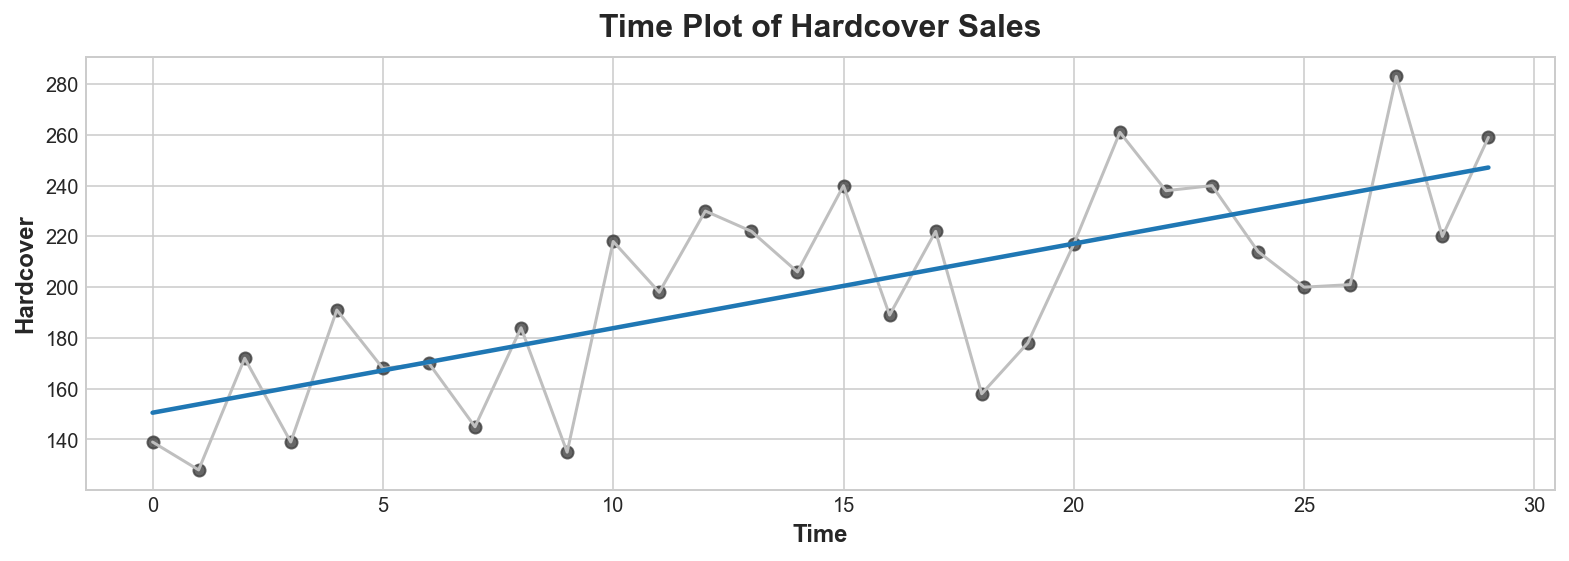

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11,4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight='bold',
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales')
plt.show()

feature de passo temporal deixa o seu modelo dependente do tempo. Uma série é dependente do tempo se os valores pode ser previstos ao tempo em que ela ocorre. Na série Hardcover Sales, podemos prever que as vendas no mês são geralmente mais altas no fim do que nos dias iniciais do mês.

**Lag features**

para fazermos uma lag feature nos mudamos as observações do target da série para que pareça que ocorreu com atraso no tempo. Aqui nos criamos um 1-step lag feature, deslocando por múltiplos passos também é possível

In [8]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

Hardcover  Lag_1
Date                        
2000-04-01        139    NaN
2000-04-02        128  139.0
2000-04-03        172  128.0
2000-04-04        139  172.0
2000-04-05        191  139.0

Regressão linear com a lag feature produz o seguinte modelo:

target = weight * lag + bias

então com a lag feature podemos encaixar curvas em lag plots onde cada observação da série é plotada contra uma observação prévia da mesma

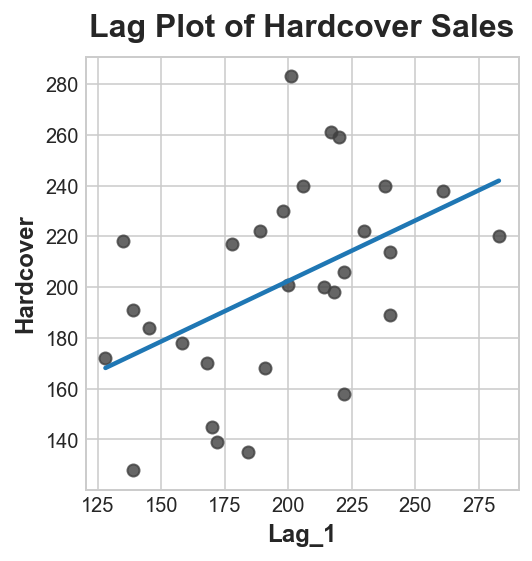

In [9]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales')
plt.show()

podemos ver pela lag plot que as vendas de um dia (para Hardcover) está correlacionada com as vendas do dia anterior (Leg_1). Quando vemos esse tipo de relacionamento, sabemos que a lag feature será útil.

mais genericamente, lag features irão deixar o seu modelo dependente da série. A série temporal é série dependente quando as observações podem ser previstas das observações anteriores. Em Hardcover Sales, podemos prever maiores vendas em um dia usualmente significam maiores vendas no dia seguinte.

adaptando um algorítmo de machine learning para problemas de série temporal é bastante sobre feature engineering com índice de tempo e lag. Para a maior parte deste curso vamos utilizar regressão linear pela simplicidade, mas essas features serão úteis para qualquer algorítmo se escolha para tarefas de previsão.

**Exemplo - Tunnel Traffic**

Tunnel Traffic é uma série descrevendo o número de veículos viajando pelo túnel Baregg na Suíça para cada dia de Novembro de 2003 até Novembro de 2005. Nesse exemplo iremos ver alguma prática sobre aplica regressão linear em time-step feature e uma lag feature.

In [13]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter('ignore') # ignorar alertas para manter limpo os outputs das célucas

# Setar Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11,4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Carregar dataset Tunnel Traffic
data_dir = Path('Time_Series/archive-2')
tunnel = pd.read_csv(data_dir / 'tunnel.csv', parse_dates=['Day'])

# criando a série temporal no pandas configurando o índice como a coluna data. Nos passamos 'Day' como tipo data quando usamos parse_dates ao carregar os dados
tunnel = tunnel.set_index('Day')

# por default, o pandas cria o dtype 'Timestamp' para o 'DatetimeIndex' (equivalente a 'np.datetime64', representando a série temporal como uma sequência de medidas
# tomadas momentos singulares. O 'PeriodIndex' por outro lado, representa a série temporal como uma sequência de quanidades acumuladas sobre períodos do tempo. 
# Períodos são frequentimente mais fáceis de se trabalhar. É o que iremos usar neste curso)
tunnel = tunnel.to_period()

tunnel.head()

NumVehicles
Day                    
2003-11-01       103536
2003-11-02        92051
2003-11-03       100795
2003-11-04       102352
2003-11-05       106569

**time-step feature**

a série temporal não tem nenhuma data faltante, nos podemos criar uma time dummy contando o comprimento da série.

In [18]:
df = tunnel.copy()
df['Time'] = np.arange(len(tunnel.index))

df.head()

NumVehicles  Time
Day                          
2003-11-01       103536     0
2003-11-02        92051     1
2003-11-03       100795     2
2003-11-04       102352     3
2003-11-05       106569     4

Procedimento para fittar a regressão linear no modelo segue os padrões dos passos do scikit-learn

In [19]:
from sklearn.linear_model import LinearRegression

# treinando os dados
X = df.loc[:, ['Time']] # features
y = df.loc[:, 'NumVehicles'] # target

# Treinando o modelo
model = LinearRegression()
model.fit(X, y)

# armazenar os valores fittados como uma série temporal com os mesmo índices dos dados do treino
y_pred = pd.Series(model.predict(X), index=X.index)

O modelo criado é (aproximadamente): vehicles = 22.5 * Time + 98176. Plotando os valores fitados sobre o tempo podemos ver como a regressão linear se encaixou com a time dummy, criando uma linha de tendência definida por essa equação.

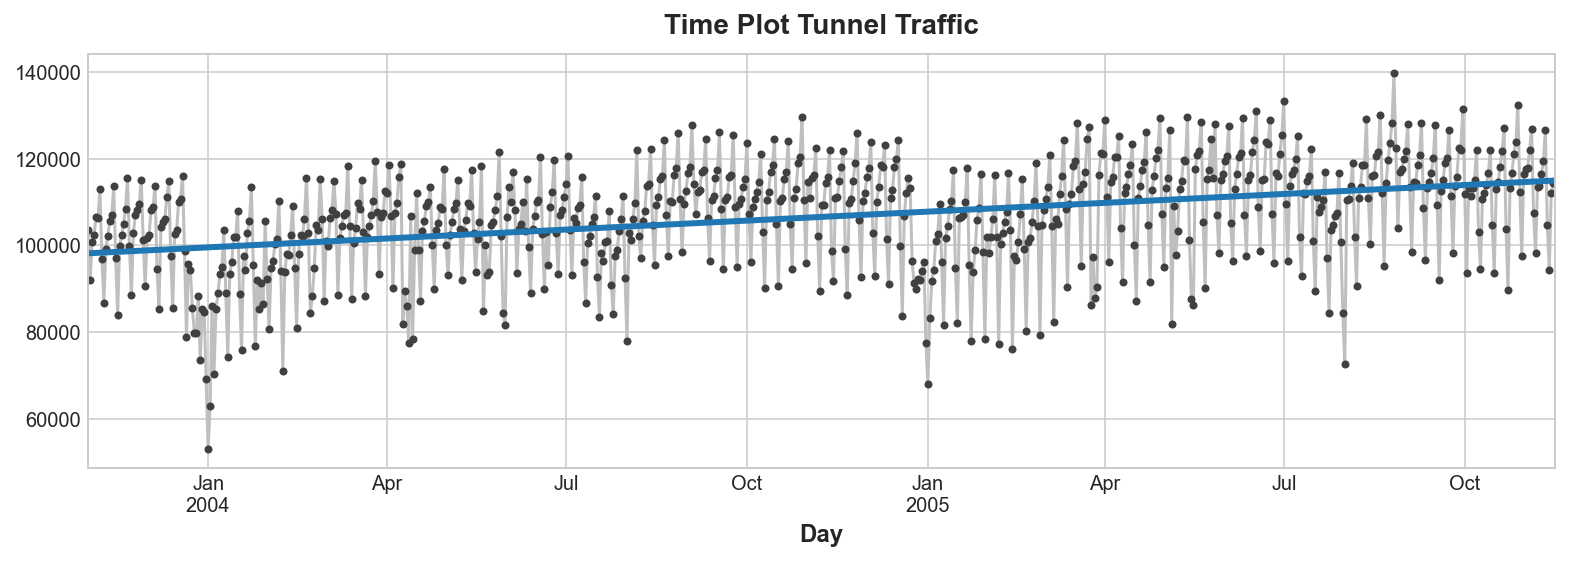

In [20]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot Tunnel Traffic')
plt.show()

**Lag feature**

Pandas possui um simples método para criar uma lag series, o método shift.

In [22]:
df['Lag_1']  = df['NumVehicles'].shift(1)
df.head()

NumVehicles  Time     Lag_1
Day                                    
2003-11-01       103536     0       NaN
2003-11-02        92051     1  103536.0
2003-11-03       100795     2   92051.0
2003-11-04       102352     3  100795.0
2003-11-05       106569     4  102352.0

quando criamos lag features, precisamos decidir o que fazer com o valor faltante produzido. Preenchê-lo é uma opção, talvez com 0 ou por 'backfilling' pelo primeiro valor conhecido. Em vez disso aqui vamos descargar o valor faltante, certificando iremos descartar os valores também do target para as datas correspondentes.

In [25]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True) # descartando valores faltantes do dataset
y = df.loc[:, 'NumVehicles'] # criando o target
y, X = y.align(X, join='inner') # descartando os valores correspondentes no target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

O lag plot nos mostra como podemos relacionar os números de vículos de um dia com o dia anterior

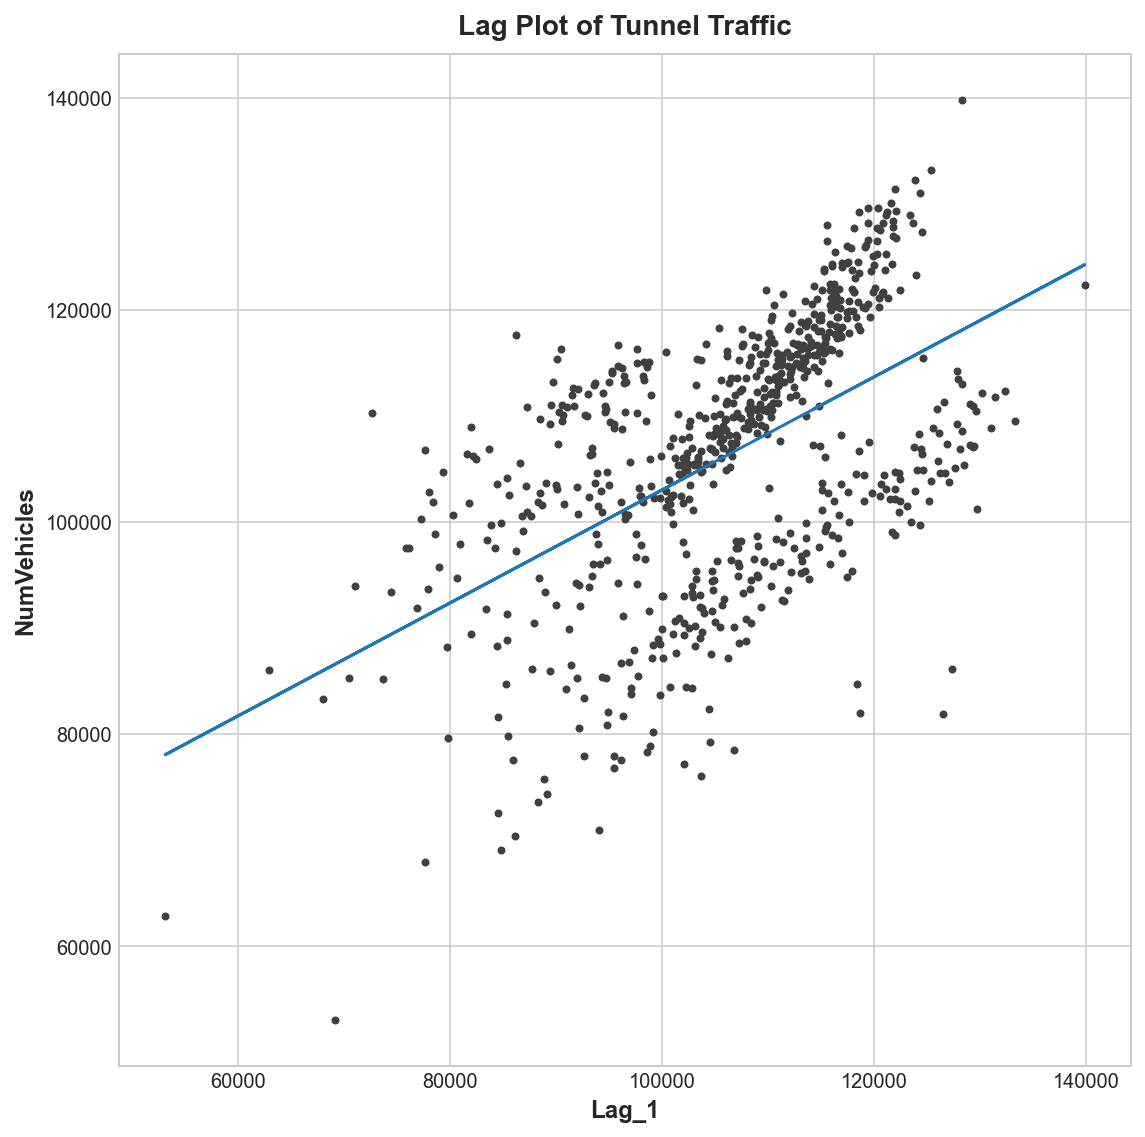

In [34]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic')
plt.show()

O que essa previsão de uma lag feature significa sobre como podemos prever uma série através do tempo? A seguinte plotagem no tempo nos mostra como nossa previsão responde ao comportamento da série em um passado recente.

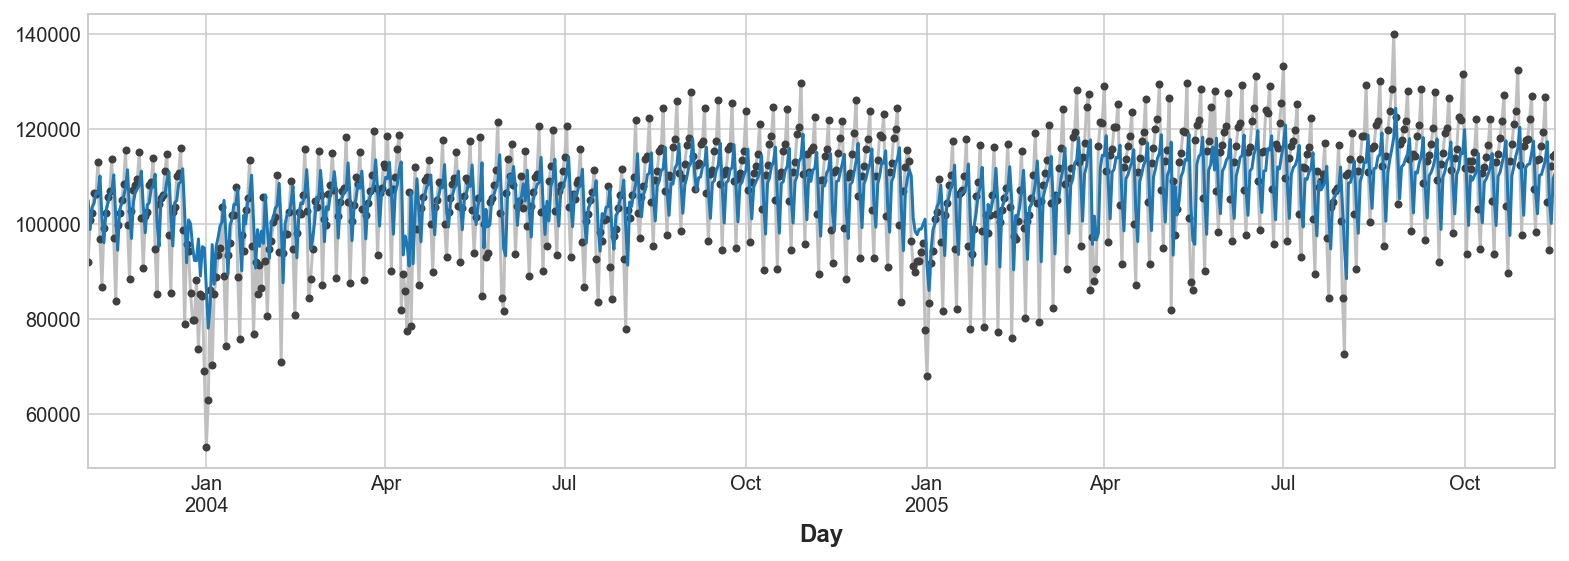

In [35]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

Os melhores modelos em séries temporais usualmente incluem algumas combinações de time-step features e lag features. Nas próximas lições vamos aprender fazer modelagens de features com padrões mais comuns em séries temporais utilizando as features desta lição como ponto de partida.

## Exercícios

In [23]:
# setando o ambiente

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

data_dir = Path('Time_Series/archive-2/')
comp_dir = Path('Time_Series/store-sales-time-series-forecasting/')

book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_br': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

Uma vantagem da regressão linear sobre outros algorítmos mais complexos é que o modelo criado é explicável. É fácil de interpretar que contribuição cada feature faz sobre as predições. No modelo target = weight * feature + bias, o weight diz o quanto o target muda em média para cada unidade da feature muda.

rode a próxima célula para vermos a regressão linear no Harcover Sales

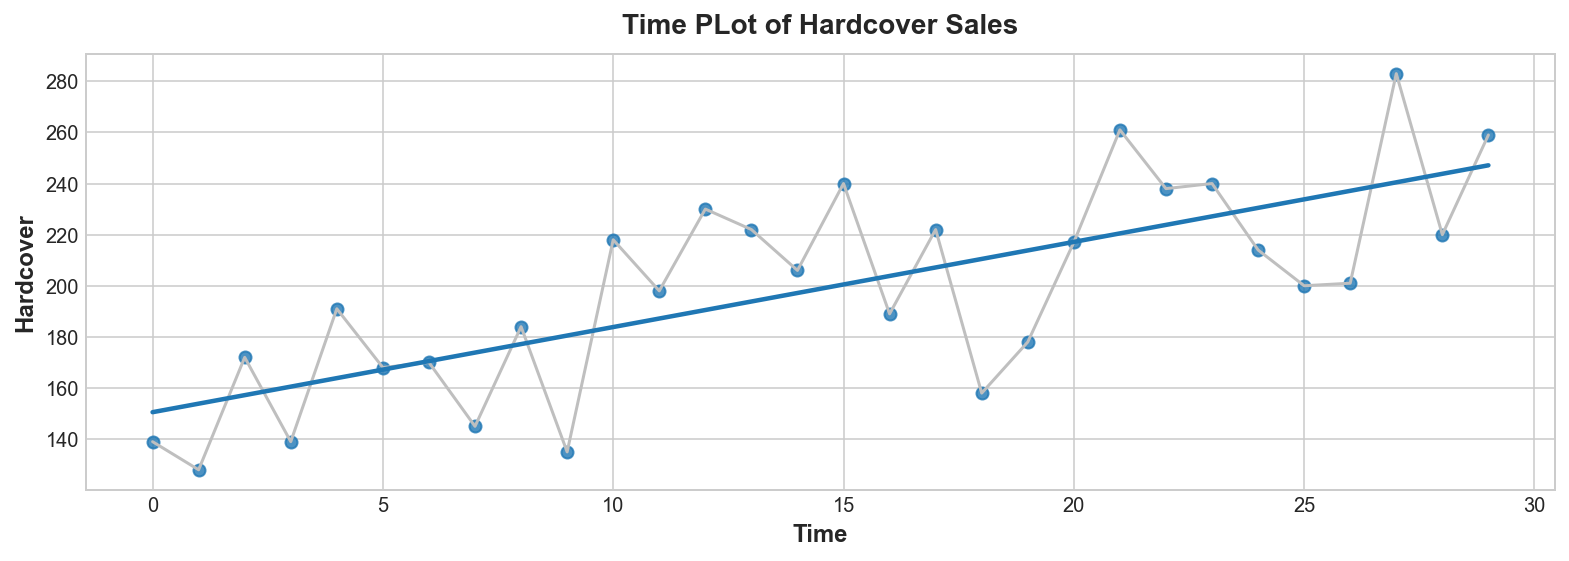

In [15]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None)
ax.set_title('Time PLot of Hardcover Sales')
plt.show()

### 1) Interprete a regressão linear com a time dummy

A regressão linear tem a equação de (aproximadamente) hardocver = 33.3 * Time + 150.5. Em 6 dias o quanto em média se espera que as vendas de Hardcover mude?

R: a mudança em 6 steps de tempo corresponde a uma mudança média de 6 * 3.33 = 19.98 nas vendas de Hardcover.

Interpretando o coeficiente da regressão linear ajuda a reconhecer a dependência serial no plot do tempo. Considerando o modelo target = weight * lag_1 + error, onde o error é o ruído randômic e weight é um número entre -1 e 1. O weight nesse caso nos diz o quanto parecido é o próximo passo referente ao passo anterior, enquanto weight for mais próximo de -1, significa que o target será mais próximo ao sinal anterior.

### 2) Interprete a regressão linear com a lag feature

rode a seguinte célula para ver duas séries geradas de acordo com o modelo descrito

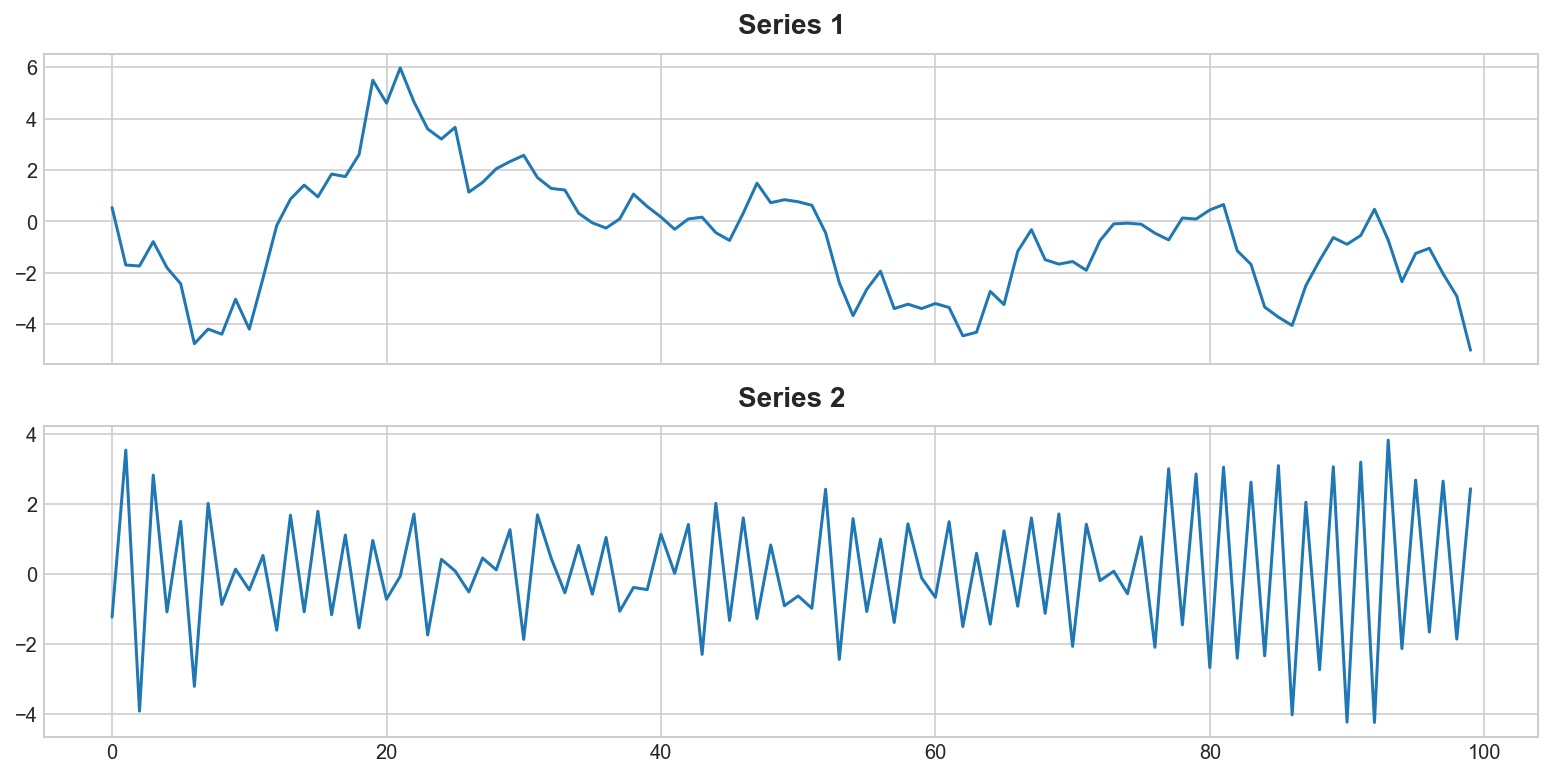

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2')
plt.show()

Uma dessas séries tem a equação target = 0.95 * lag_1 + error e a outra tem a equação target = -0.95 * lag_1 + error, diferenciando apenas pelo sinal da lag feature. Você pode dizer qual equação vai em qual série?

R: a Série 1 é gerada pela eq target = 0.95 * lag_1 + error e a Série 2 é gerada pela eq target = -0.95 * lag_1 + error.

Agora iremos iniciar com a Competição Série Temporal Store Sales. O dataset inteiro compila quase 1800 séries de registro das vendas por vários tipos de produtos para familias desde 2013 até 2017. Para esta lição, vamos apenas trabalhar com uma única série (avarage_sales) que é a média de vendas no dia.

### 3) Fit uma time-step feature

complete o código abaixo para criar um modelo de regressão linear com uma time-step feature na série de média de vendas de produtos. O target é a coluna chamada 'sales'.

In [28]:
from sklearn.linear_model import LinearRegression

# Criando dataframe com a coluna média de vendas
df = average_sales.to_frame()

# criando coluna temporal
time = np.arange(len(df.index))
df['time'] = time

# Criando dados de treino
X = df.loc[:, ['time']]
y = df.loc[:, 'sales']

# treinando o modelo
model = LinearRegression()
model.fit(X, y)

# guardando os valores fittados na série temporal com o mesmo índice
# dos dados de treinamento
y_pred = pd.Series(model.predict(X), index=X.index)

Rode a celula abaixo para plotar os resultados

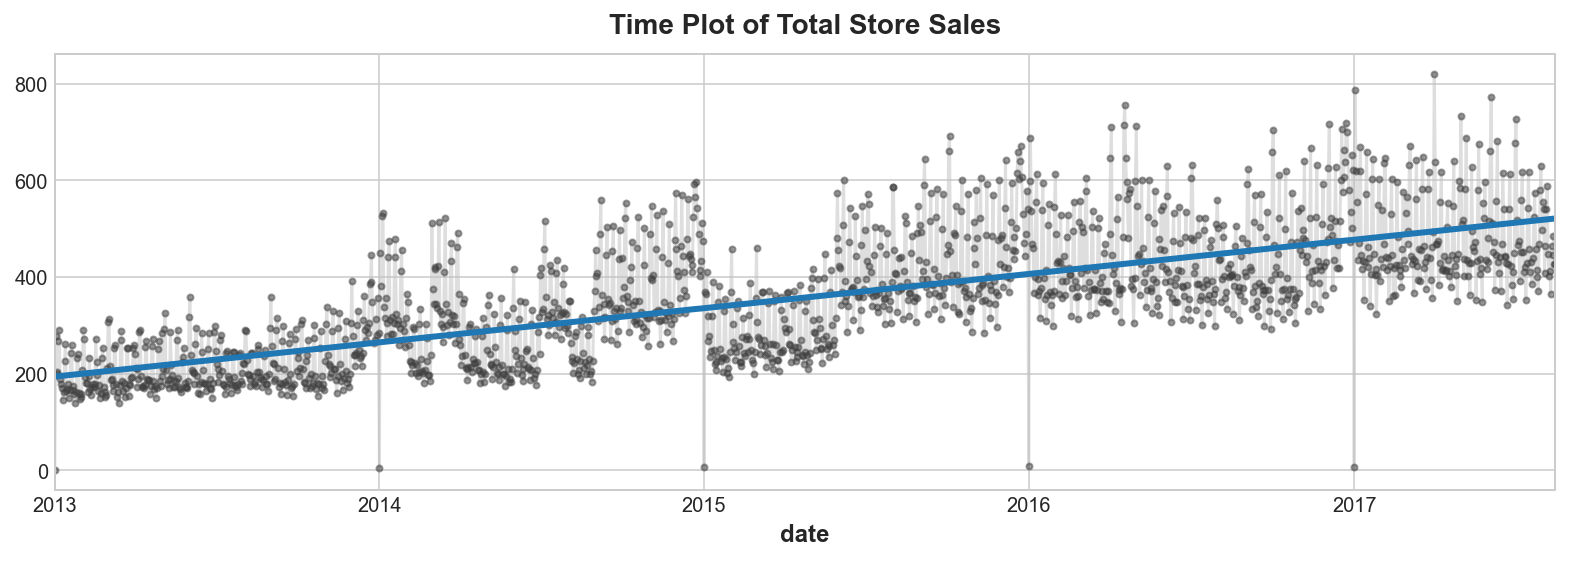

In [30]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales')
plt.show()

### 4) Fit uma lag feature para Store Sales

Complete o código abaixo para criar um modelo de regressão linear com uma lag feature numa série de média de vendas por produto. O target está na coluna 'sales' do df.

In [31]:
df = average_sales.to_frame()

# criando a lag feature
lag_1 = df['sales'].shift(1)
df['lag_1'] = lag_1

# Criando dados para treinamento
X = df.loc[:, ['lag_1']].dropna()
y = df.loc[:, 'sales']
y, X = y.align(X, join='inner') # dropando os valores corresponpdentes no target

# criando modelo
model = LinearRegression()
model.fit(X, y)

# Guardando os valores fitados numa série temporal com o mesmo índice dos dados de treino
y_pred = pd.Series(model.predict(X), index=X.index)

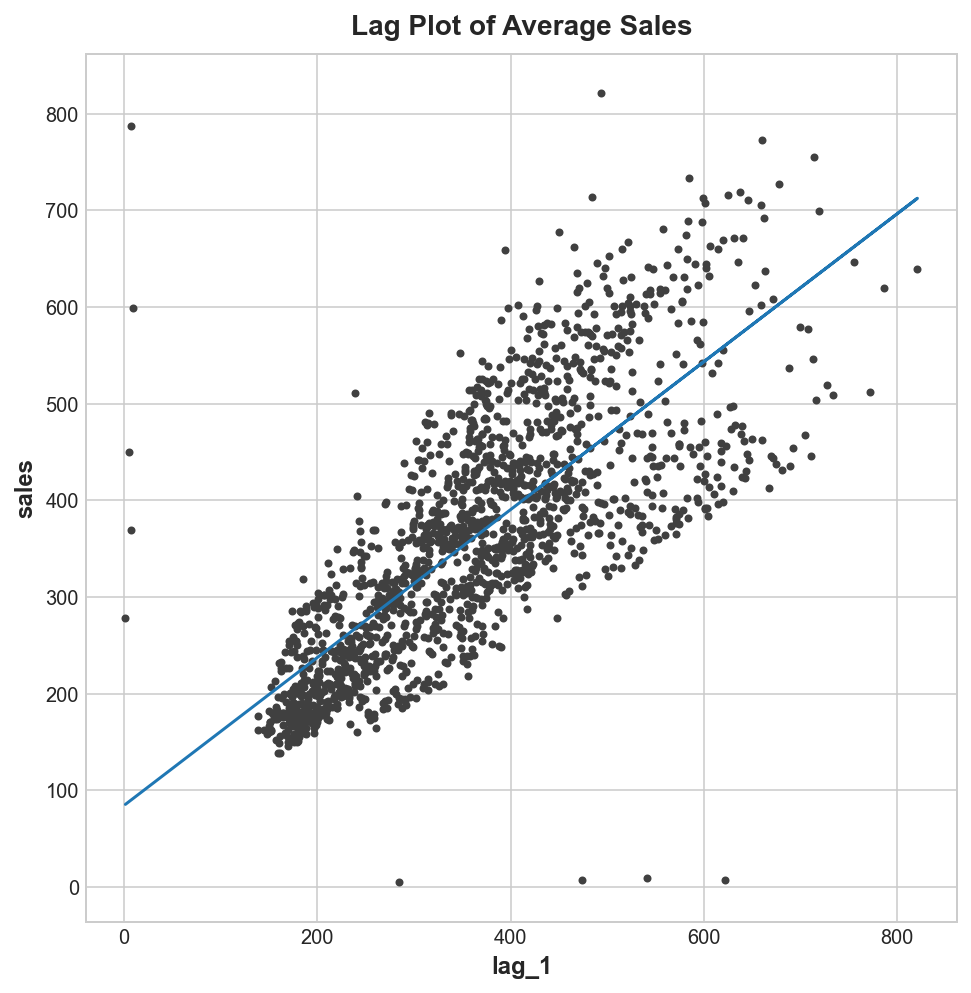

In [34]:
# plotando os dados

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales')
plt.show()

# Trend (Tendência)

Modelo a longo prazo muda com a médias móveis e o time dummy

**O que é tendência?**

a componente tendência de uma série temporal representa a persistência, mudança de longo prazo na média da série. A tendência é a parte em movimento mais lenta da série, a parte representando a maior escala de tempo de importância. Na série temporal do Product Sales, uma tendência de altas pode representar um efeito de expansão do mercado e mais pessoas tomam conhecimento do produto anos após ano.

<center><img src= https://i.imgur.com/ZdS4ZoJ.png>


Neste curso, vamos focar em tendências de médias. Um pensamento mais generalista, qualquer persistência e uma mudança lenda de movimento na série pode ser constituída uma tendência. Séries temporais geralmente possuem tendência em sua variação, por exemplo.

**Plot de Média Móvel**

Para ver qual o tipo de tendência a série temporal tem, podemos usar o plot de média móvel (moving avarage plot). Para computar a média mível de uma série temporal calculamos a média dos valores dentro de uma janela de amostras móvel de comprimento definido. Cada ponto no gráfico representa  a média de todos os valores na série que cai na janela de cálculo. A ideia é suavizar qualquer flutuação a longo prazo da série, então apenas alterações de longo prazo serão percebidas.

<center><img src= https://i.imgur.com/EZOXiPs.gif>

Note como a série Mauna Loa acima repete o movimento curto de subida e descida ano após ano, mudança sazonal a curto prazo. Para mudança fazer parte tendência, deve-se ocorrer em um longo período maior que as alterácões sazonais. Para a série Mauna Loa, escolhemos uma janela de 12 meses sobre a temporada para cada ano.

**Engenharia de tendência**

Uma vez que identificamos o shape da tendência, podemos tentar modelar usando a step-time feature. Nos já vimos como usar uma time dummy para modelar uma tendência linear.

targer = a * time + b

podemos calcular outros tipos de tendências atravez de transformações da time dummy. Se a tendência aparecer quadrática (barábola), podemos apenas adicionar o quadrado da time summy para adequação da feature. Assim temos:

target = a * time ** 2 + b * time + c

Regressão linear irá aprender o coeficiênte a, b, c.

As curvas da tendência da figura abaixo ambas utilizam esse tipo de função do LinearRegression do scikit-learn.

<center><img src= https://i.imgur.com/KFYlgGm.png>



Se você não viu o truque antes, pode não ter percebido que a regressão linear pode encaixar curvas que não sejam linhas.

A ideia é que você possa prober curvas com o shape apropriado das features, então a regressão linear pode aprender como combiná-las no caminho que melhor encaixar com o target.

**Exemplo - Tunnel Traffic**

nesse exemplo iremos criar uma modelo de tendência para o dataset Tunnel Traffic

In [3]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore") # para ignorar os alertas no output para células limpas

# settar Matplotlib default
plt.style.use("seaborn-whitegrid")
plt.rc('figure', autolayout=True, figsize=(16,8))
plt.rc(
    'axes', 
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color='0.75',
    style='.-',
    markeredgecolor='0.25',
    markerfacecolor='0.25',
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# carregando o dataset Tunnel Traffic
data_dir = Path('Time_Series/archive-2/')
tunnel = pd.read_csv(data_dir / 'tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day').to_period()

Vamos fazer um plot de média móvel e ver que tipo de tendência essa série temporal tem. Já esta série possui observações diárias, vamos escolher uma janela de 365 dias para suavizar qualquer alteração de curto prazo ao longo do ano.

Para criar uma média móvel, primeiro usamos método 'rolling' para começar o janelamento do cálculo. Seguido do método 'mean' para calcular a média sobre o janelamento. Como podemos ver, a tendência do Tunnel Traffic aparenta ser linear.

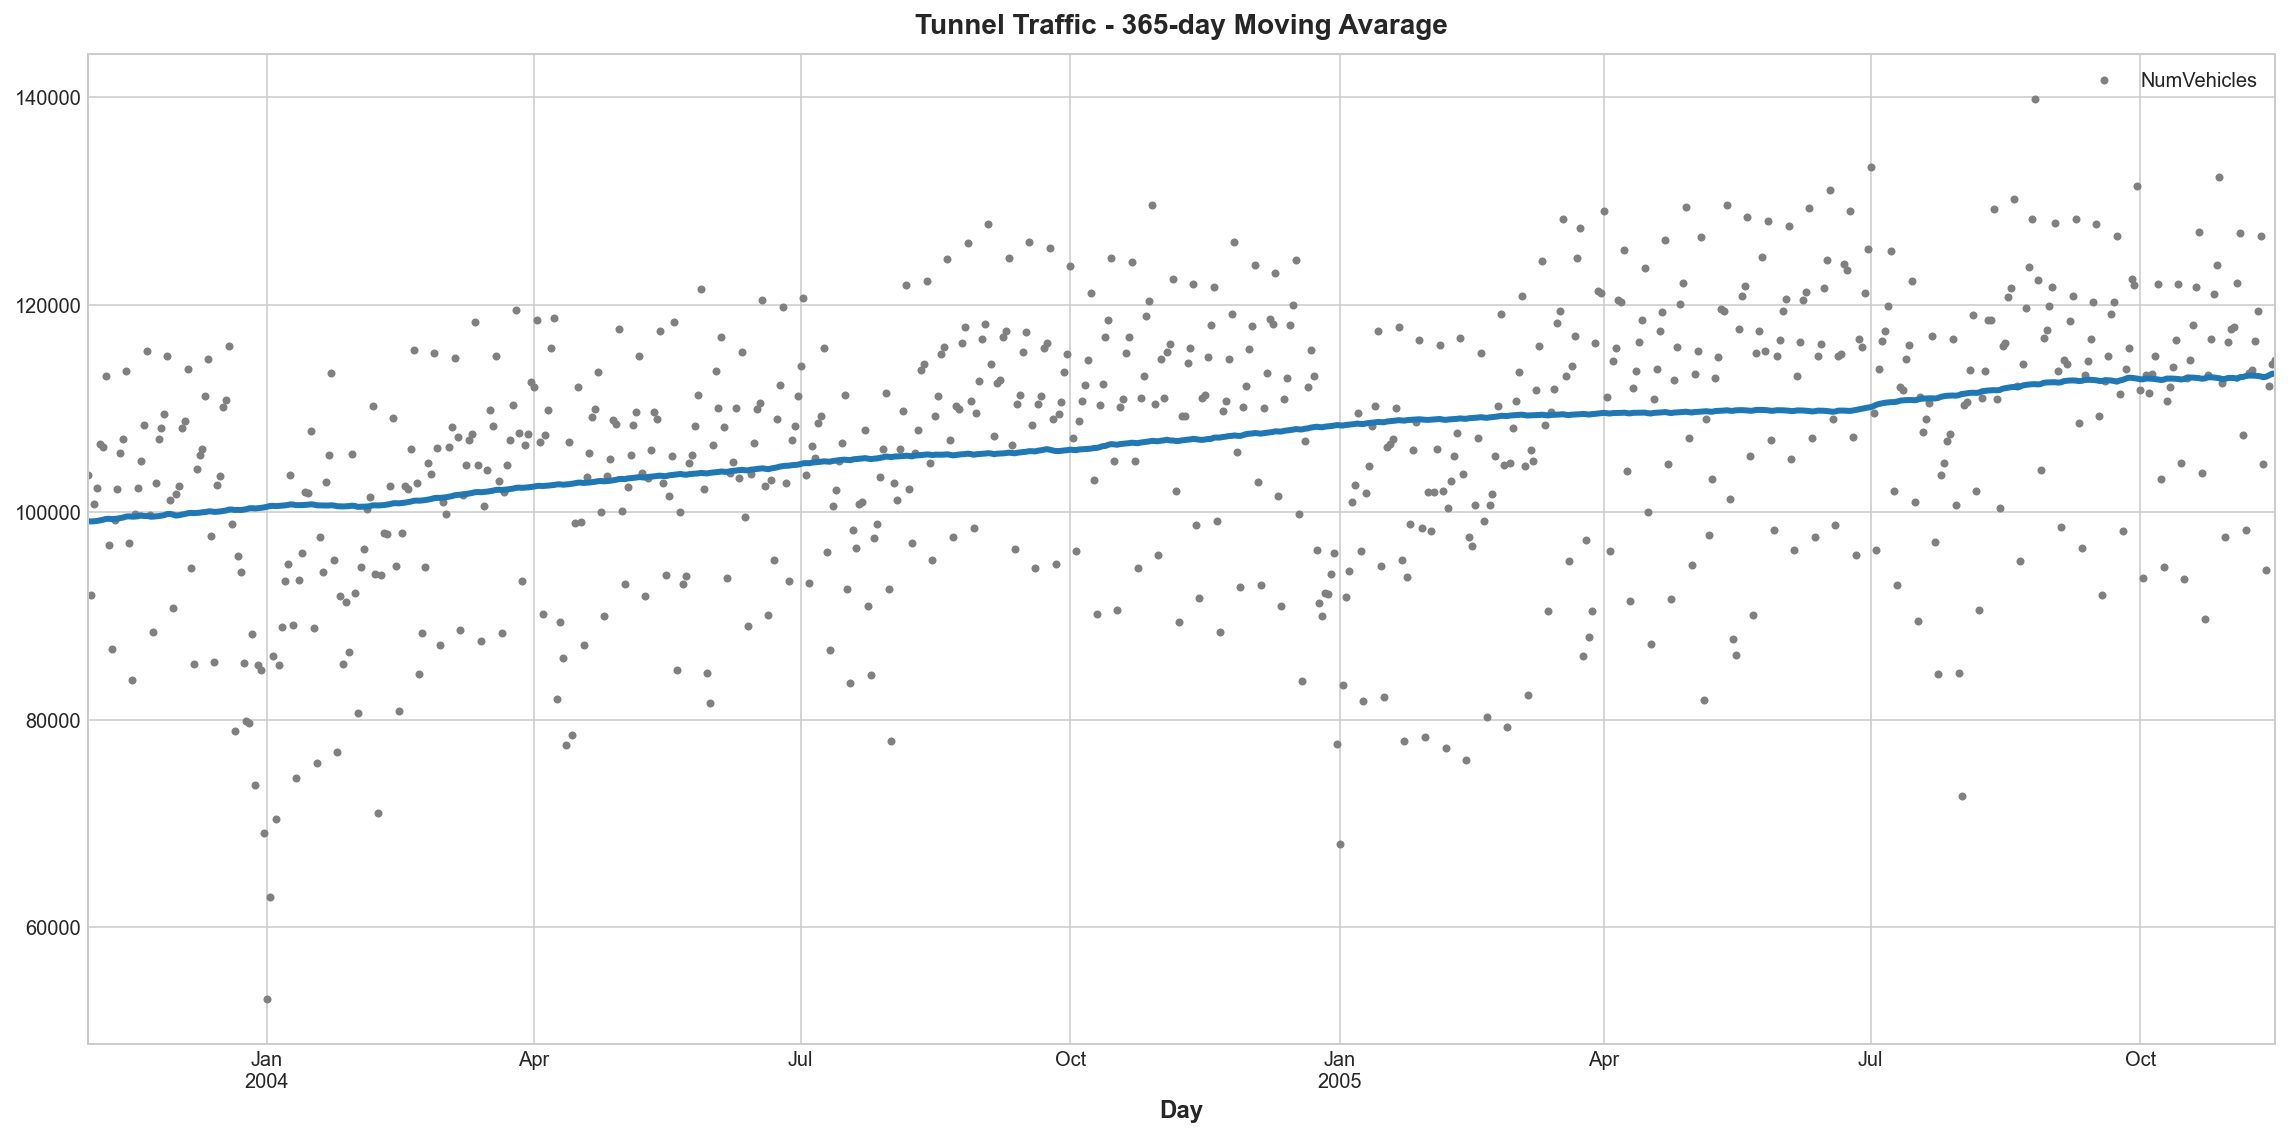

In [4]:
moving_average = tunnel.rolling(
    window=365,         # janela de 365 dias
    center=True,        # coloca a média no centro da janela
    min_periods=183,    # escolhe a metade do janelamento
).mean()                # calcular a média (também pode ser a mediana (median), standard(std), mínimo (min), máximo (max))

ax = tunnel.plot(style='.', color='0.5')
moving_average.plot(
    ax=ax, linewidth=3, title='Tunnel Traffic - 365-day Moving Avarage', legend=False,
)
plt.show()

Na lição 1, os fizemos uma time-dummy diretamente no pandas. A partir de agora iremos utilizar a função statsmodels da lib chamada 'DeterministricProcess'. Usar esta função irá nos ajudar a evitar algumas falhas em casos complicados que podem surgir com séries temporais e regressão linear. O argumento 'order' se refere ao ordem polinomial da função: 1 para linear, 2 para quadrática, 3 para cúbica e assim por diante.

In [5]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,         # datas dos dados de treinamento
    constant=True,              # dummy feature para o bias (Y_intercept)
    order=1,                    # o time dummy (tendência)
    drop=True,                  # dropar os prazos necessários para evitar colinearidade
)
# 'in_simple' cria uma feature para as datas do argumento index
X = dp.in_sample()

X.head()

const  trend
Day                     
2003-11-01    1.0    1.0
2003-11-02    1.0    2.0
2003-11-03    1.0    3.0
2003-11-04    1.0    4.0
2003-11-05    1.0    5.0

( O Processo determinístico, a propósito, é uma técnica de prazo da série temporal que não é randomica ou completamente determinada, como as séries 'const' ou 'trend' são. Features derivadas do índice temporal são geralmente determinística.)

Vamos criar nossa tendência basicamente depois, embora observe a adição do argumento 'fit_intercept=False'

In [6]:
from sklearn.linear_model import LinearRegression

y = tunnel['NumVehicles'] # o target

# para interceptar é o mesmo da feature 'const' do 'DeterministicProcess'. A LinearRegression se comporta mau para features duplicadas, então precisamos ter certeza de excluir aqui
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

A tendência descoberta pela nosso modelo 'LinearRegression' é praticamente idêntica ao plot da média móvel, o que sugere que a tendência linear é a melhor decisão nesse caso.

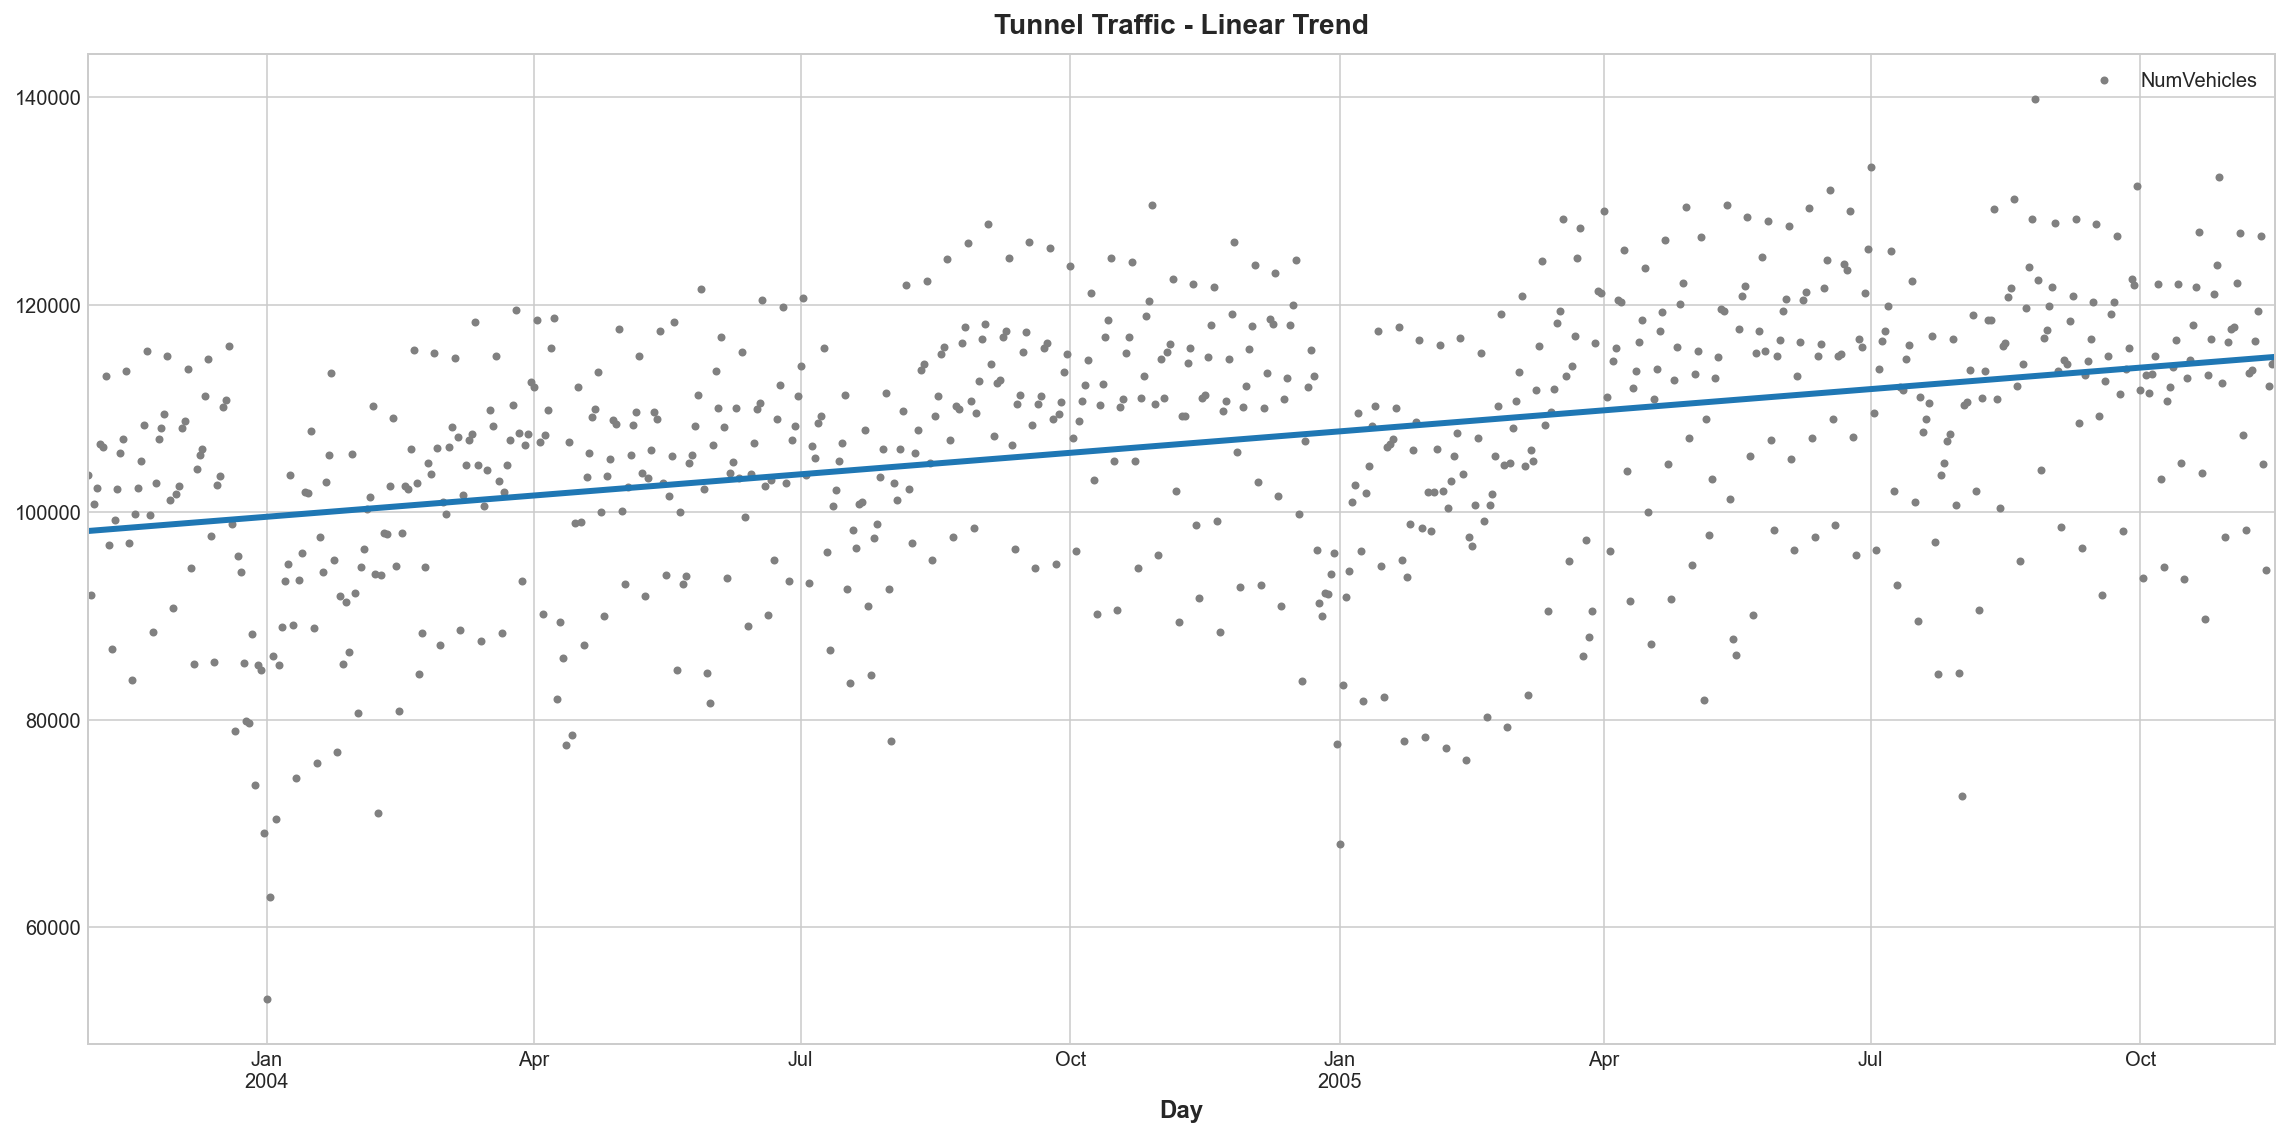

In [7]:
ax = tunnel.plot(style='.', color='0.5', title='Tunnel Traffic - Linear Trend')
_ = y_pred.plot(ax=ax, linewidth=3, label='Trend')

Para fazer previsões, podemos aplicar nosso modelo as nossas features de amostras. 'Out of sample' se refere a quantas vezes fora ao período de observação dos dados de treinamento. Aqui como podemos faer uma previsão para 30 dias.

In [8]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Vamos plotar a porção dessa série para ver a tendência da previsão para os próximos 30 dias.

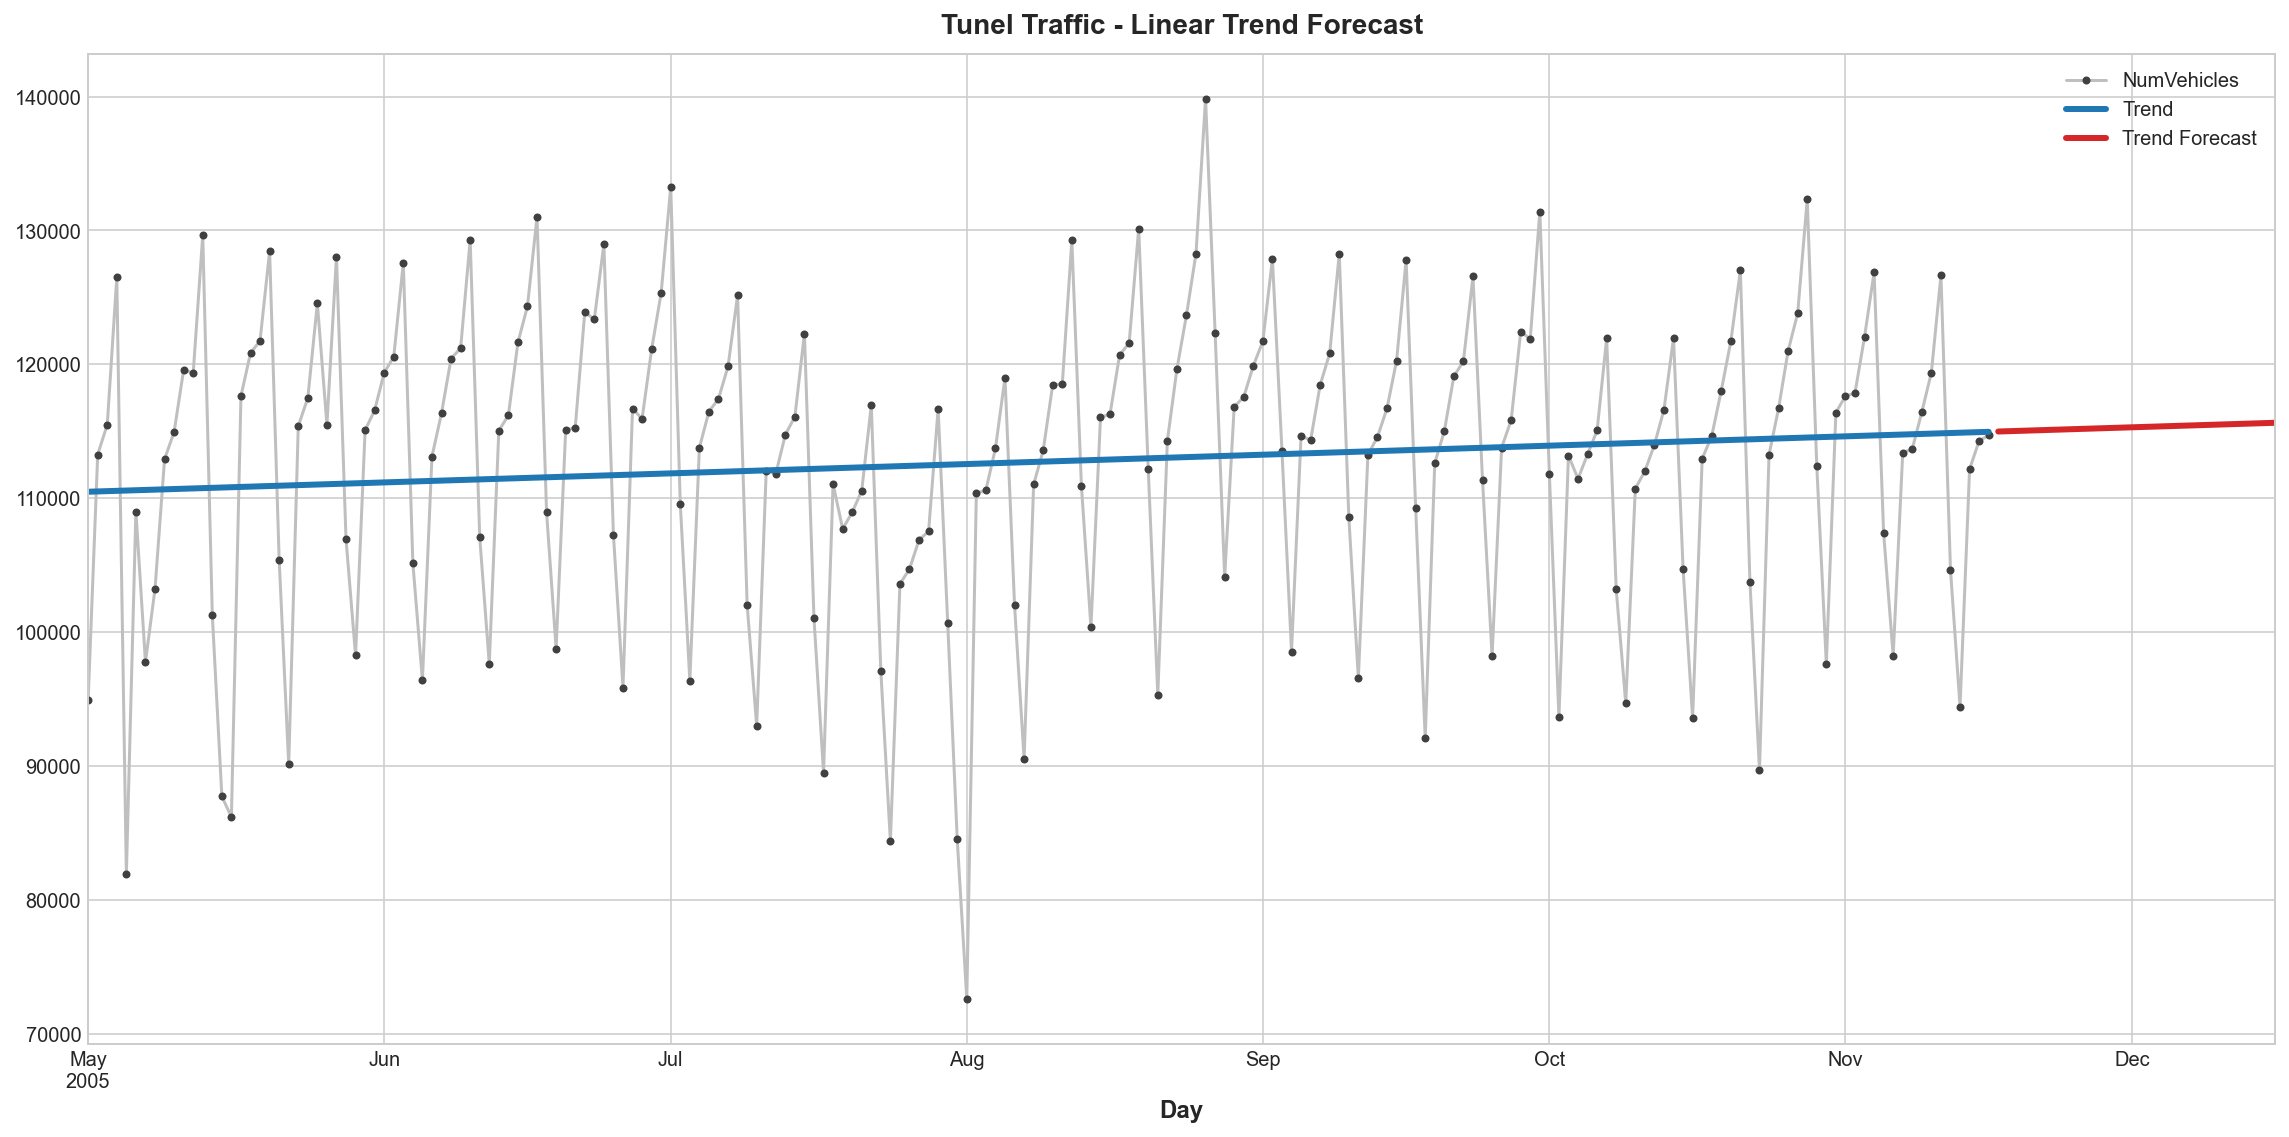

In [9]:
ax = tunnel['2005-05':].plot(title='Tunel Traffic - Linear Trend Forecast', **plot_params)
ax = y_pred['2005-05':].plot(ax=ax, linewidth=3, label='Trend')
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3')
_ = ax.legend()
plt.show()

O modelo de tendência que aprendemos acaba de ser útil por diversas rasões. Podendo ser utilizado como uma linha base ou ponto de partida para modelos mais sofisticados, nos podemos também usar como componente para modelos híbridos, que são incapases de aprender tendências (como por exemplo XGBoost e a Random Forest). Iremos aprender mais sobre essa técnica na lição 5.

### Exercício

rode a célula abaixo para aprontar o ambiente

In [55]:
# setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

data_dit = Path('Time_Series/archive-2/')
comp_dir = Path('Time_Series/store-sales-time-series-forecasting/')

retail_sales = pd.read_csv(
    data_dir / 'us-retail-sales.csv',
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

### 1) Determine a tendência com o plot da média móvel

O dataset de US Retail Sales contém o número de vendas mensal da indústria de varejo nos Estados Unidos. Rode a Célula abaixo para plotar a série Foor and Beverage.

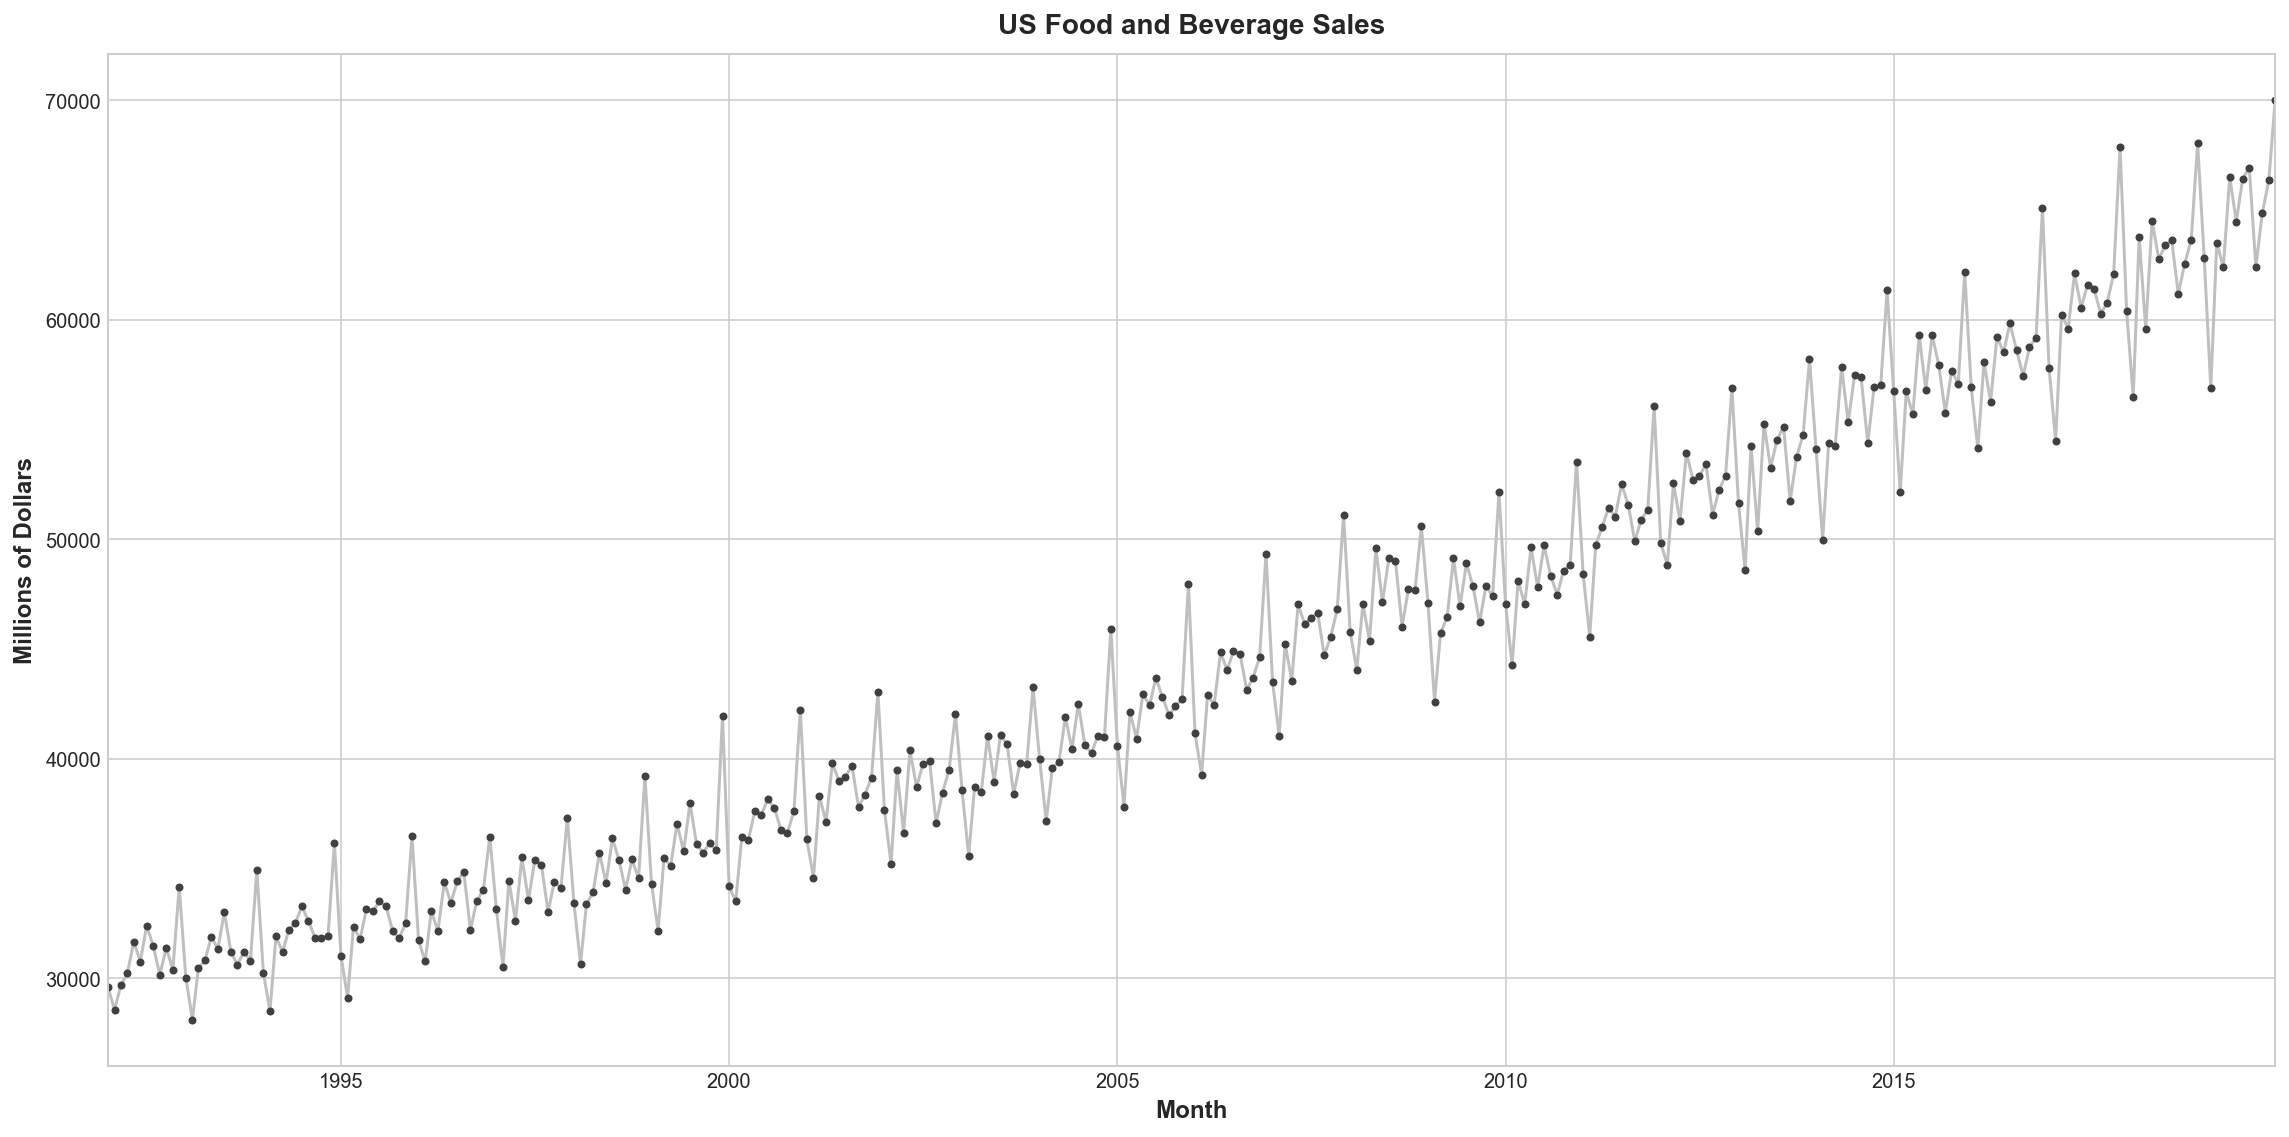

In [56]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars")
plt.show()

Faça um plot da média móvel para estimar a tendência dessa série

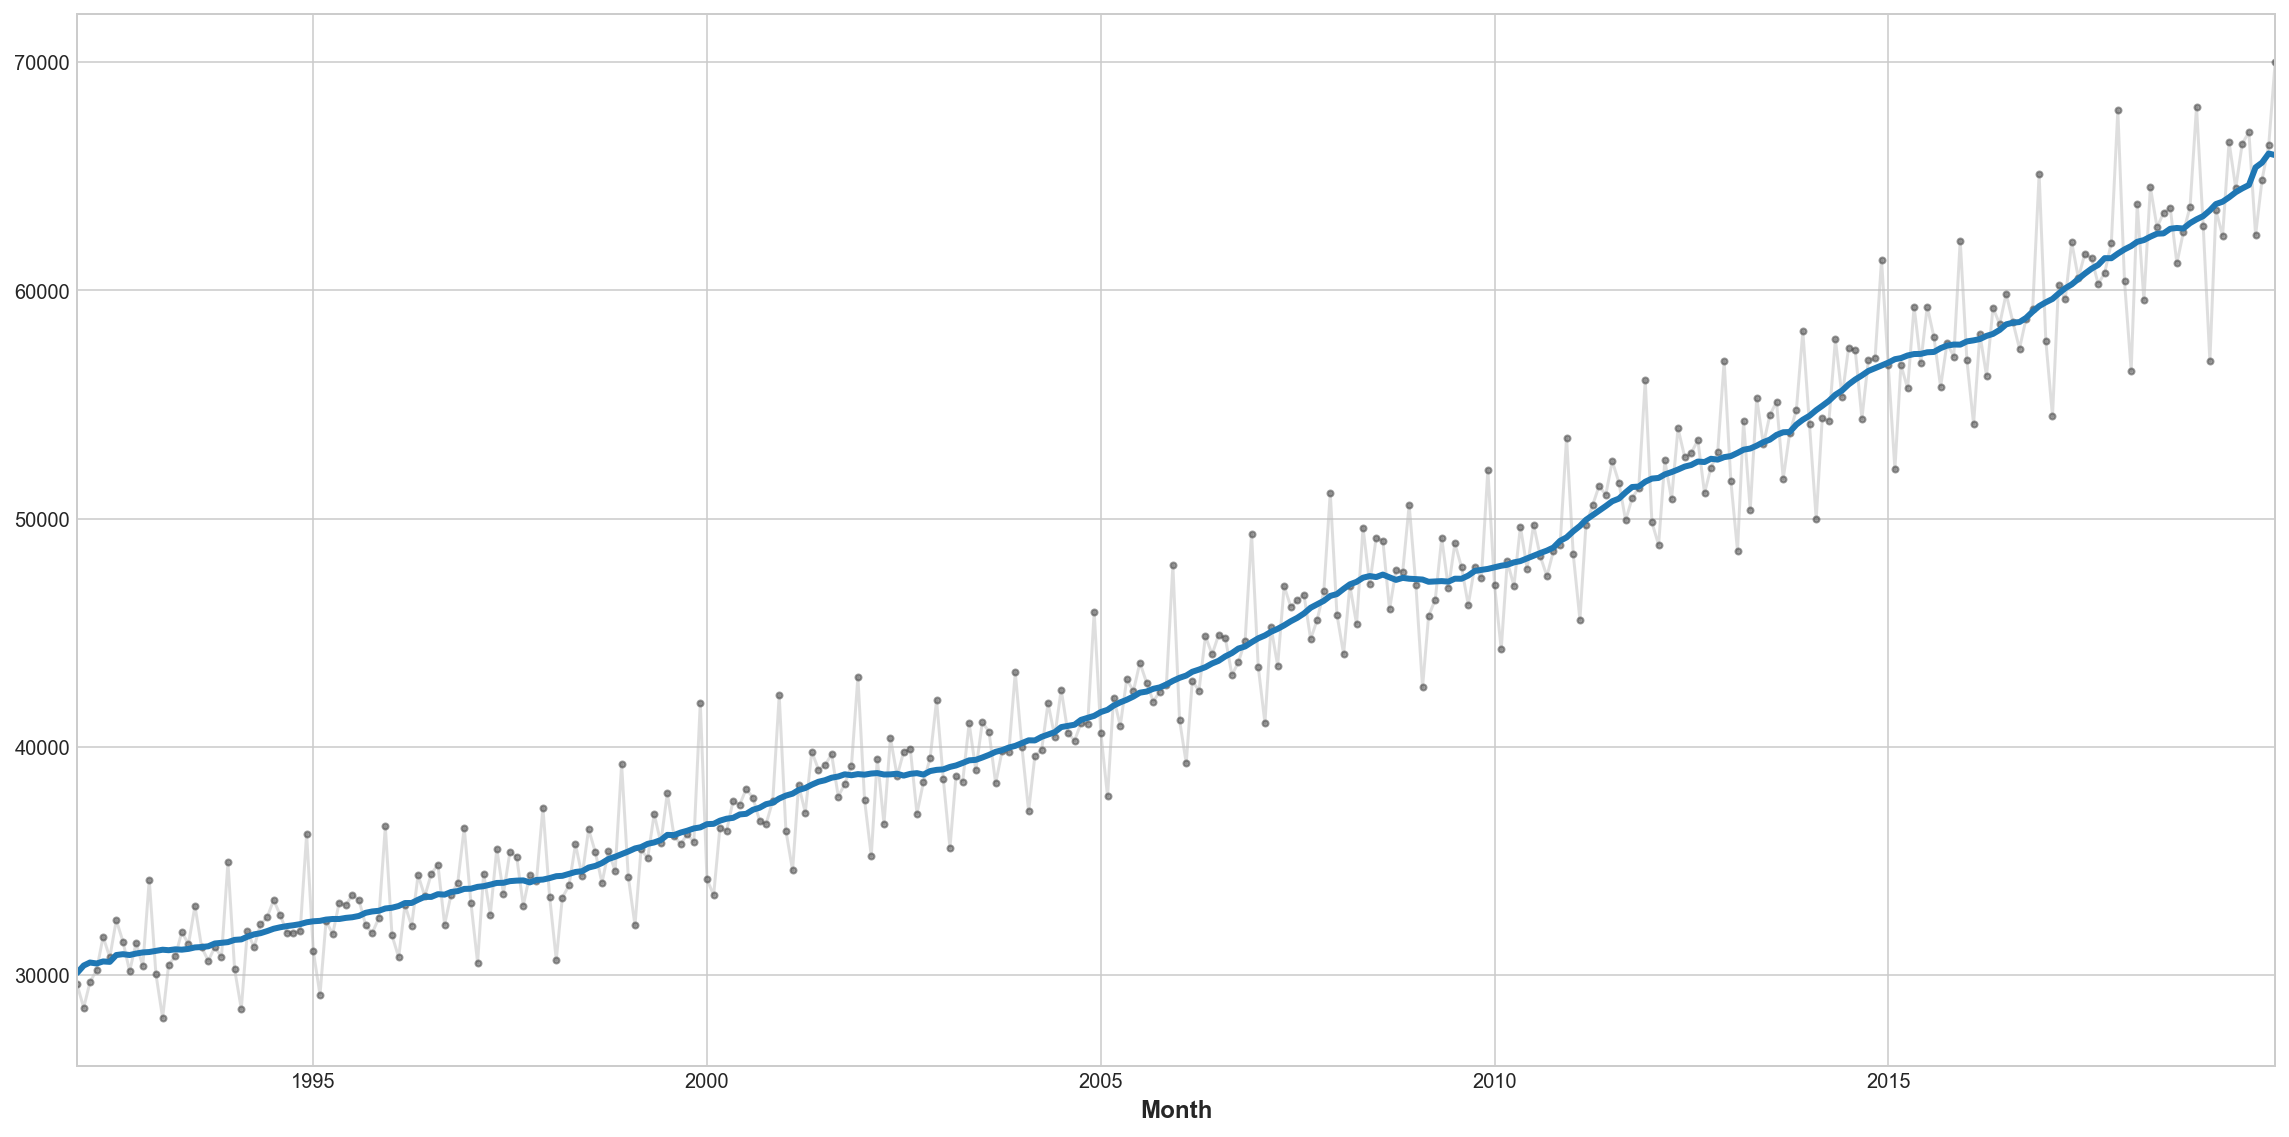

In [57]:
trend = food_sales.rolling(
    window=12,
    center=True,
    min_periods=6,
).mean()

# plotando
ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

### 2) Identifique a tendência

Qual ordem do polinomio parece ser mais apropriada para a série Food and Beverage? Podemos pensar em uma curva não polinomial para trabalharmos melhor?

R: A inclinação pra cima sugere um um polinômio de ordem 2 (quadrático) seja mais apropriado.

Se você já trabalhou com séries temporais econômicas antes, pode ter percebido que a taxa de crescimento de Food and Beverage Sales é melhor expressada em alterações de percentagem. Alterações em Percentagem podem oferecer uma modelagem utilizando uma curva exponêncial.

Vamos continuar usando a série temporal da média de vendas nesta lição. Rode a célula abaixo para ver o plot da média móvel de average_sales estimando a tendência.

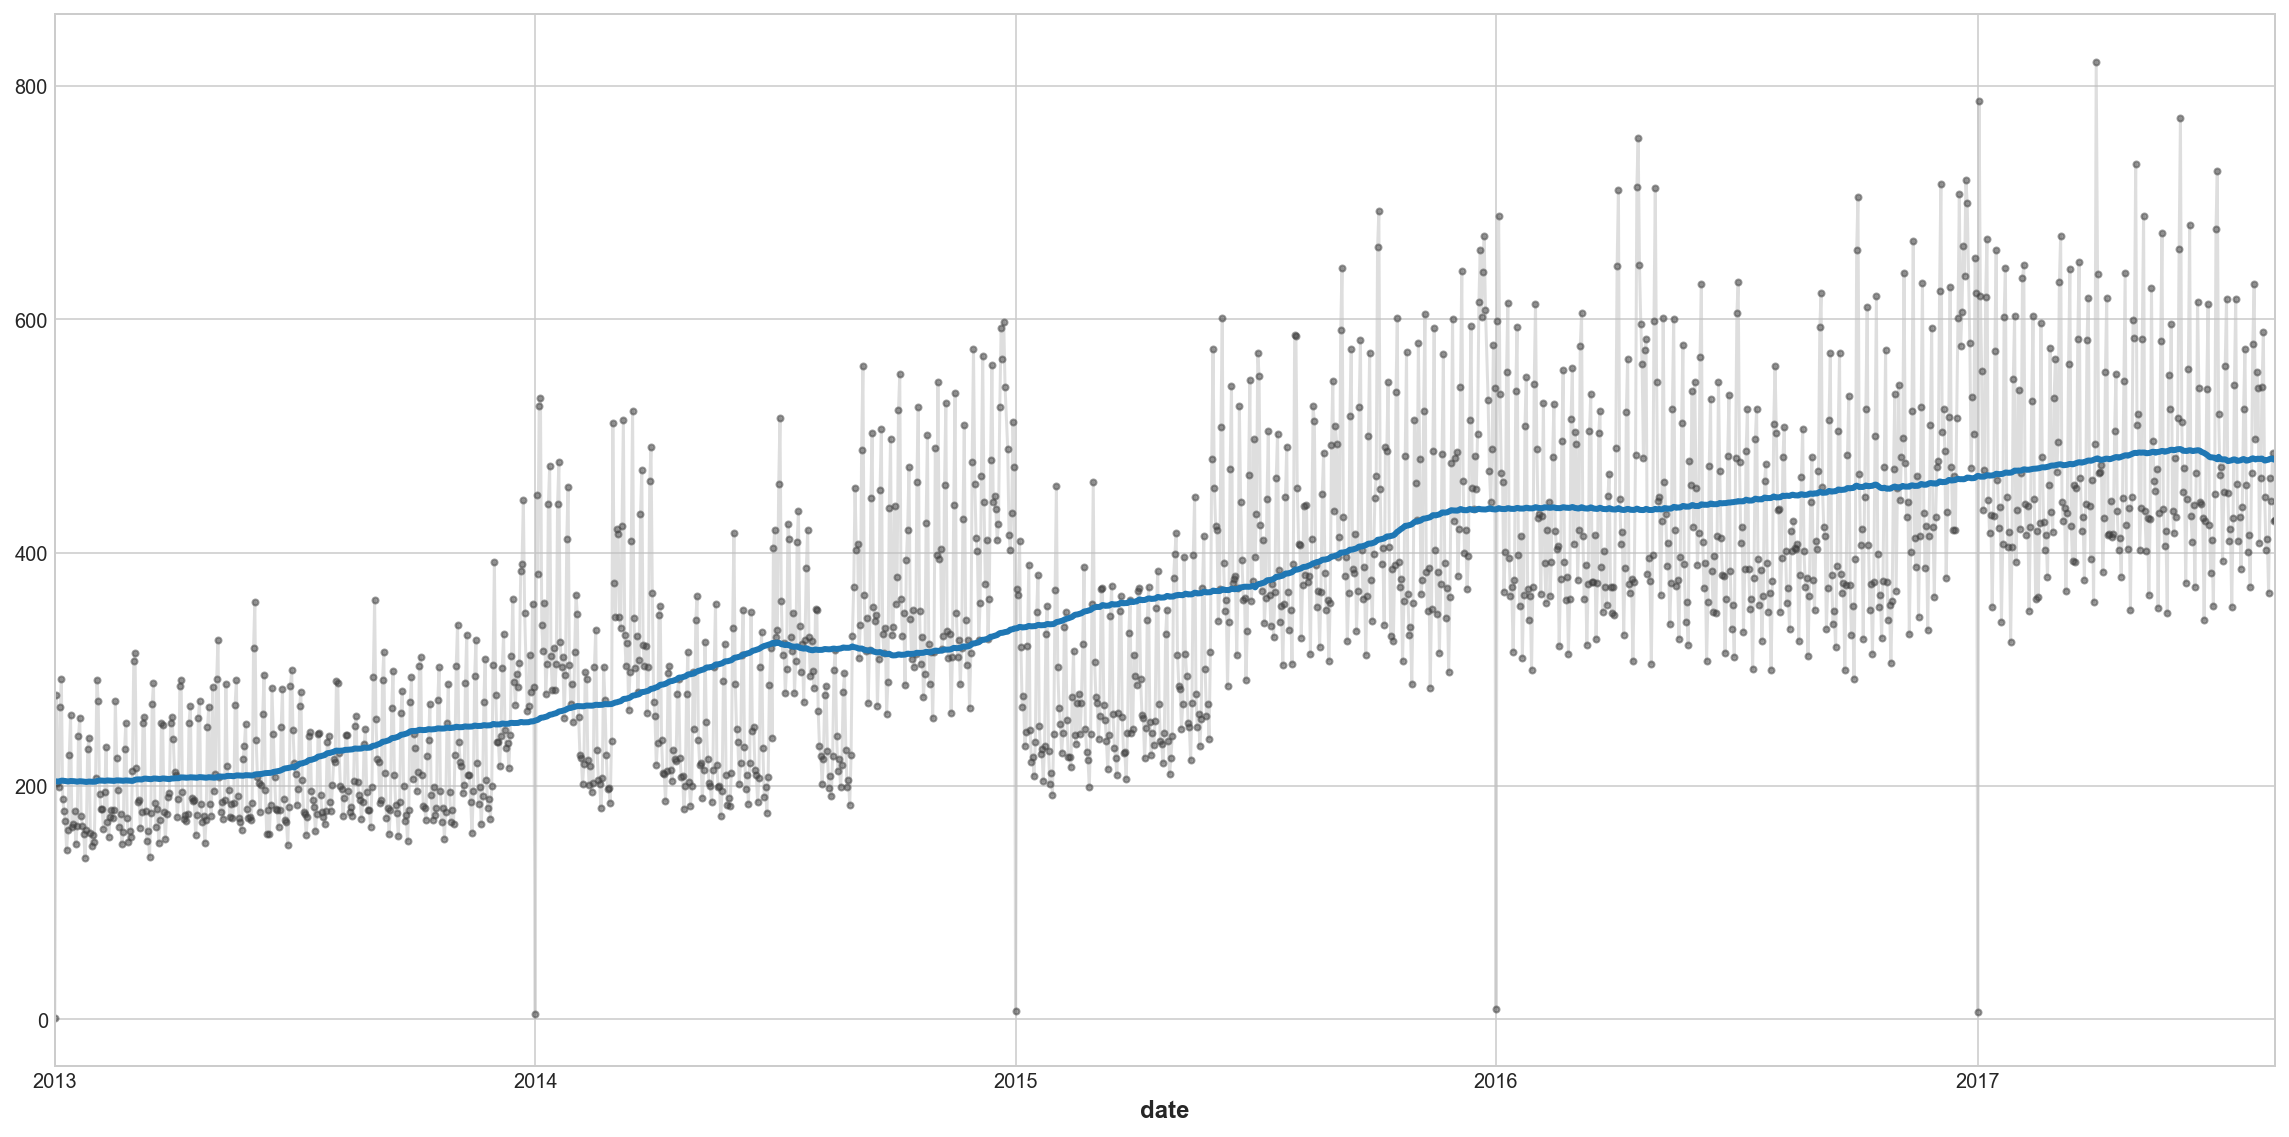

In [58]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

### 3) Crie uma feature de tendência

Use o método DeterministicProcess para criar uma feature de tendência de ordem cúbica. Também crie uma feature de previsão para 90 dias.

In [59]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()    # o target

dp = DeterministicProcess(
    index=y.index,
    constant=False,
    order=3,
    drop=True,
)

# Criando a feature com as datas do y
X = dp.in_sample()

# Criando a feature de forecast para os 90 dias
X_fore = dp.out_of_sample(steps=90)

Podemos ver o plot do resultado rodando a célula abaixo.

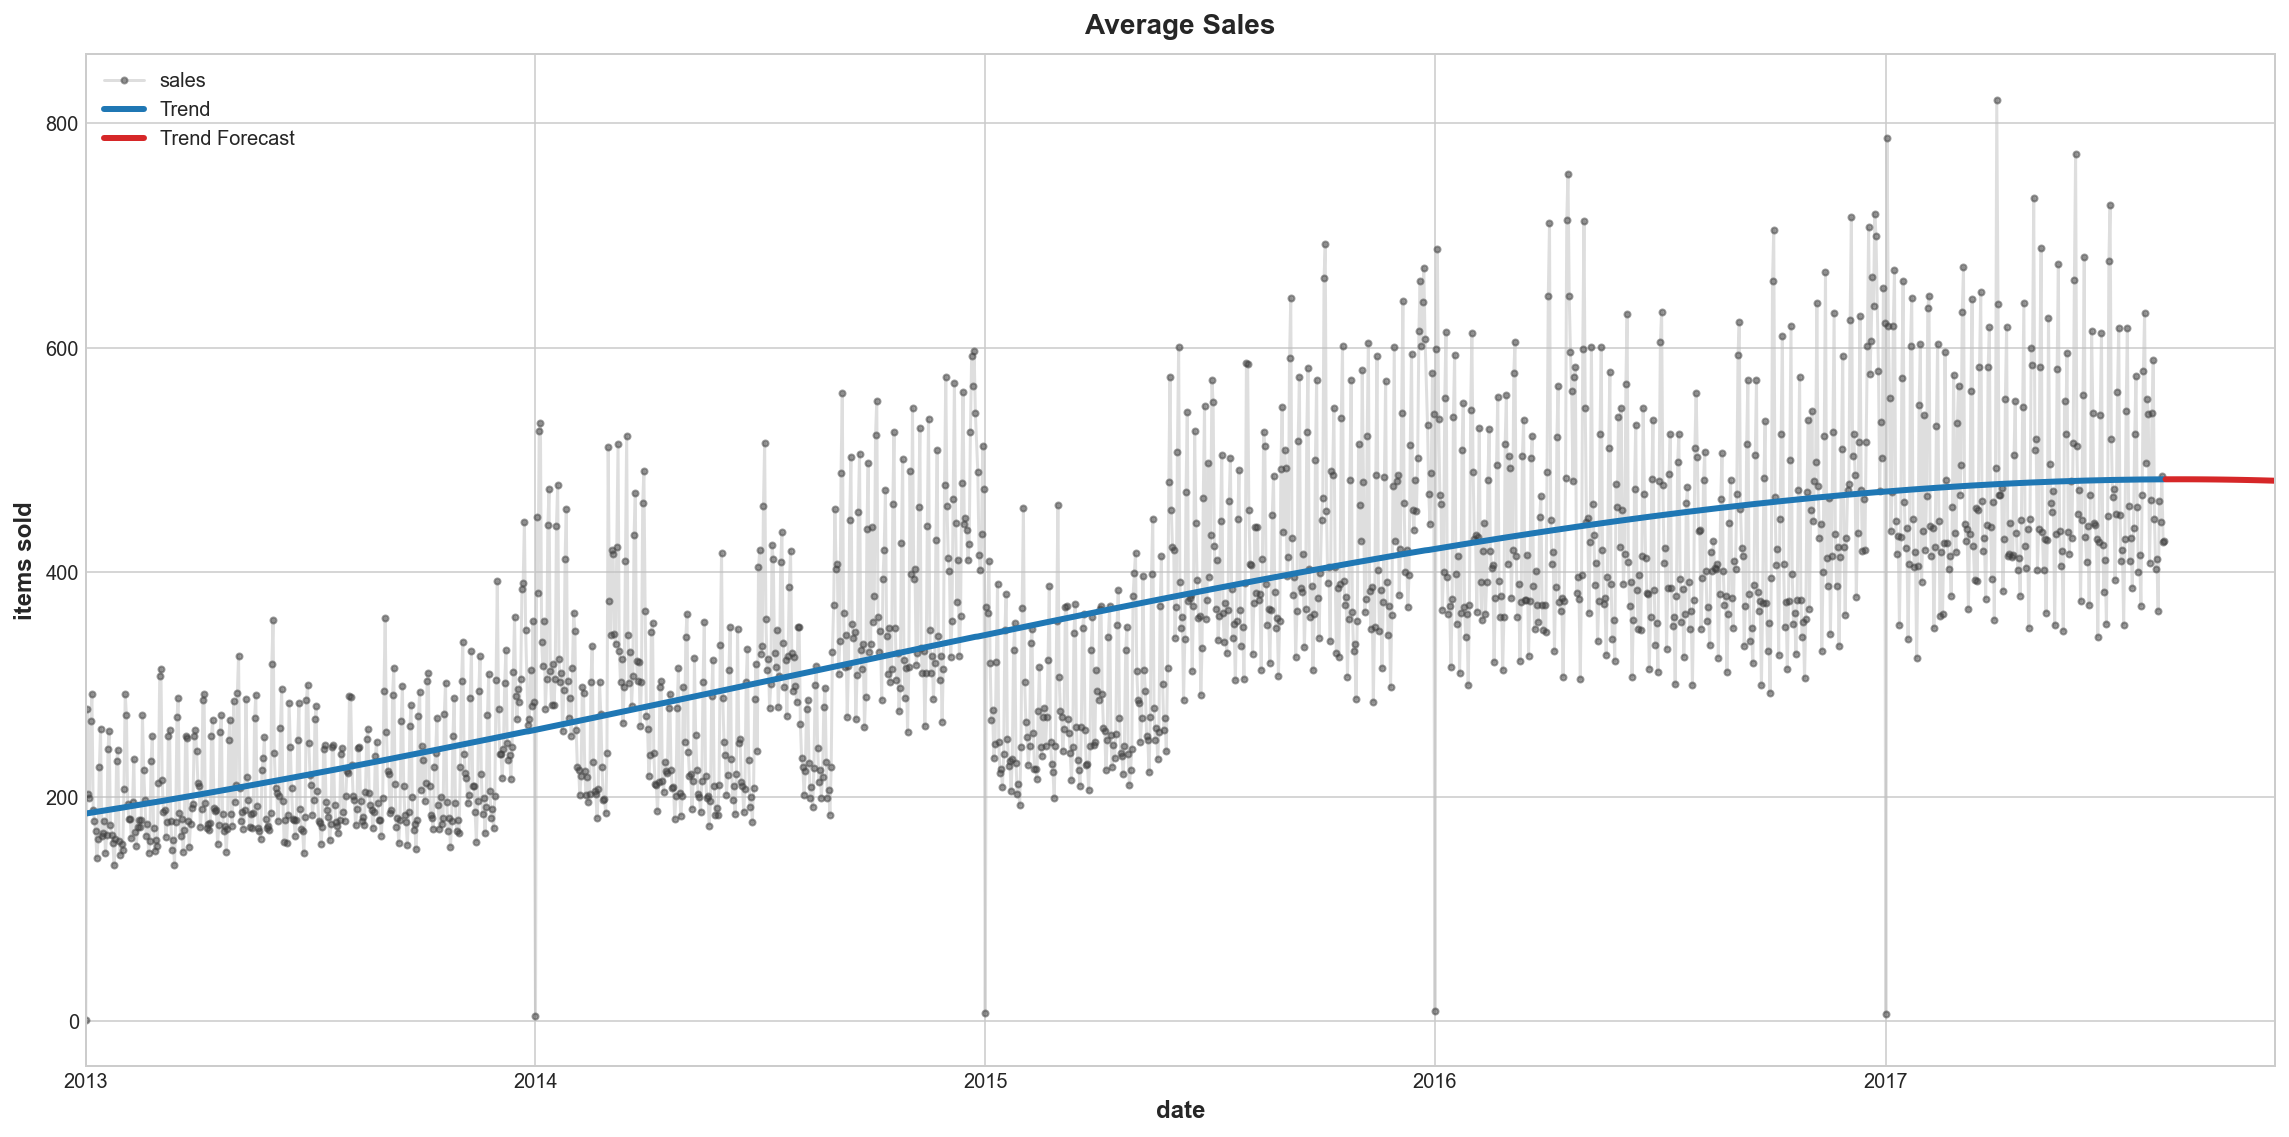

In [60]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3')
ax.legend()
plt.show()

Um jeito mais complicado de fit tendências é aumentar a ordem do polinômio. To conseguir um melhor fit sobre a tendência de Store Sales vamos tentar usa um polinômio de ordem 11.

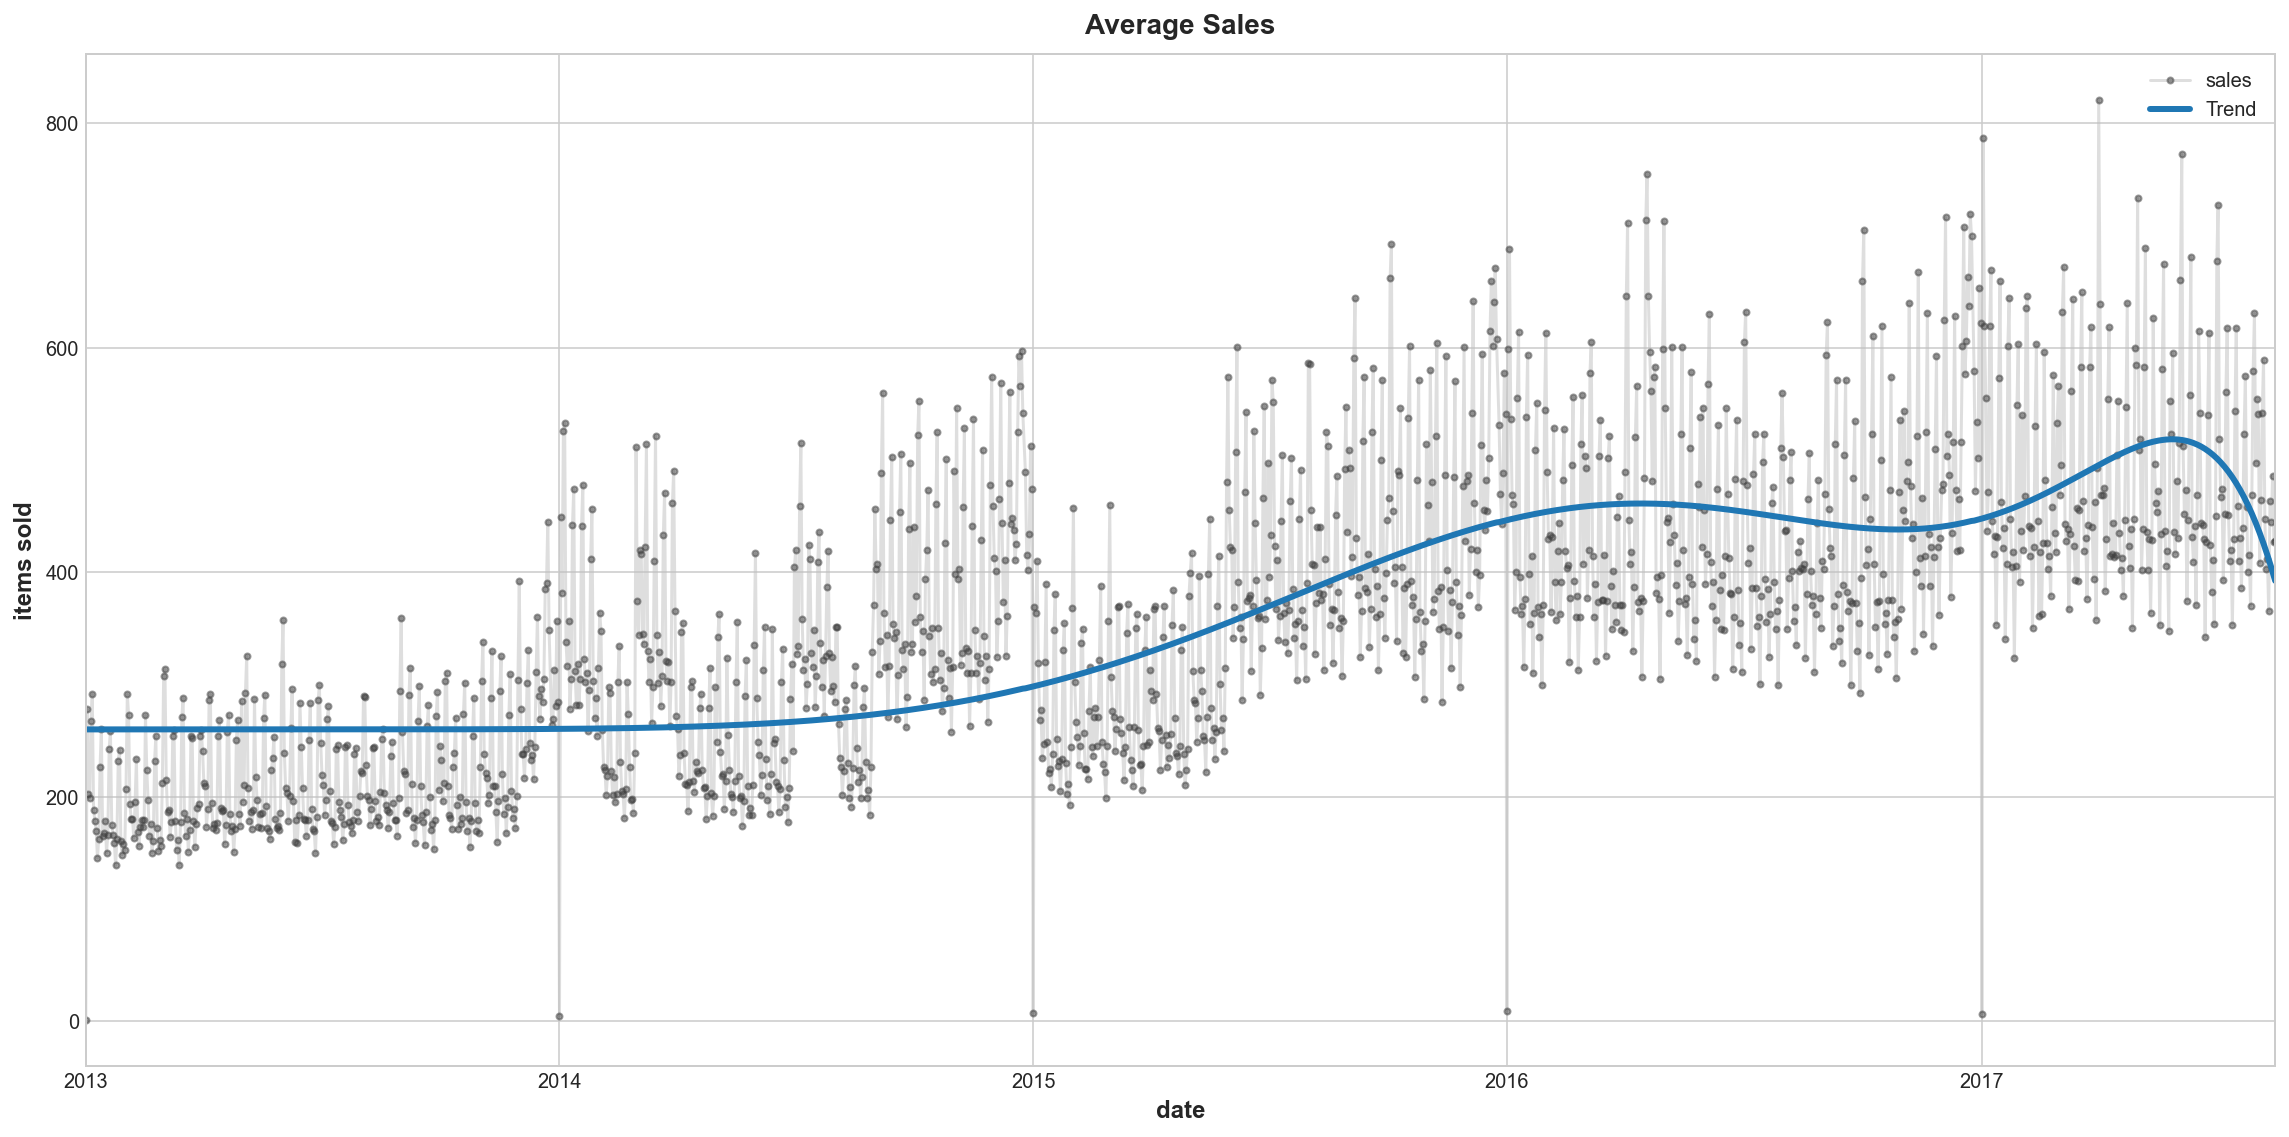

In [61]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=y.index,
    order=11
)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0')
ax.legend()
plt.show()

### 4) Entendendo o risco de previsões com polinômios de ordem elevada

Polinônios de ordem elevada geralmente não são as melhores opeções para previsões. Pode imaginar porque?

R: Uma ordem polinomial de 11 pode incluir termos como t ** 11. Termos como este tendem a divergir rapidamente fora do período de treinamento, fazendo as previsões bastante sem confiança.

Rode a celula abaixo para ver a mesma previsão de 90 dias usando a ordem polinomial de 11. Isso confirma nossa intuição?

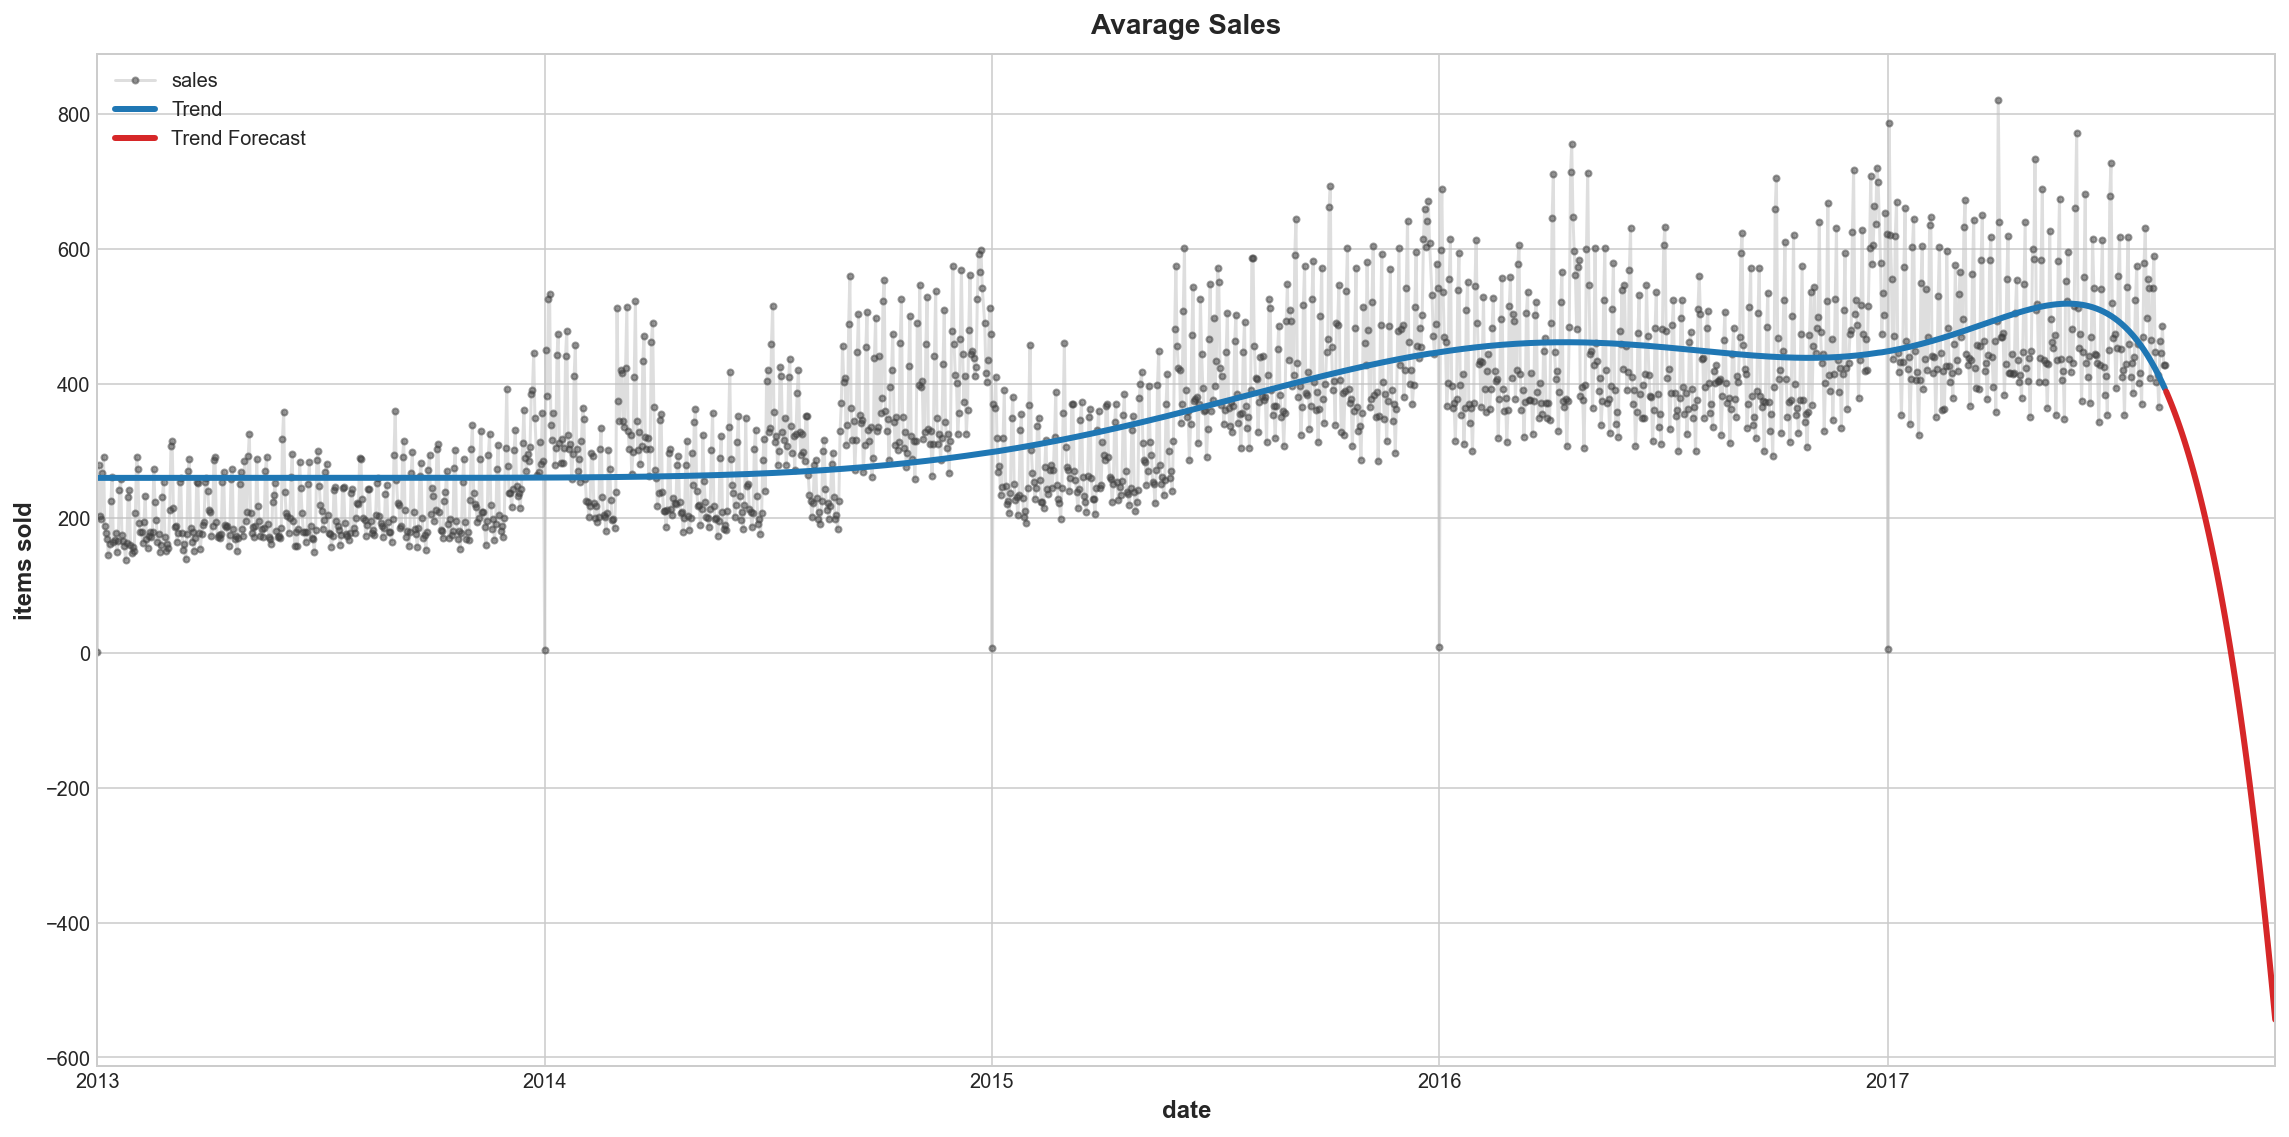

In [62]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title='Avarage Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3')
ax.legend()
plt.show()

### Encaixe uma tendência com splines

Splines são uma boa alternativa para polinômios quando queremos fitar uma tendência. O algoritmo Multivariate Adaptative Regression Splines (MARS) dentro da lib pyearth é poderoso e fácil de utilizar. Possui muitos hiper parâmetros que podemos investivar.

In [51]:
from pyearth import Earth

# Target and features are the same as before
y = average_sales.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

ModuleNotFoundError: No module named 'pyearth'

### Sazonalidade (Seasonality)

Criar indicadores e features Fourier para capturar alteração no período

**O que é sazonalidade?**

Falamos que uma série temporal exibe uma sazonalidade quando há uma alteração regular periódica na média da série. Alterações sazonais geralmente seguem o calendário ou o relógio. Repetições no dia, na semana, no ano são comuns. Sazonalidade é mais comum driveada por ciclos naturais do mundo sobre os dias, anos, ou convenções de comportamento social em torno dos tempos e datas.

<center><img src= https://i.imgur.com/ViYbSxS.png/>

Vamos aprender dois tipos de features para o modelo sazonal. O primeiro tipo, indicadores, são melhores para temporadas com poucas observações, como temporada semanal de observações diárias. O segundo tipo, feature fourier, é melhor para temporadas com mais observações, como temporadas anuais de observações diárias.

**Plots Sazonal e Indicadores Sazonal**

assim como plotamos a média móvel para descobrir a tendência numa série, podemos usar o plot sazonal para descobrir padrões sazonais.

O plot sazonal mostra seguimentos da série temporal plotado em um período comum, o período é a sazonalidade que se deseja observar. A figura abaixo mostra o plot sazonal de visualizações diárias de um artigo do wikipedia sobre trigonometria. Visualizações diárias plotadas sobre o período comum semana.

<center><img src= https://i.imgur.com/bd7D4NJ.png/>

**Indicadores Sazonais**

Indicadores Sazonais são features binárias que representam diferentes sazonais no nível da série temporal. Indicadores sazonais são o que você visualiza se tratar um período sazonal como uma feature categórica e aplicar um enconding one-hot.

Por codificação one-hot os dias da semana, podemos ter indicadores semanal. Criando um indicador semanal para a série do artigo Trigonometria nos dará 6 novas dummy features. (Regressão Linear funciona melhor se droparmos um indicador. Escolhemos a segunda (monday) do frame abaixo)

| Date |	Tuesday |	Wednesday |	Thursday |	Friday |	Saturday |	Sunday |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|2016-01-04 |	0.0 |	0.0 |	0.0 |	0.0 |	0.0 |	0.0 |
|2016-01-05 |	1.0 |	0.0 |	0.0 |	0.0 |	0.0 |	0.0 |
|2016-01-06 |	0.0 |	1.0 |	0.0 |	0.0 |	0.0 |	0.0 |
|2016-01-07 |	0.0 |	0.0 |	1.0 |	0.0 |	0.0 |	0.0 |
|2016-01-08 |	0.0 |	0.0 |	0.0 |	1.0 |	0.0 |	0.0 |
|2016-01-09 |	0.0 |	0.0 |	0.0 |	0.0 |	1.0 |	0.0 |
|2016-01-10 |	0.0 |	0.0 |	0.0 |	0.0 |	0.0 |	1.0 |
|2016-01-11 |	0.0 |	0.0 |	0.0 |	0.0 |	0.0 |	0.0 |
|... |	... |	... |	... |	... |	... |	... |

Adicionando indicadores sazonais aos dados de treinamento ajuda o modelo a distinguir médias em um período sazonal.

<center><img src= https://i.imgur.com/hIlF5j5.png/>

Indicadores agem como uma chave On/Off. A qualquer tempo, um desses indicadores terá o valor 1 (On). A regressão linear irá aprender um valor de 2379 para segunda-feira (monday) e ajusta o valor conforme o indicador para aquele dia se torna 1 (On). O reste é zero e não aparece.

Vamos olhar o plot para temporada anual no artigo Trigonometria. Note as repetições de várias frequências: um longo movimento de sube e desce três vezes ao ano. um curto movimento semanal 52 vezes ao ano, e talvez outros.

<center><img src= https://i.imgur.com/NJcaEdI.png/>

nessas frequências com a temporada que nos tentamos capturar as features de fourier. A ideia é incluir aos dados de treinamento curvas periódicas com a mesma frequência da temporada que estamos tentando modelar. As curvas que usamos são essas funções de seno e cosseno da trigonometria.

**Features de Fourrier** são curvas pares de seno e coseno, um par para cada frequência potencial na temporada, iniciando pela mais longa. Pares de Fourier modelam a sazonalidade anual onde temos: um por ano, dois por ano e três por ano e por ai em diante.

<center><img src= https://i.imgur.com/bKOjdU7.png/>

se nos adicionarmos um set dessas curvas seno e cosseno aos nossos dados de treinamento, o algorítmo de regressão linear irá entender os pesos que se encaixam na componente sazonal do target da série. A figura abaixo ilustra como a regressão linear usa 4 pares de fourier para modelar a sazonalidade anual da série Wiki Trigonometry.

<center><img src= https://i.imgur.com/mijPhko.png/>

Note que apenas precisamos de 8 features (4 seno / pares cosseno) para conseguir uma boa estimativa da sazonalidade anual. Compare isso com o método indicador sazonal, o qual será requerido centenas de features (uma para cada dia do ano). Modelando apenas o "efeito principal" da sazonalidade com as features de fourier, iremos usualmente adicionar menos features em nossos dados de treinamento, o que significa redizur o tempo computacional e menos risco de overfiting.

**Escolhendo a feature de fourier com o Periodograma**

Quantos pares de fourier serão necessários incluir em nosso set de features? Podemos responder essa pergunta com o Periodograma. O Periodograma nos diz a força das frequências na série temporal. Especificamente, o valor no eixo y do gráfico (a ** 2 + ** 2) / 2, onde 'a' e 'b' são coeficiêntes do seno e cosseno na frequência (como nas componetes de fourier plotadas acima)

<center><img src= https://i.imgur.com/PK6WEe3.png/>

Da esquerda para direita, o periodograma tem uma queda no período de quarto (quartely) 4 vezes ao ano. É por isso que escolhemos quatro pares de fourier para modelar a temporada anual. A frequência semanal são ignoradas desde que são melhores modeladas por indicadores.

**Computação de Feature de Fourier (opcional)**

Sabendo como as features de fourier são computadas, não é essencial utilizá-las. mas se vermos os detalhes as coisas podem ficar mais claras, a célula abaixo ilustra como o set de feature fourier pode ser derivado do índice de uma série temporal. (vamos usar a função da lib statsmodels para nossa aplicação)

In [2]:
import numpy as pd

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1/freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.Dataframe(features, index=index)

# Computar features de fourier a 4a ordem (8 novas features) para a série y
# com obervações diárias e sazonalidade anual:
# fourier_features(y, freq=365.25, order=4)

**Exemplo - Tunnel Traffic**

Vamos continuar uma vez mais com o dataset Tunnel Traffic. A célula abaixo carrega os dados e define duas funções: seasonal_plot e plot_periodogram.

In [13]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# setar matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True, figsize=(11,5))
plt.rc(
    'axes', 
    labelweight='bold',
    labelsize='large', 
    titleweight='bold', 
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color='0.75',
    style='.-',
    markeredgecolor='0.25',
    markerfacecolor='0.25',
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# anotações: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_ylabel('Variance')
    ax.set_title('Periodogram')
    return ax

data_dir = Path('Time_Series/archive-2/')
tunnel = pd.read_csv(data_dir / 'tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day').to_period('D')

Vamos olhar o plot sazonal sobre a semana e sobre o ano

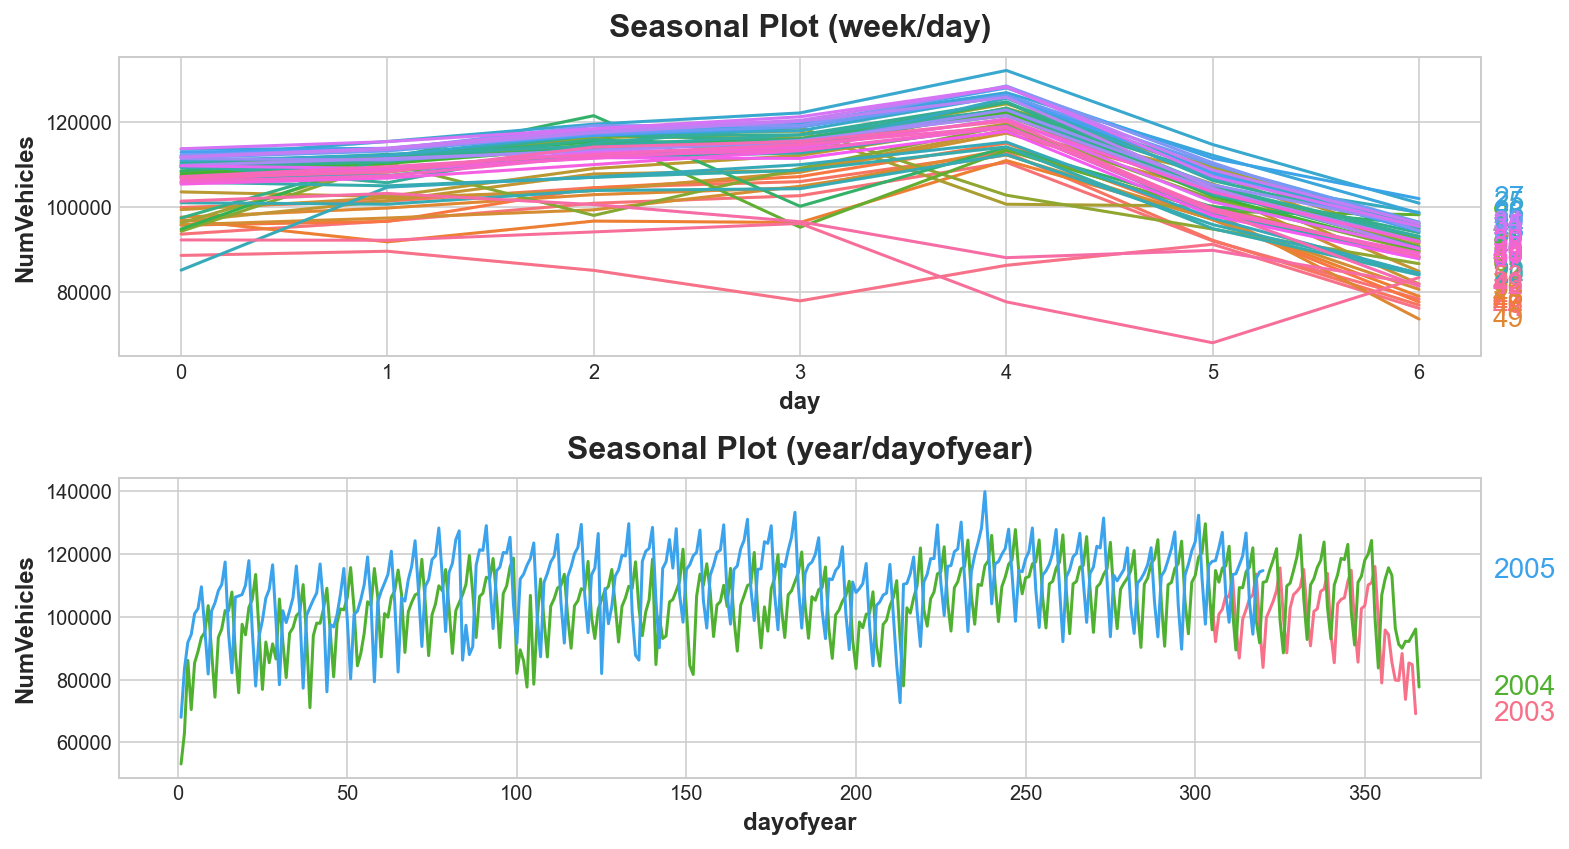

In [14]:
X = tunnel.copy()

# dias da semana
X['day'] = X.index.dayofweek # eixo x (freq)
X['week'] = X.index.week # o período sazonal (período)

# dias no ano
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y='NumVehicles', period='week', freq='day', ax=ax0)
seasonal_plot(X, y='NumVehicles', period='year', freq='dayofyear', ax=ax1)
plt.show()

Agora vamos observar o periodograma

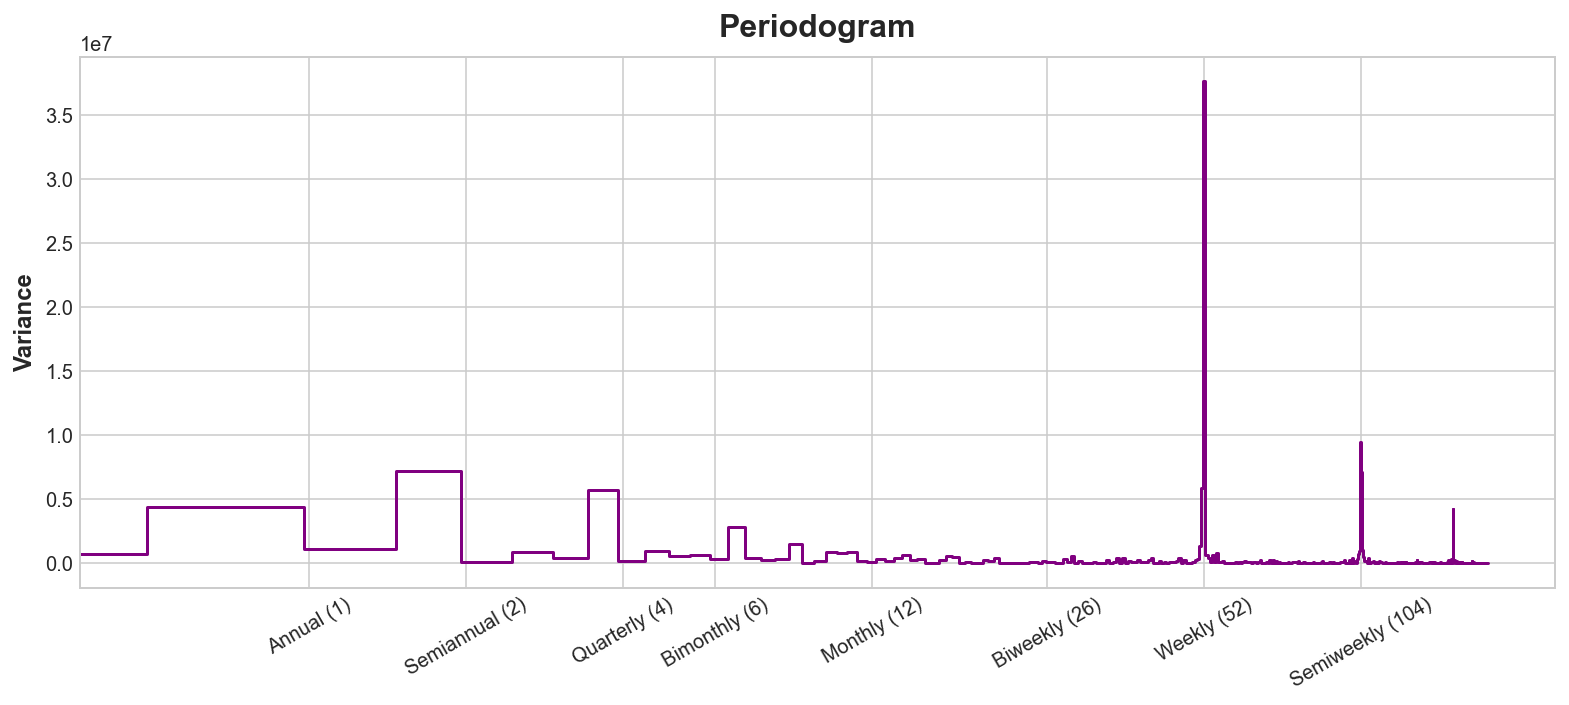

In [16]:
plot_periodogram(tunnel.NumVehicles)
plt.show()

O periodograma concorda com o plot sazonal acima: uma forte sazonalidade semanal e uma fraca sazonalidade anual. A sazonalidade semanal iremos modelar com indicadores e sazonalidade anual com as features de fourier. Da direita para esquerda, o periodograma cai entre Biomonthly (6) e Monthly (12), então iremos usar 10 pares fourier.

Vamos criar as features sazonais usando o DeterministicProcess, o mesmo utilitário que usamos na lição 2 para criar as trend freatures. Para usar dois períodos (semanal e anual), vamos precisar instanciar uma como 'additional term'

In [18]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq='A', order=10) # 10 pares seno / cosseno para sazonalidade anual

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,                  # dummy feature para bias (y-intercept)
    order=1,                        # tendência (ordem 1 significa linear)
    seasonal=True,                  # sazonalidade semanal (indicador)
    additional_terms=[fourier],     # sazonalidade anual (fourier)
    drop=True,                      # dropa terms para evitar colinearidade
)

X = dp.in_sample()      # cria features para datas no tunnel.index

Com nosso set de features criados, estamos prontos para fittar o modelo e fazer predições. Iremos adicionar uma previsão de 90 dias para vermos como nosso modelo extrapola além dos dados de treinamento. O código abaixo é o mesmo das lições anteriores.

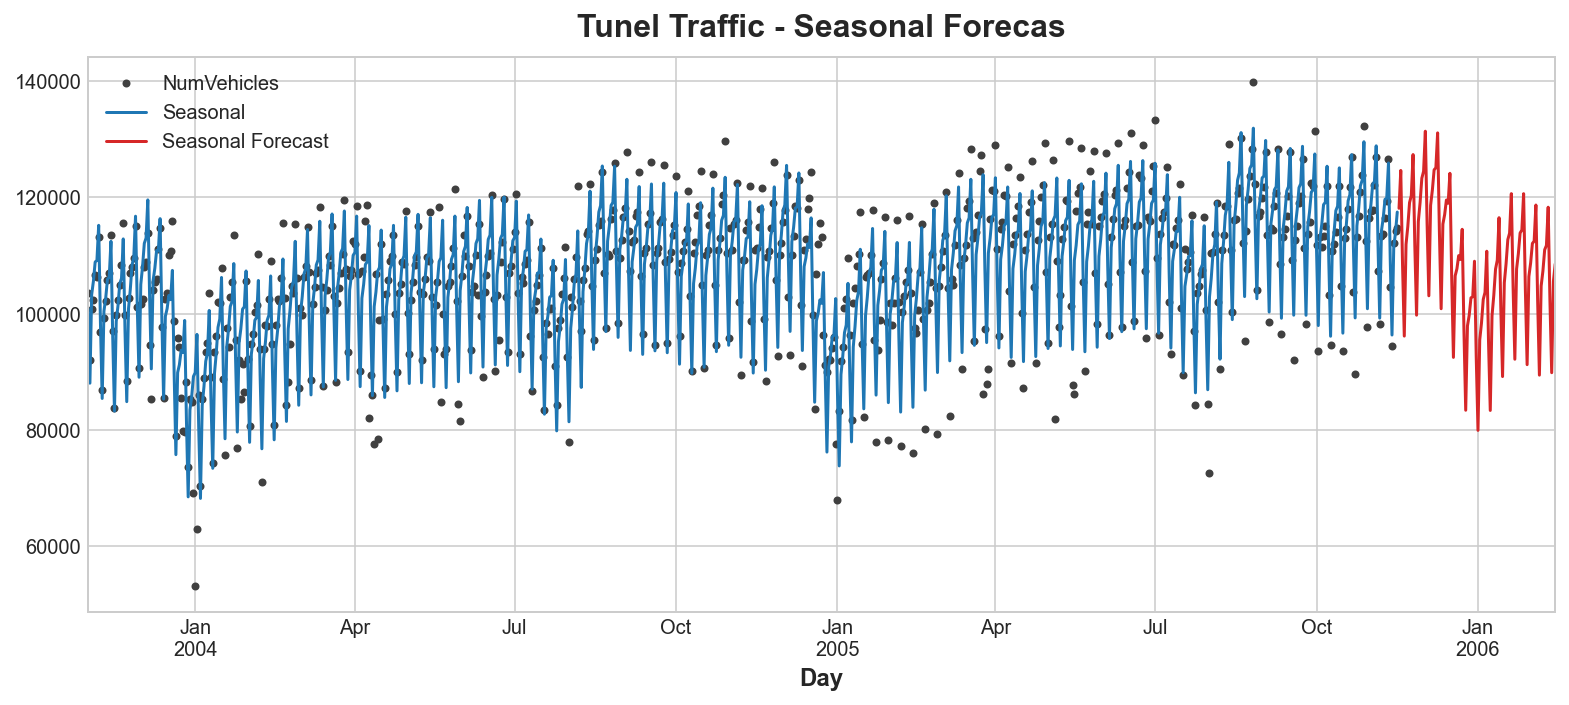

In [22]:
y = tunnel['NumVehicles']

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title='Tunel Traffic - Seasonal Forecas')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax = y_fore.plot(ax=ax, label='Seasonal Forecast', color='C3')
_ = ax.legend()
plt.show()

### Exercício

Rode a célula abaixo para preparar o ambiente

In [23]:
# Setup notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


comp_dir = Path('Time_Series/store-sales-time-series-forecasting/')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

Examente o plot sazonal seguinte:

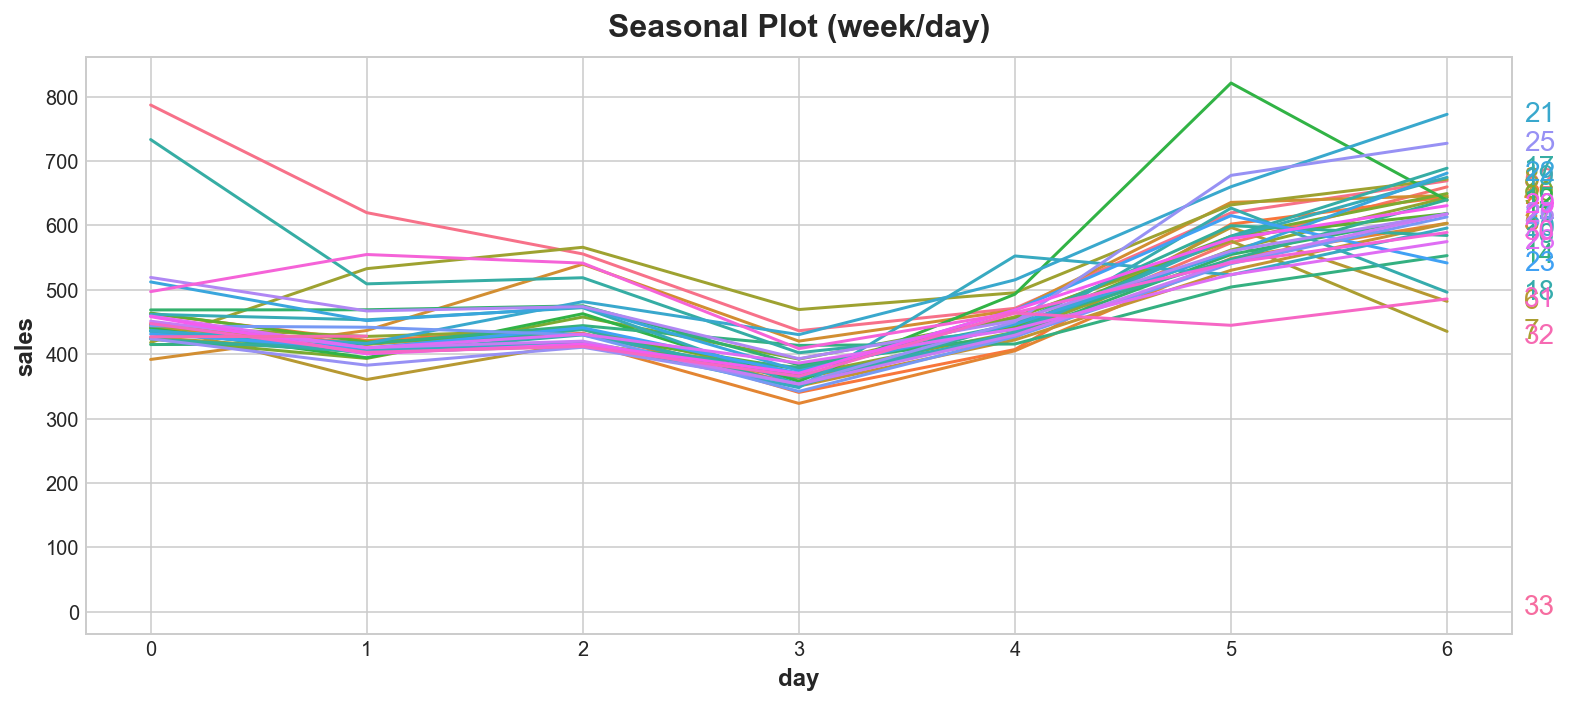

In [25]:
X = average_sales.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day')
plt.show()

e também o periodograma

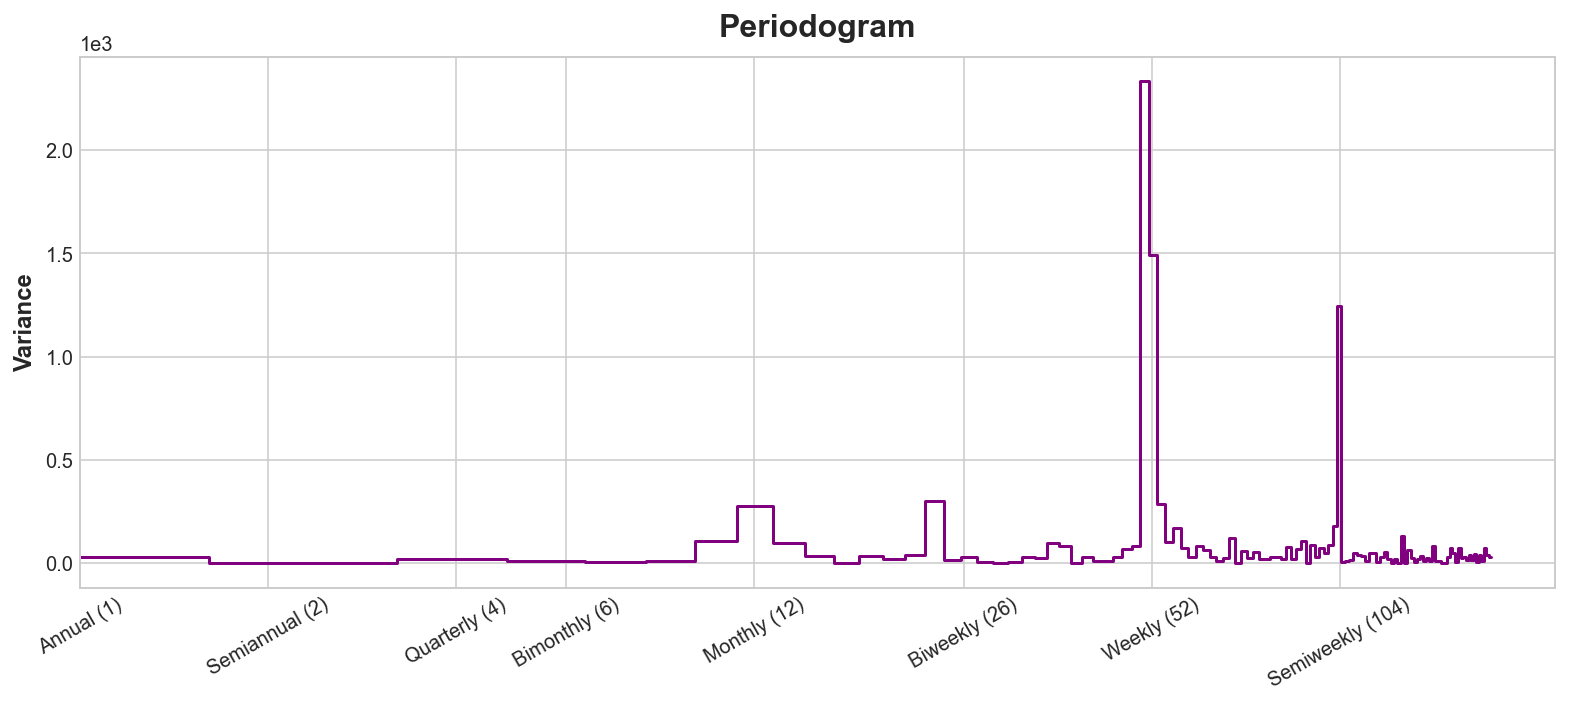

In [26]:
plot_periodogram(average_sales)
plt.show()

### 1) Determine a Sazonalidade

Que tipo de sasonalidade você pode ver evidência?

R: Ambos plot sazonal e periodograma sugerem forte sazonalidade semanal. Do periodograma, aparentemente podemos ter até as componentes monthly e biweekly bem. Em fato as notas do dataset Store Sales diz que os salários do setor público são pagos quinzenalmente, no 15o e último dia do mês - uma possível origem para essas temporadas.

### 2) Crie features sazonais

Use o DeterministicProcess e CalendarFourier para criar:
* indicadores semanais das sazonalidades e
* Feature fourier de ordem 4 para sazonalidades mensais

In [27]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4) # 'M' para sazonalidade mensal
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

Rode a célula abaixo para fittar o modelo sazonal

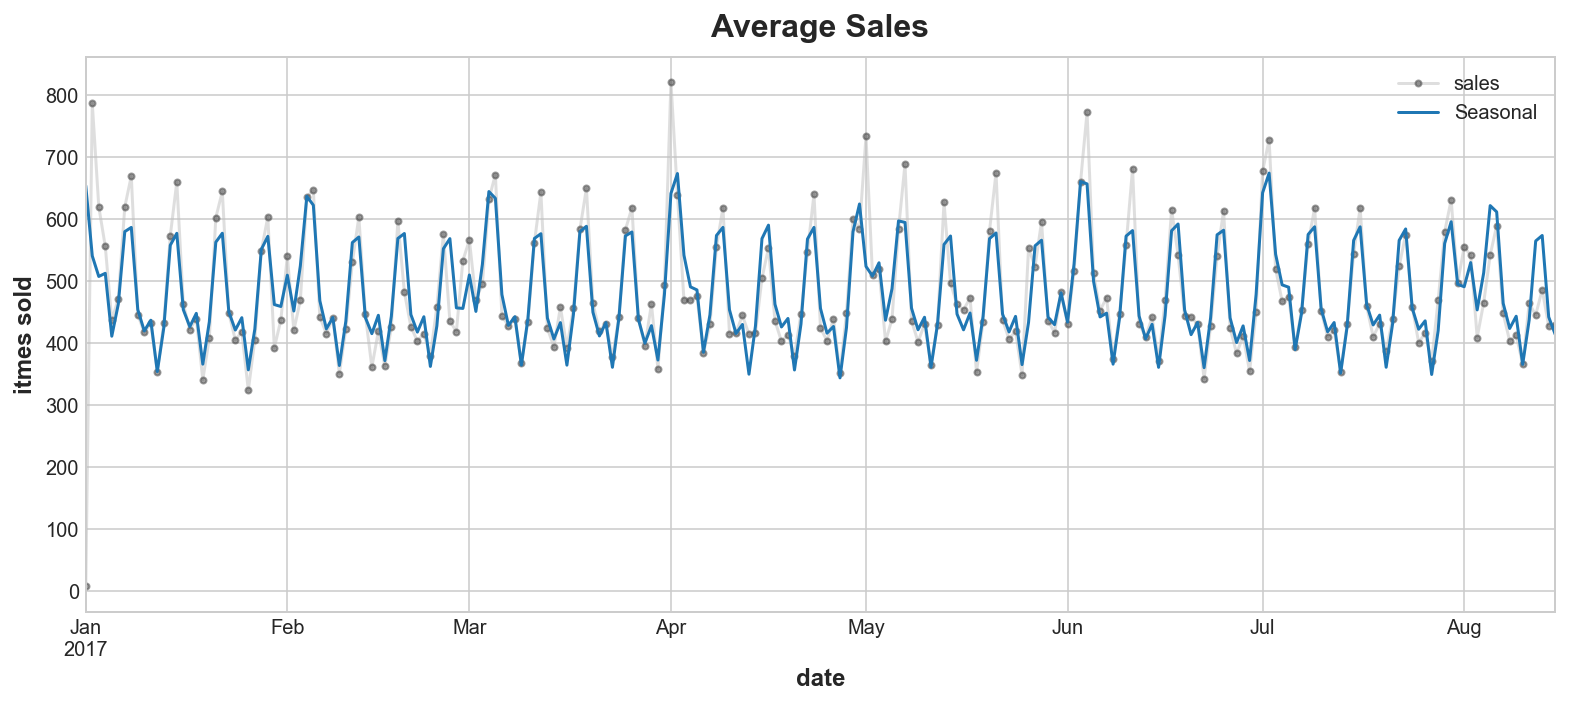

In [28]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='itmes sold')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax.legend()
plt.show()

Removendo da série a tendência e a temporada da série, chamamos de detreding ou deseasonaling

Olhe o periodograma da série deseasonalizada.

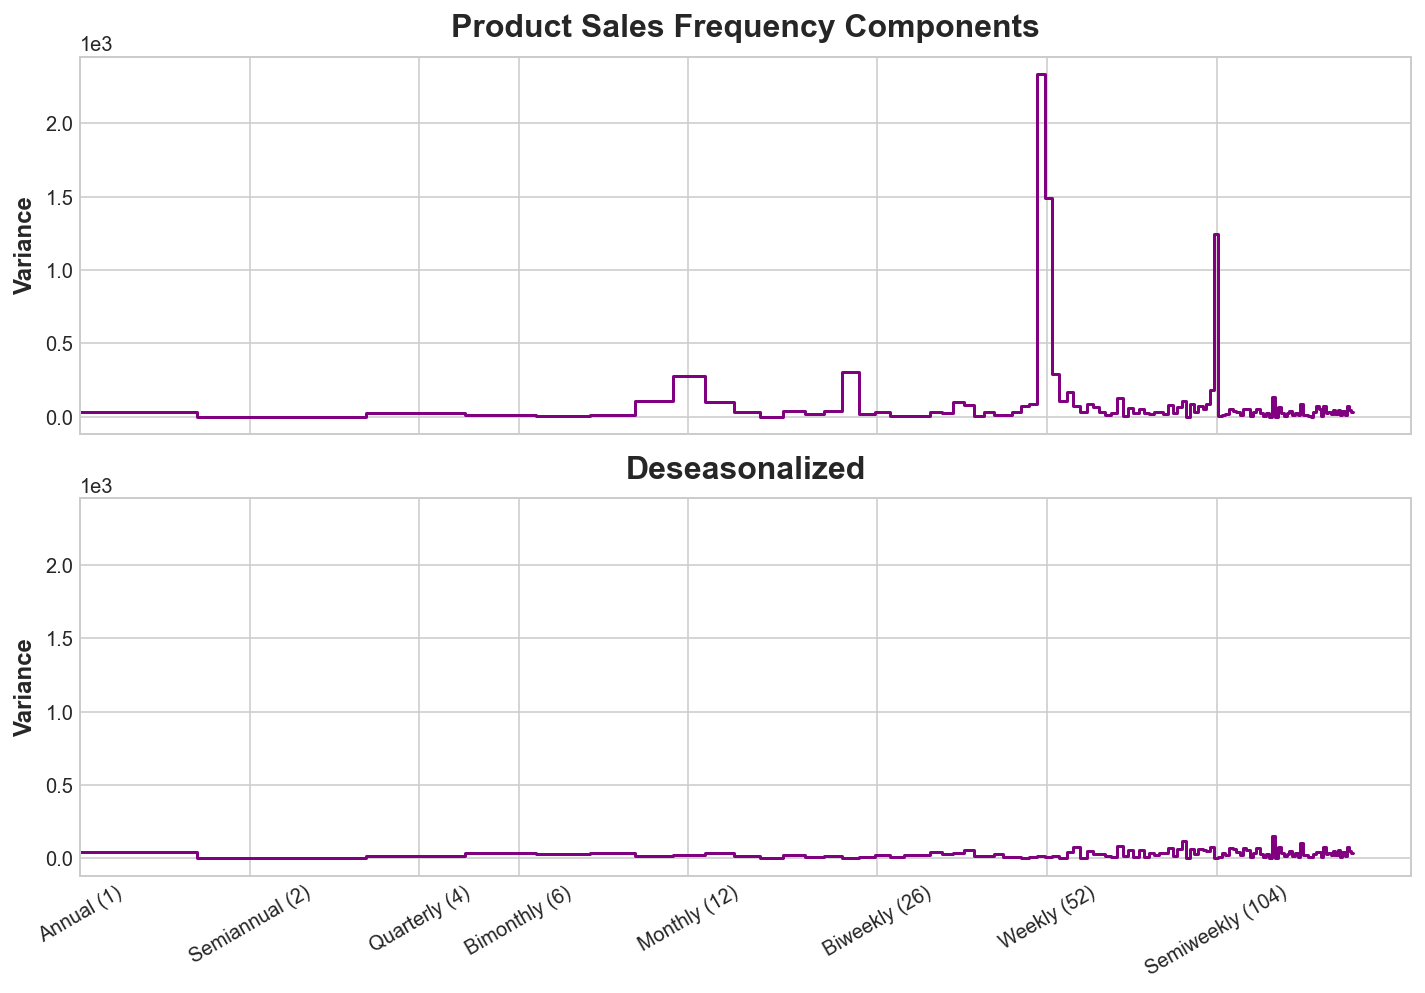

In [29]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title('Product Sales Frequency Components')
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title('Deseasonalized')
plt.show()

### 3) Verificando a sazonalidade remanecente

Baseado nesse periodograma, como efetivamente o nosso modelo aparenta capturar a sazonalidade de Average Sales? O periodograma concorda com o plot do tempo de série deseazonalizada?

R: O periodograma falta de valores grandes. Comparando com o periodograma da série original, podemos ver que o nosso modelo conseguiu capturar a variação sazonal de Average Sales.

O dataset Stores Sales inclui uma tabela Ecuadoriam Holidays

In [32]:
# Ferioados nacionais e regionais no set de treino
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017': '2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

description
date                                              
2017-01-01                      Primer dia del ano
2017-01-02             Traslado Primer dia del ano
2017-02-27                                Carnaval
2017-02-28                                Carnaval
2017-04-01           Provincializacion de Cotopaxi
2017-04-14                           Viernes Santo
2017-05-01                         Dia del Trabajo
2017-05-13                       Dia de la Madre-1
2017-05-14                         Dia de la Madre
2017-05-24                    Batalla de Pichincha
2017-05-26           Traslado Batalla de Pichincha
2017-06-25           Provincializacion de Imbabura
2017-08-10           Primer Grito de Independencia
2017-08-11  Traslado Primer Grito de Independencia

Do plot de Average Sales deseasonalizado, esses ferioados aparentam ter um forte poder preditivo.

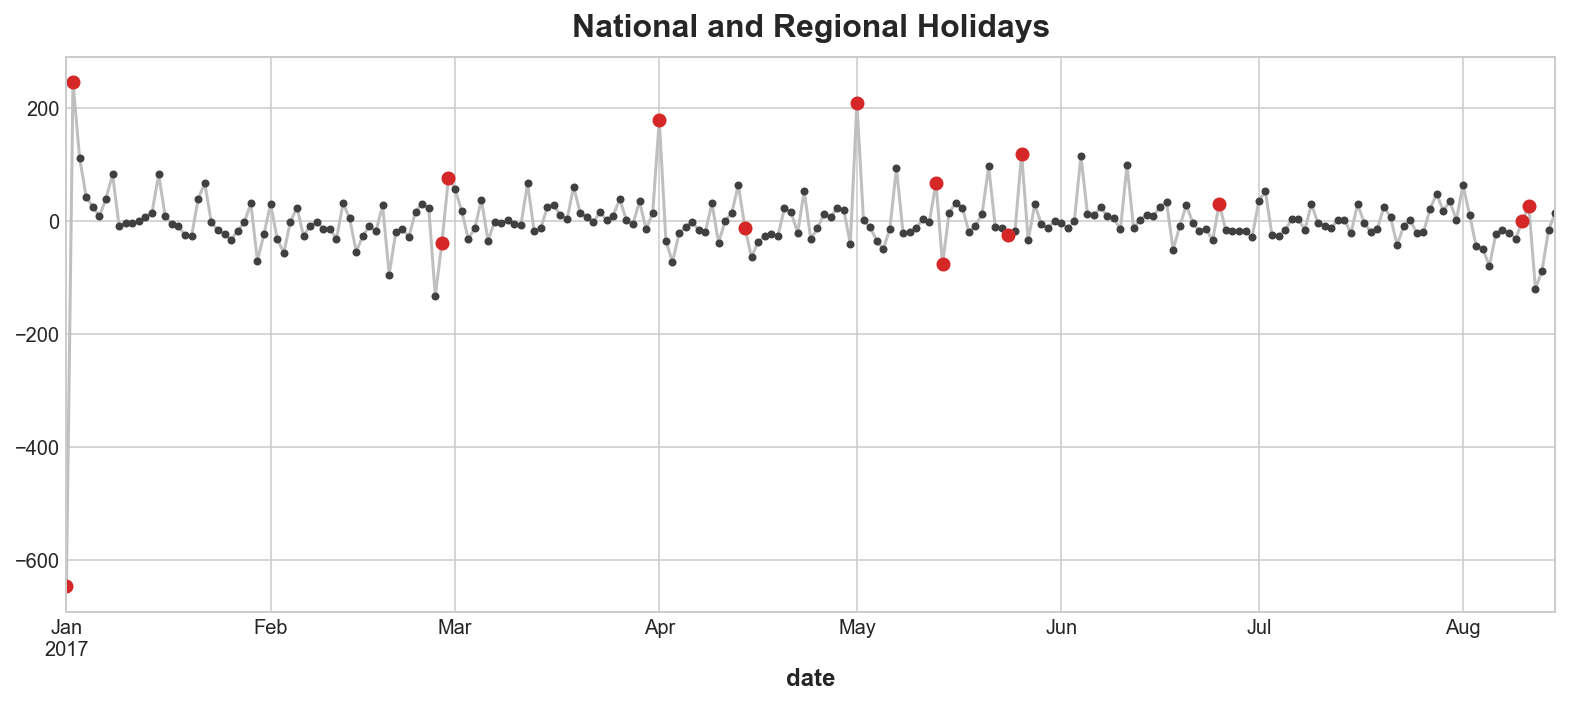

In [34]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays')
plt.show()

### 4) Crie features holiday

Que tipo de feature podemos criar para ajudar o modelo fazer uso dessa informação? 

In [35]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

# Pandas solution
#X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

Use a célula abaixo para fittar o modelo sazonal com adição dos feriádos. Os valores fittados parecem ter melhorado?

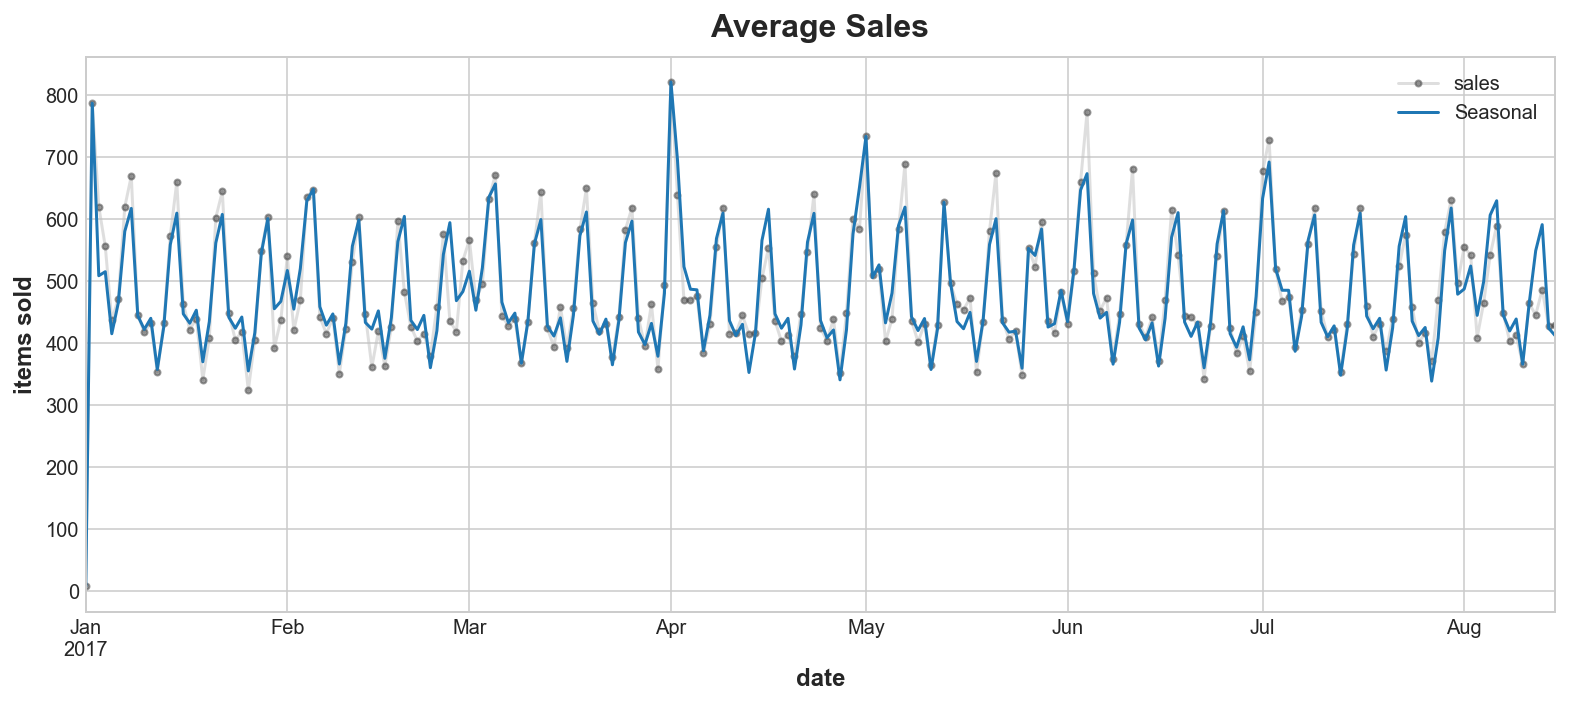

In [36]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

### Série Temporal como uma feature

Previsão do futuro de uma lag do passado embarcada.

**O que é uma dependência serial**?

Nas lições anteriores investigamos propriedades das séries temporais que são facilmente modeladas como propriedades dependentes do tempo, com features que derivamos diretamente do índice temporal. Algumas propriedades da série temporal, no entando, podem ser modeladas como propriedades dependetes seriais, usando como valores features de valores passados para o target da serie. A estrutura dessas séries temporais podem não parecer de um plot sobre o tempo, plotadas contra valores do passado, no entanto, a estrutura se torna clara, como podemos ver nas figuras abaixo

<center><img src= https://i.imgur.com/X0sSnwp.png/>

Essas duas séries possuem dependência serial, mas não dependência temporal. Os pontos a direita contém coordenadas ( valores no tempo t-1, valores em tempo t)

com a tendência e sazonalidade, nos treinamos modelos e fittamos curvas para plotar como essas figuras a esquerda das imagens acima. Os modelos que nos aprendemos eram dependentes temporais para aprendizado. O objetivo nessa lição é treinar modelos que fittem curvas para plotar como os da direta. Nos precisamos deles para aprender a dependência serial.

**Cliclos**

Uma maneira comum especial para uma dependente serial se manifestar é em Ciclos. Ciclos são padrões de crescimento ou caimento na série temporal associado a quanto um valor na série no tempo é dependente de valores no passado, mas sem necessariamente ser no passo temporal. Comportamento cíclico é uma característica de sistemas que pode afetados por si mesmo ou cujas reações persistem pelo tempo. Economias, epidamias, população animal, erupções vulcânicas e fenômenos naturais similares pode apresentar comportamento cíclico.

<center><img src= https://i.imgur.com/CC3TkAf.png/>

Quatro séries temporais com comportamento cíclico

O que distinguie o comportamento cíclico de um sazonal é que os ciclos não necessariamente são dependentes do tempo e os sazonais sim. O que acontece em um ciclo é menos sobre uma data em particular de ocorrência e mais sobre o que acontece no passado recente. A última independente relativa do tempo significa que o comportamento do ciclo pode ser mais irregular que sazonal.

**Séries Lagged e Lag Plots**

Para investigar a dependência serial (como ciclos) numa série temporal, nos precisamos criar cópias com atrasos (lagged) da série. Lagging em uma série temporal significa mover os valores para frente uma ou mais vezes no passo temporal, ou equivalente, mover o passo de tempo no índice um ou mais vezes. No caso, o efeito é que as observações na lagged série aparecerá como se acontececem atrasadas no tempo.

Isso mostra que a taxa de desemprego mensal no Estados Unidos (y) juntamente com a primeira e segunda lagged series (y_lag_1 e y_lag_2, respectivamente). Note como os valores da série atrasada são movidos para frente no tempo.

In [3]:
import pandas as pd

# Dataset do federal reserve
reserve = pd.read_csv(
    'Time_Series/archive-2/reserve.csv',
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),
})

df.head()

y  y_lag_1  y_lag_2
Date                          
1954-07  5.8      NaN      NaN
1954-08  6.0      5.8      NaN
1954-09  6.1      6.0      5.8
1954-10  5.7      6.1      6.0
1954-11  5.3      5.7      6.1

Atrasando uma série temporal, nos podemos fazer os valores passados parecerem contemporâneos com valores que nos estamos tentando prever (na mesma linha em outras palavras). Isso faz com a lagged serie seja útil como uma feature para modelar uma dependência serial. Para previsões de taxas de desemprego dos Estados Unidos, podemos usar y_lag_1 e y_lag_2 como features para prever o target y. Isso irá prever as taxas futuras de desemprego como uma função da taxa de desemprego em dois meses.

**Lag plots**

A **lag plot** de uma série temporal mostra que os valores plotados sobre os atrasos. A dependência serial de uma série temporal geralmente se torna aparente olhando o lag plot. Nos podemos ver nesse lag plot da taxa de desemprego que existe uma forte e aparente relação linear entre as taxas correntes e as taxas passadas.

<center><img src= https://i.imgur.com/Hvrboya.png/>

Lag plot das taxas de desemprego com indicação de autocorrelação.

A medida mais comum utilizada para medir dependência serial é conhecida como **autocorrelação**, o que simplifica a correlação da série temporal tem com uma de suas lags. Desemprego do US tem uma autocorrelação de 0.99 para lag_1 e 0.98 para lag_2 e assim por diante.

**Escolhendo as lags**

Quando escolhemos as lagas para usar como features, geralmente não útil incluir todas as lags com uma alta correlação. No caso do Desemprego do US, a autacorrelação da lag_2 parece interamente resultar de informações deterioradas da lag_1 -- apenas correlação que é carregada da etapa anterior. Se a lag_2 não contém nada novo, não há razão para incluí-la se já temos a lag_1.

Uma **correlação parcial** nos diz a correlação de uma lag em relação as lags anteriores -- o quanto de "nova" correlação a lag contribui, para dizer. Plotar a autocorrelação parcial pode ajudar a escolher qual lag usar. Na figura abaixo, da lag_1 até lag_6 cai em um intetvalo de "não correlação" (em azul), logo podemos escolher a lag_1 até lag_6 como features para taxa de desemprego dos Estados Unidos. (lag_11 é um falso positivo)

<center><img src= https://i.imgur.com/6nTe94E.png/>

Autocorrelação parcial do Desemprego até a lag_12 com interbalos de 95% de confiança de não correlação

Um plot como o de cima é conhecido como um Correlograma (Correlogram). O Correlograma é para as lag features essencialmente o que o periodograma é para as features Fourier.

Finalmente, nos precisamos estar atentos que a autocorrelação e a autocorrelação parcial são medidas de dependências lineares. Como séries temporais no mundo real geralmente tem uma dependência não linear substancial, é melhor olha a lag plot (ou usar mais medidas de dependências gerais, como informação mútua) quando escolhemos lag features. A série Sunspots tem lags com dependência não linear como nos iremos olha com a autocorrelação.

<center><img src= https://i.imgur.com/Q38UVOu.png/>

Lag plot da série Sunsposts

relacionamentos não lineares como estes pode ser transformados em lineares ou aprendidos por uma algorítmos apropriado.

**Exemplo - Tendências de Gripe**

O dataset Flu Trends contém registros de visitas de médicos para as semanas de gripe entre 2009 e 2016. Nosso objetivo é prever o número de caso de gripe nas próximas semanas.

Nos iremos pegar duas abordagens. Na primeira iremos prever as visitas dos médicos usando a lag features. Na segunda abordagem iremos prever as visitas dos médicos usando lag features de outro set de série temporal: buscas relacionadas do Google Trends.

In [16]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter('ignore')

# Setando Matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True, figsize=(15,6))
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color='0.75',
    style='.-',
    markeredgecolor='0.25',
    markerfacecolor='0.25',
)
%config InlineBackend.figure_format = 'retina'


In [21]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                    y=y_,
                    scatter_kws=scatter_kws,
                    line_kws=line_kws,
                    lowess=True,
                    ax=ax,
                    **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size='large'),
        frameon=True,
        loc='upper left',
    )
    at.patch.set_boxstyle('square, pad=0.0')
    ax.add_artist(at)
    ax.set(title=f'Lag {lag}', xlabel=x_.name, ylabel=y_.name)
    return ax


In [23]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['ncols'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f'Lag {k + 1}', fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


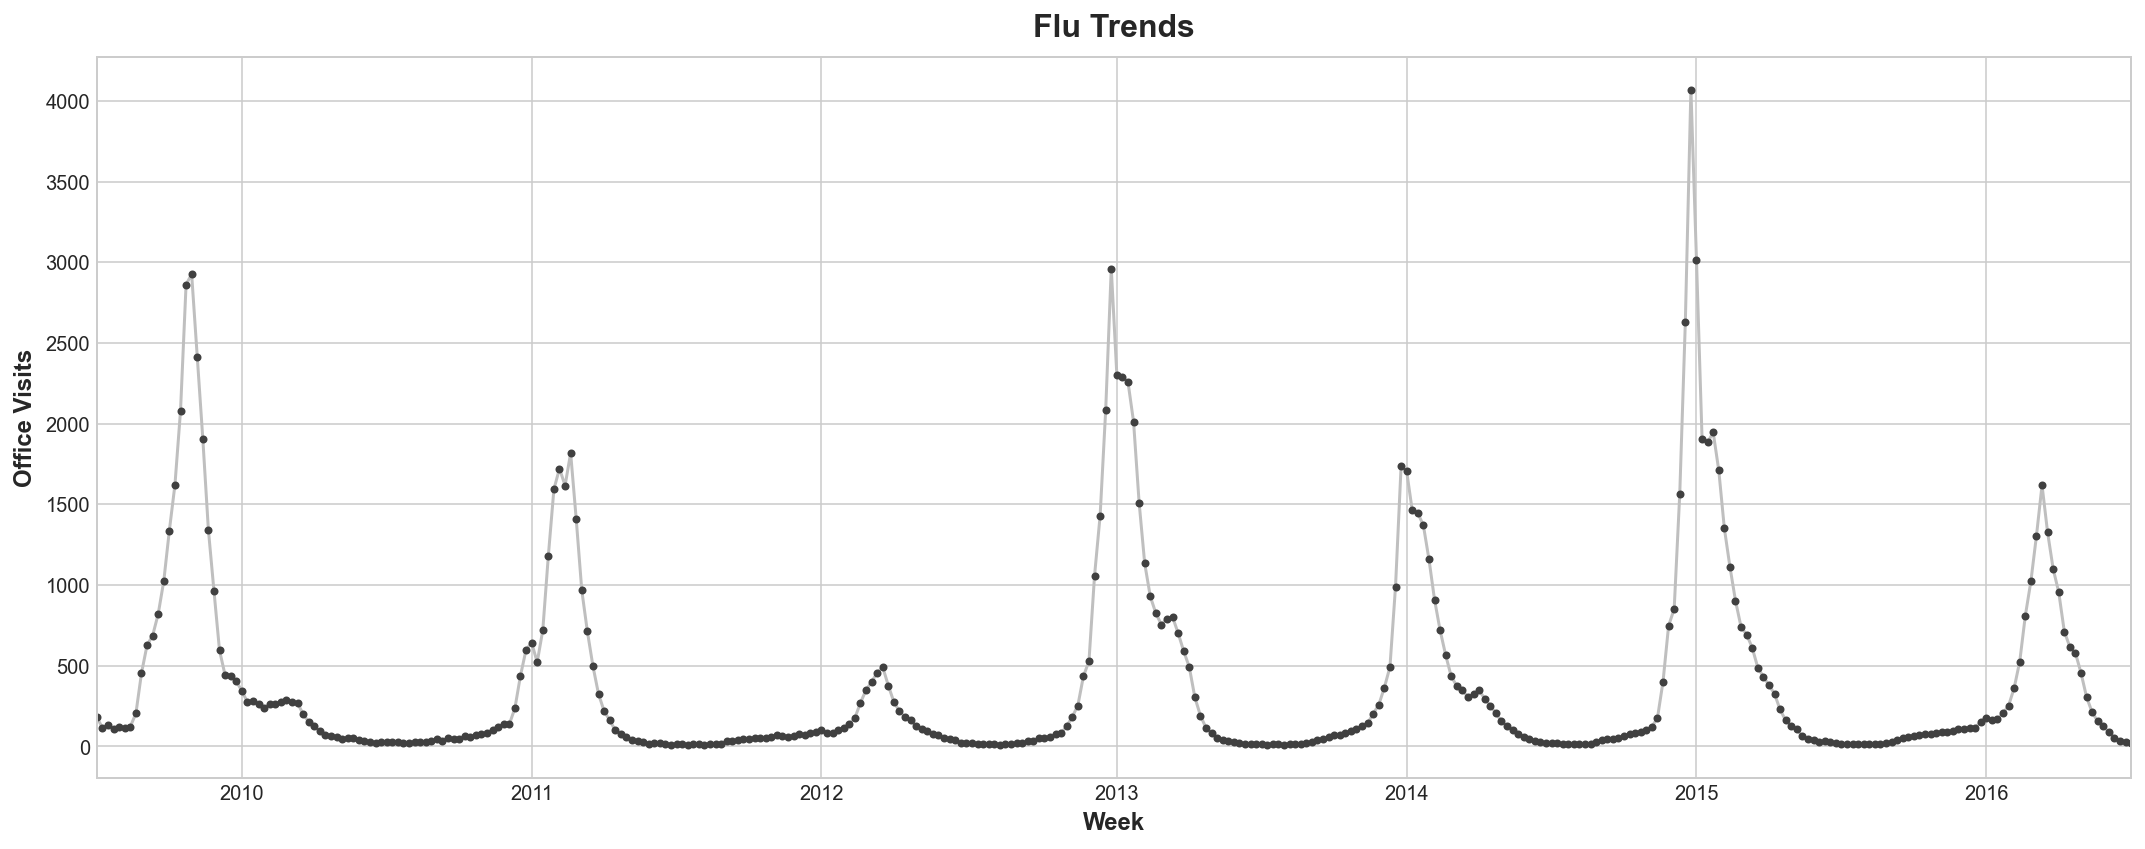

In [17]:
data_dir = Path('Time_Series/archive-2/')
flu_trends = pd.read_csv(data_dir / 'flu-trends.csv')
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq='W'),
    inplace=True,
)
flu_trends.drop('Week', axis=1, inplace=True)

ax= flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

Nossos dados de gripe mostram ciclos irregulares ao inves de uma regular sazonalidade. os picos tendem a ocorrer dentro de um ano novo, mas as vezes antes ou posteriormente, as vezes maiores ou menores. Modelar esses ciclos com lag features irá permitir nosso previsor a reagir dinamicamente as mudanças de condições ao invés de ser restrito as datas e tempos exatos da feature sazonal.

Vamos olhar a lag e como fica o plot autocorrelacional primeiro:

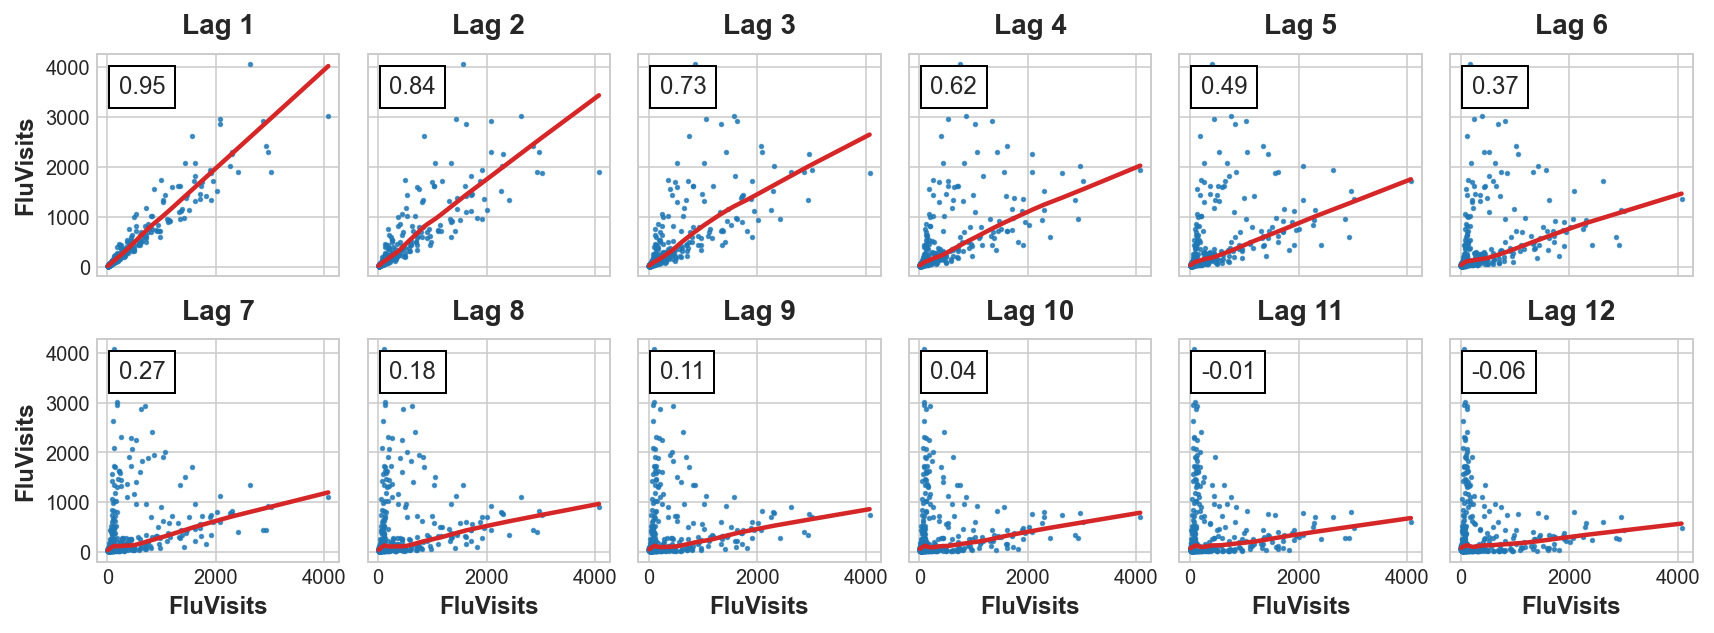

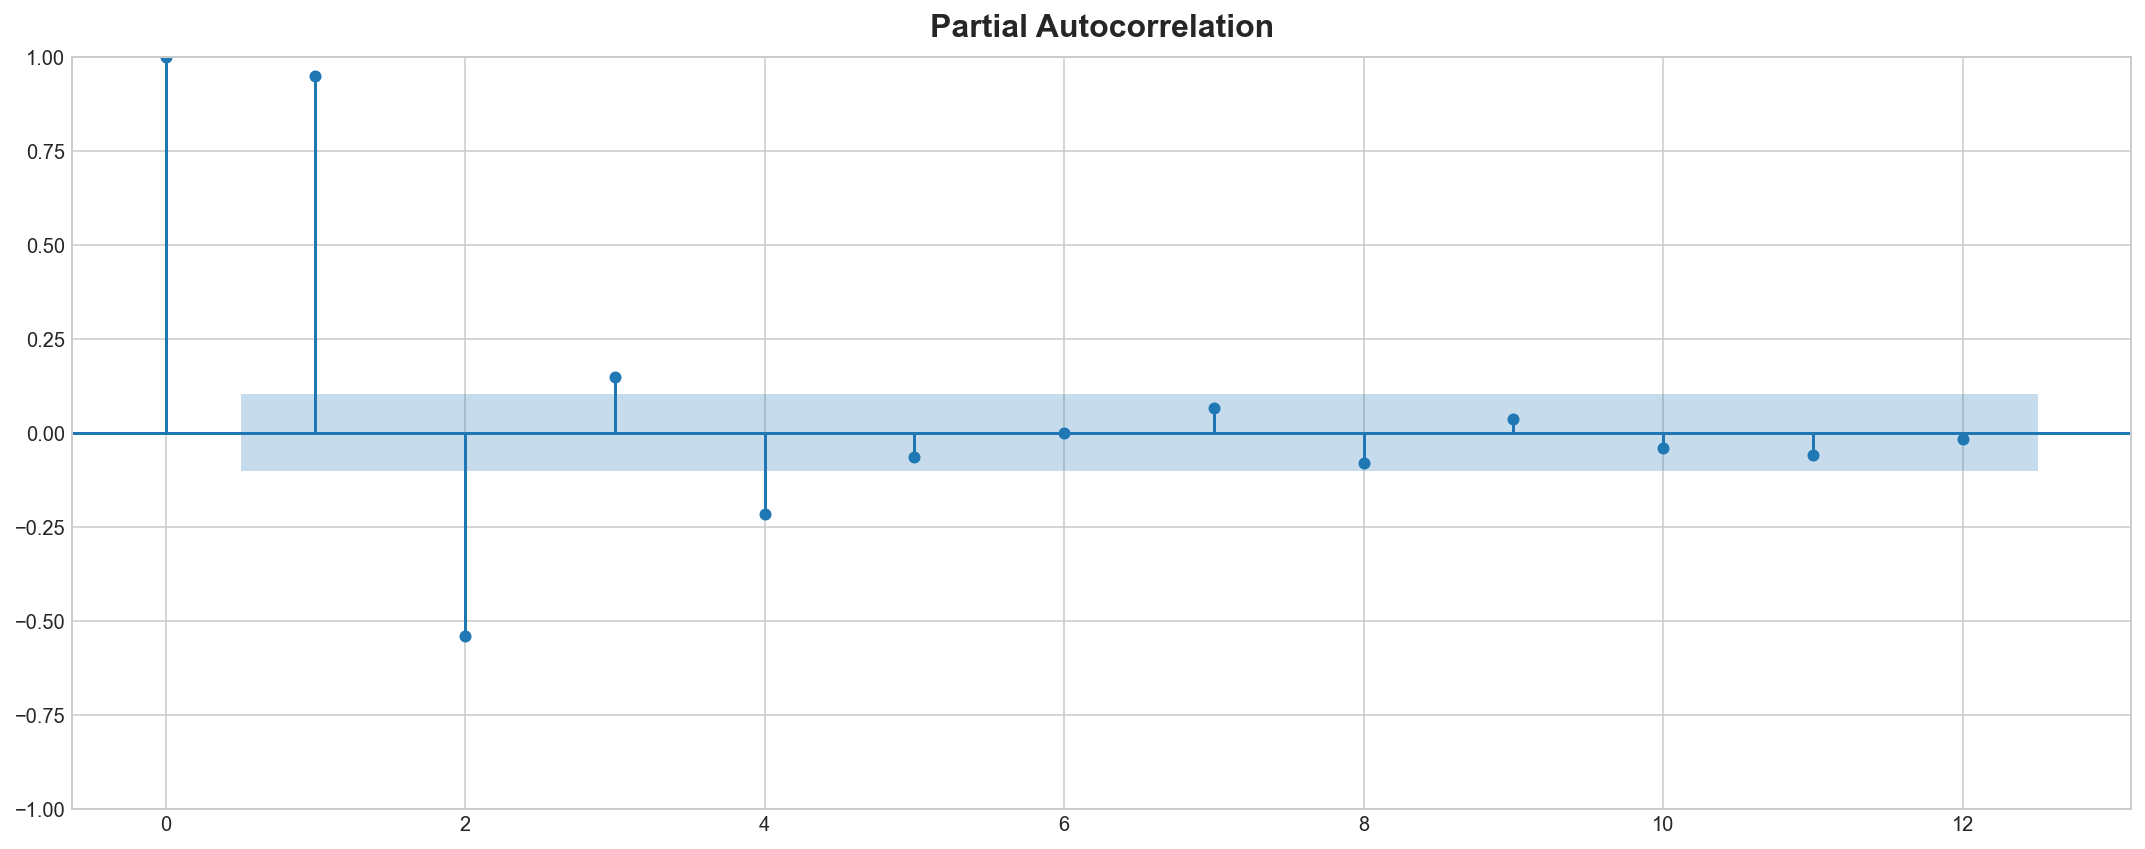

In [24]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

As lag plots indicam que o relacionamento de FluVisits com as suas lags são em maioria linear, enquanto a autocorrelação parcial sugere que a dependência pode ser capturada utilizando as lags 1, 2, 3 e 4. Nos podemos atrasar uma série temporal no Pandas com o método shift. Para este problema, nos iremos preencher os missings que a lag criar po 0.0.

In [25]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

Nas lições anteriores, nos criamos fomos capazes de criar previsões para quantos passos nos desejássemos além dos dados de treinamento. Quando usamos lag features, contudo, estamos limitados a prever os passos de tempo cujos valores disponíveis da lag feature. Utilizando a feature lag 1 na segunda-feira, não conseguimos fazer uma previsão para quarta-feira porque o valor necessário da lag 1 é terça-feira, o que ainda não aconteceu.

Iremos ver estratégias para lidar com este problema na lição 6. Por exemplo, so iremos usar valores do set de teste.

In [26]:
# Criar a série de target e split dos dados
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# fittar e prever
model = LinearRegression()      # fit_intercept=True desde que não usémos o DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

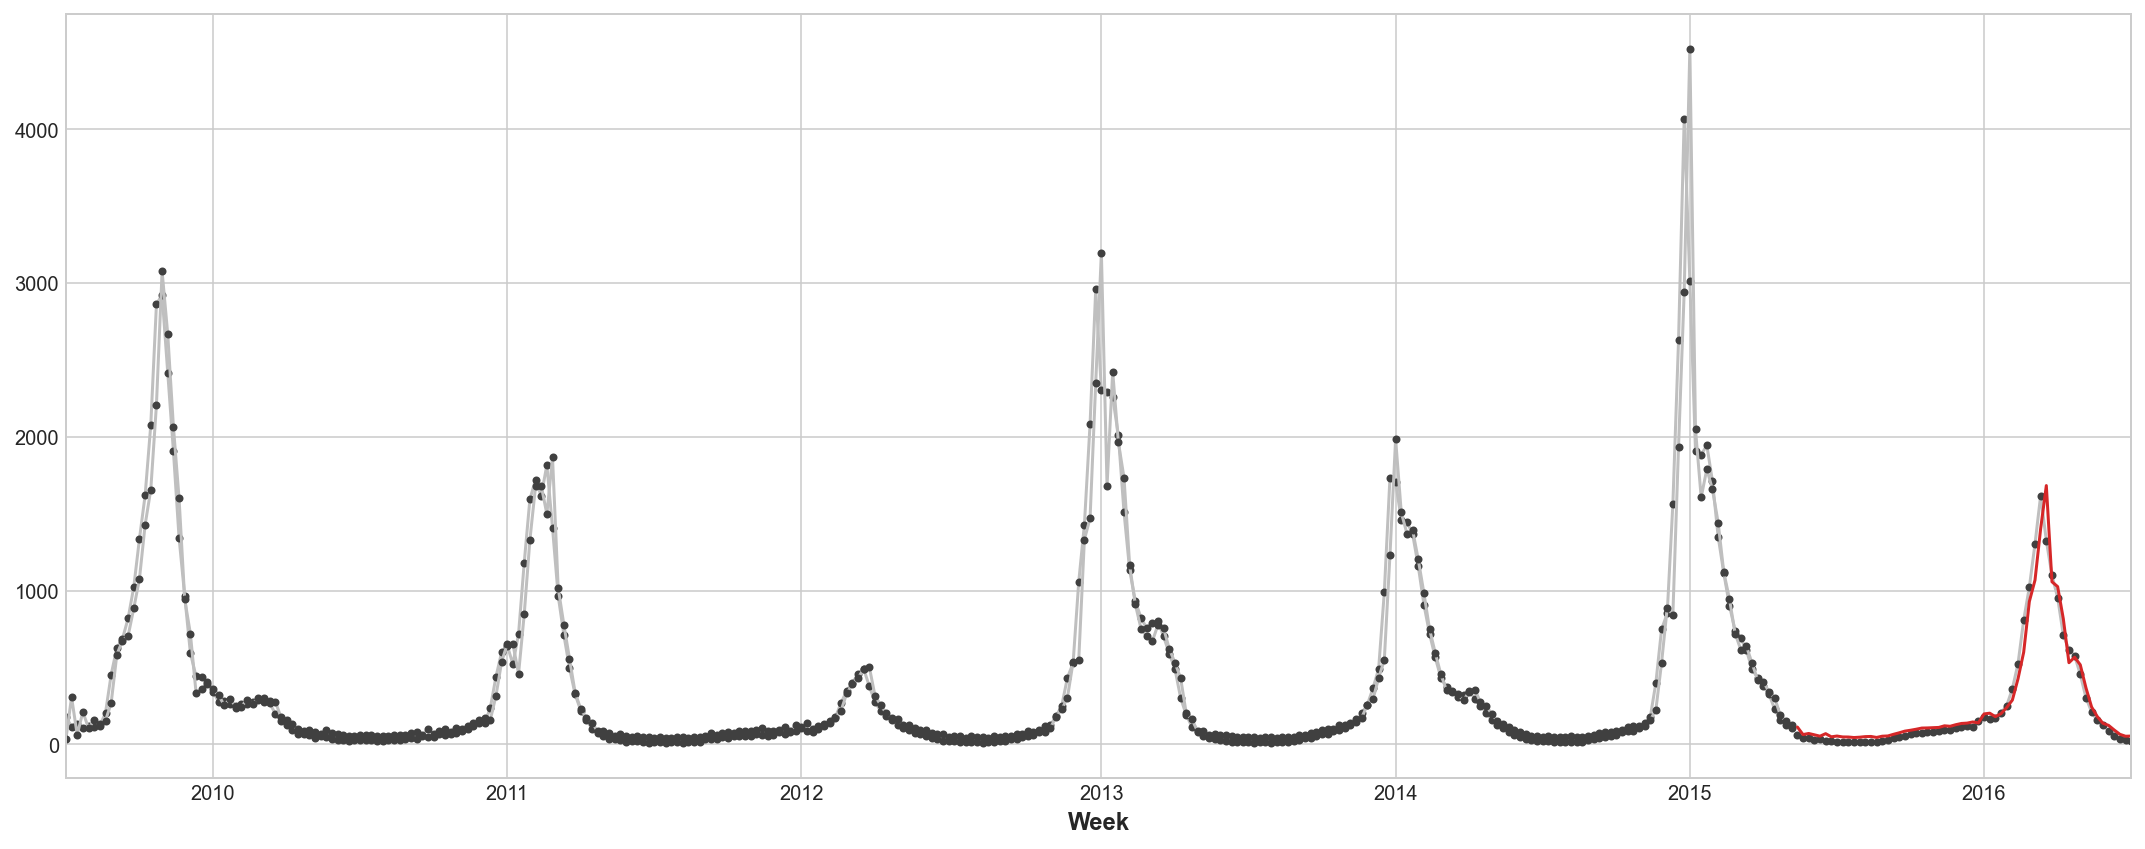

In [27]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Apenas olhando aos valores previstos, podemos ver como o nosso modelo necessita de um passo temporal para reagir as mudanças na série target. Isso é uma limitação comum do modelo que usamos apenas para lags da série target como features.

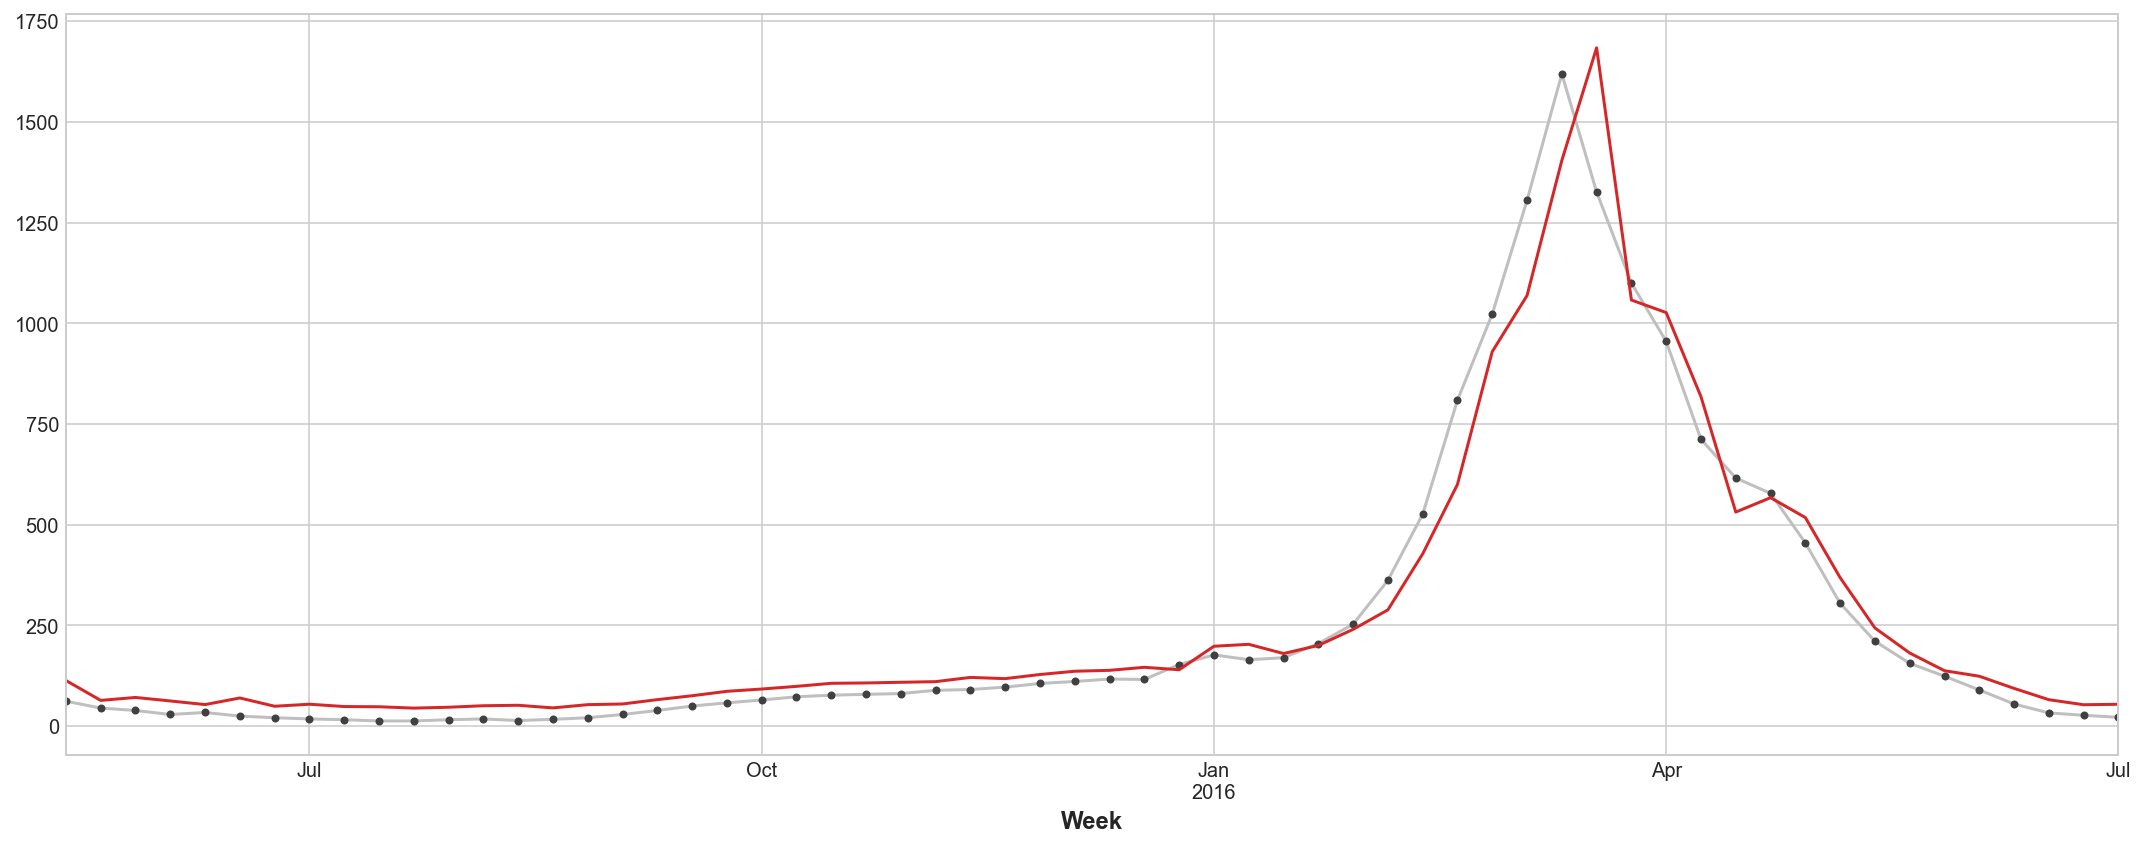

In [28]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Para melhorar a previsão podemos tentar achar o leading indicator, séries temporais podem prover um 'aviso prévio' para mudanças nos casos de gripe. Para nossa segunda abordagem então iremos adicionar aos nossos dados de treinamento a popularidade de algumas buscas relacionadas a gripe medidas pelo Google Trends.

Plotar as buscas pela frase 'FluCough' sobre o target 'FluVisits' sugere que essas buscas podem ser um leading indicator útil: buscas relacionadas por gripe tendem a ser mais populares nas semanas anteriores às visitas ao consultório.

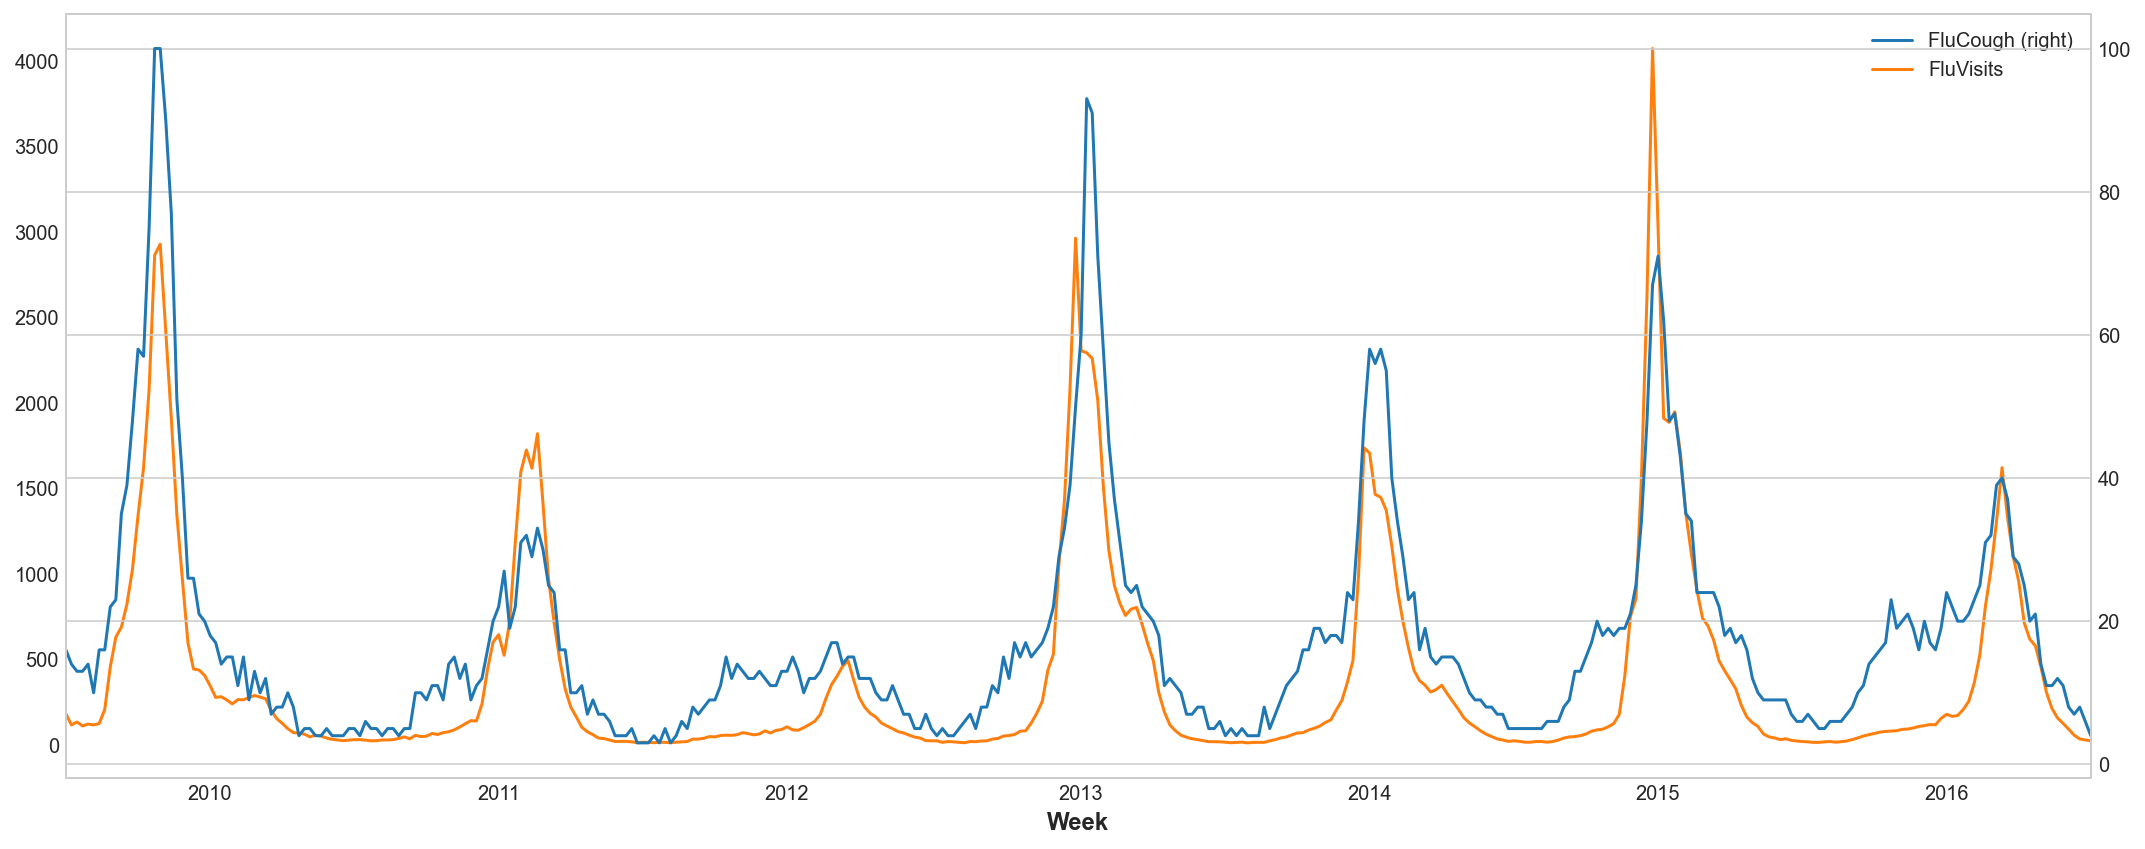

In [30]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

O Dataset contém 129 desses termos, mas iremos usar apenas alguns.

In [32]:
search_terms = ['FluContagious', 'FluCough', 'FluFever', 'InfluenzaA', 'TreatFlu', 'IHaveTheFlu', 'OverTheCounterFlu', 'HowLongFlu']

# Criando 3 lags para cada termo da pesquisa
X0 = make_lags(flu_trends[search_terms], lags=3)

# Criando 4 lags para cada target, como anteriormente
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combinando para criar os dados de treinamento
X = pd.concat([X0, X1], axis=1).fillna(0.0)

Nossas previsões são um pouco rudimentar, mas nosso modelo aparenta ser melhor capáz de antecipar o aumento repentino das visitas, sugerindo que a popularidade das diversas séries temporais de busca foram de fato eficazes como leading indicators.

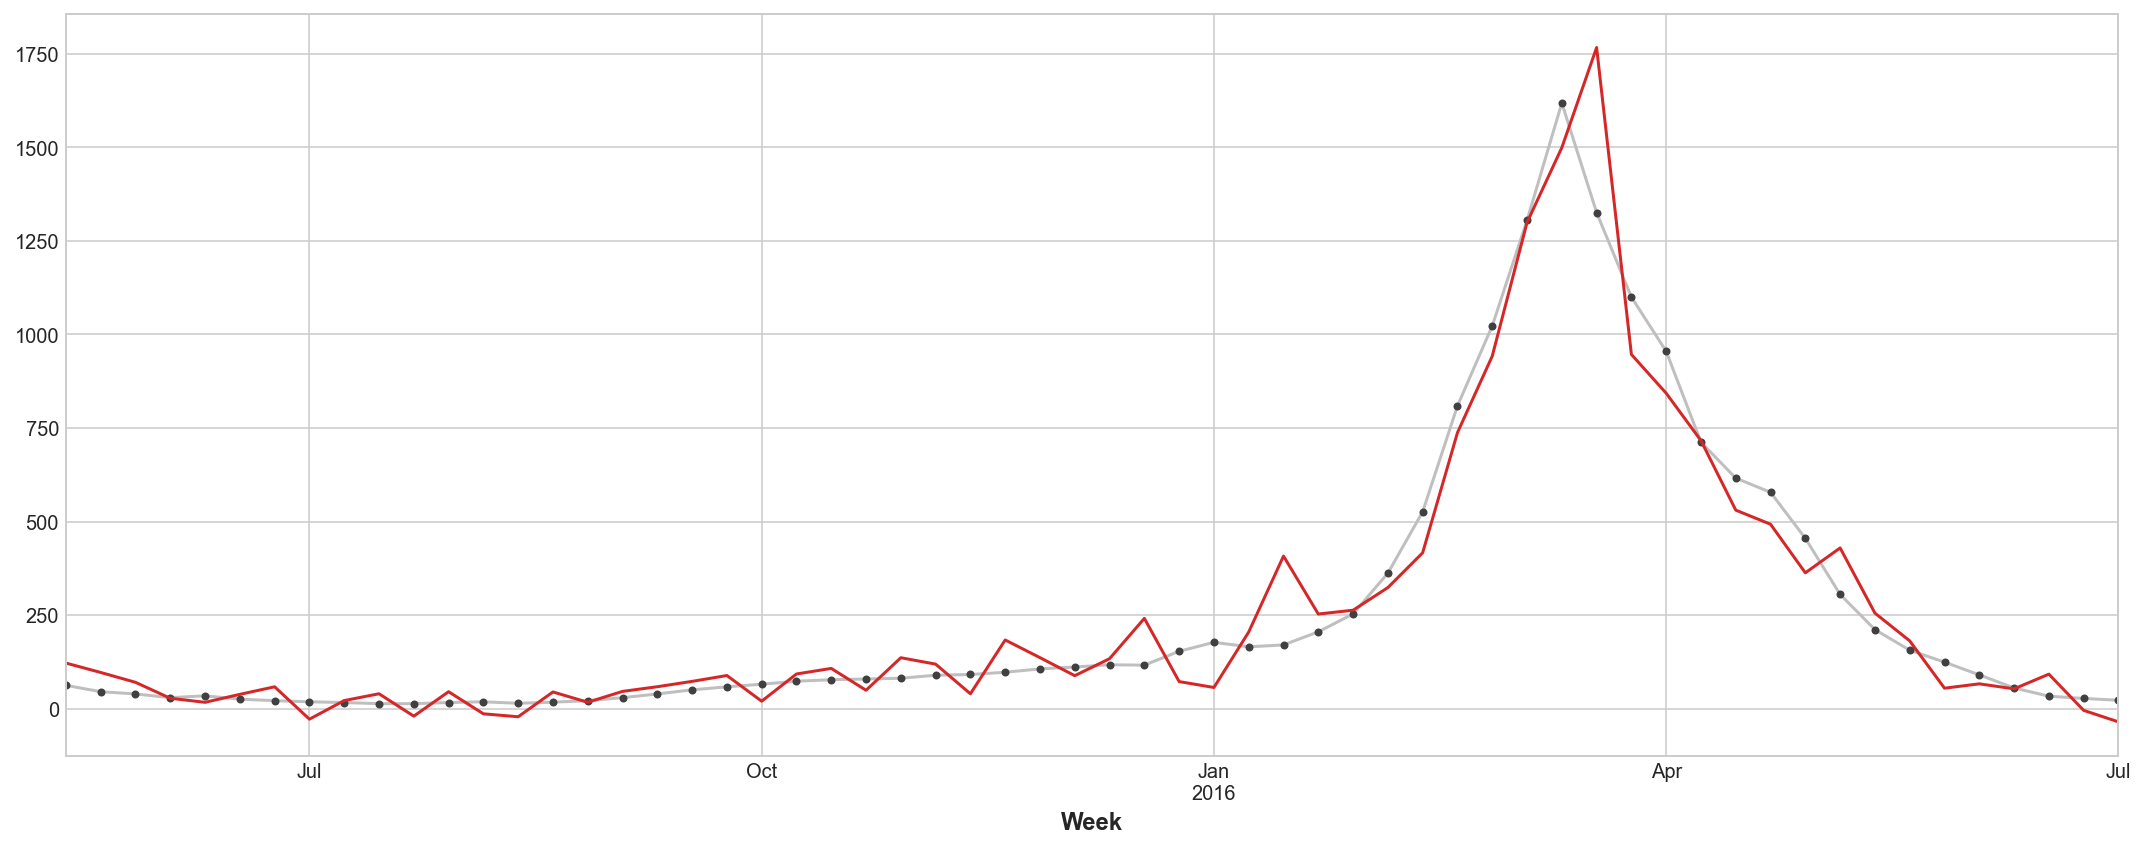

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

As séries temporais ilustradas nesta lição são o que você pode chamar de "pure cylic": elas não têm tendência ou sazonalidade óbvias. Não é incomum, porém, que as séries temporais possuam tendência, sazonalidade e ciclos - todos os três componentes ao mesmo tempo. Você pode modelar essas séries com regressão linear apenas adicionando os recursos apropriados para cada componente. Você pode até combinar modelos treinados para aprender os componentes separadamente, o que aprenderemos a fazer na próxima lição com a previsão de híbridos.

### Exercício

rode a célula abaixo para preparar o ambiente

In [60]:
# Setup notebook
from pathlib import Path


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


comp_dir = Path('Time_Series/store-sales-time-series-forecasting/')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

Nem toda família de produtos tem vendas com comportamento cíclico, nem a série de vendas médias. As vendas de material escolar e de escritório, no entanto, apresentam padrões de crescimento e declínio não bem caracterizados por tendências ou estações do ano. Nesta pergunta e na próxima, você modelará ciclos de vendas de material escolar e de escritório usando recursos de atraso.

Tanto a tendência quanto a sazonalidade criarão dependência serial que aparece em correlogramas e gráficos de defasagem. Para isolar qualquer comportamento puramente cíclico, começaremos dessazonalizando a série. Use o código na próxima célula para dessazonalizar Vendas de Suprimentos. Armazenaremos o resultado em uma variável y_deseason.

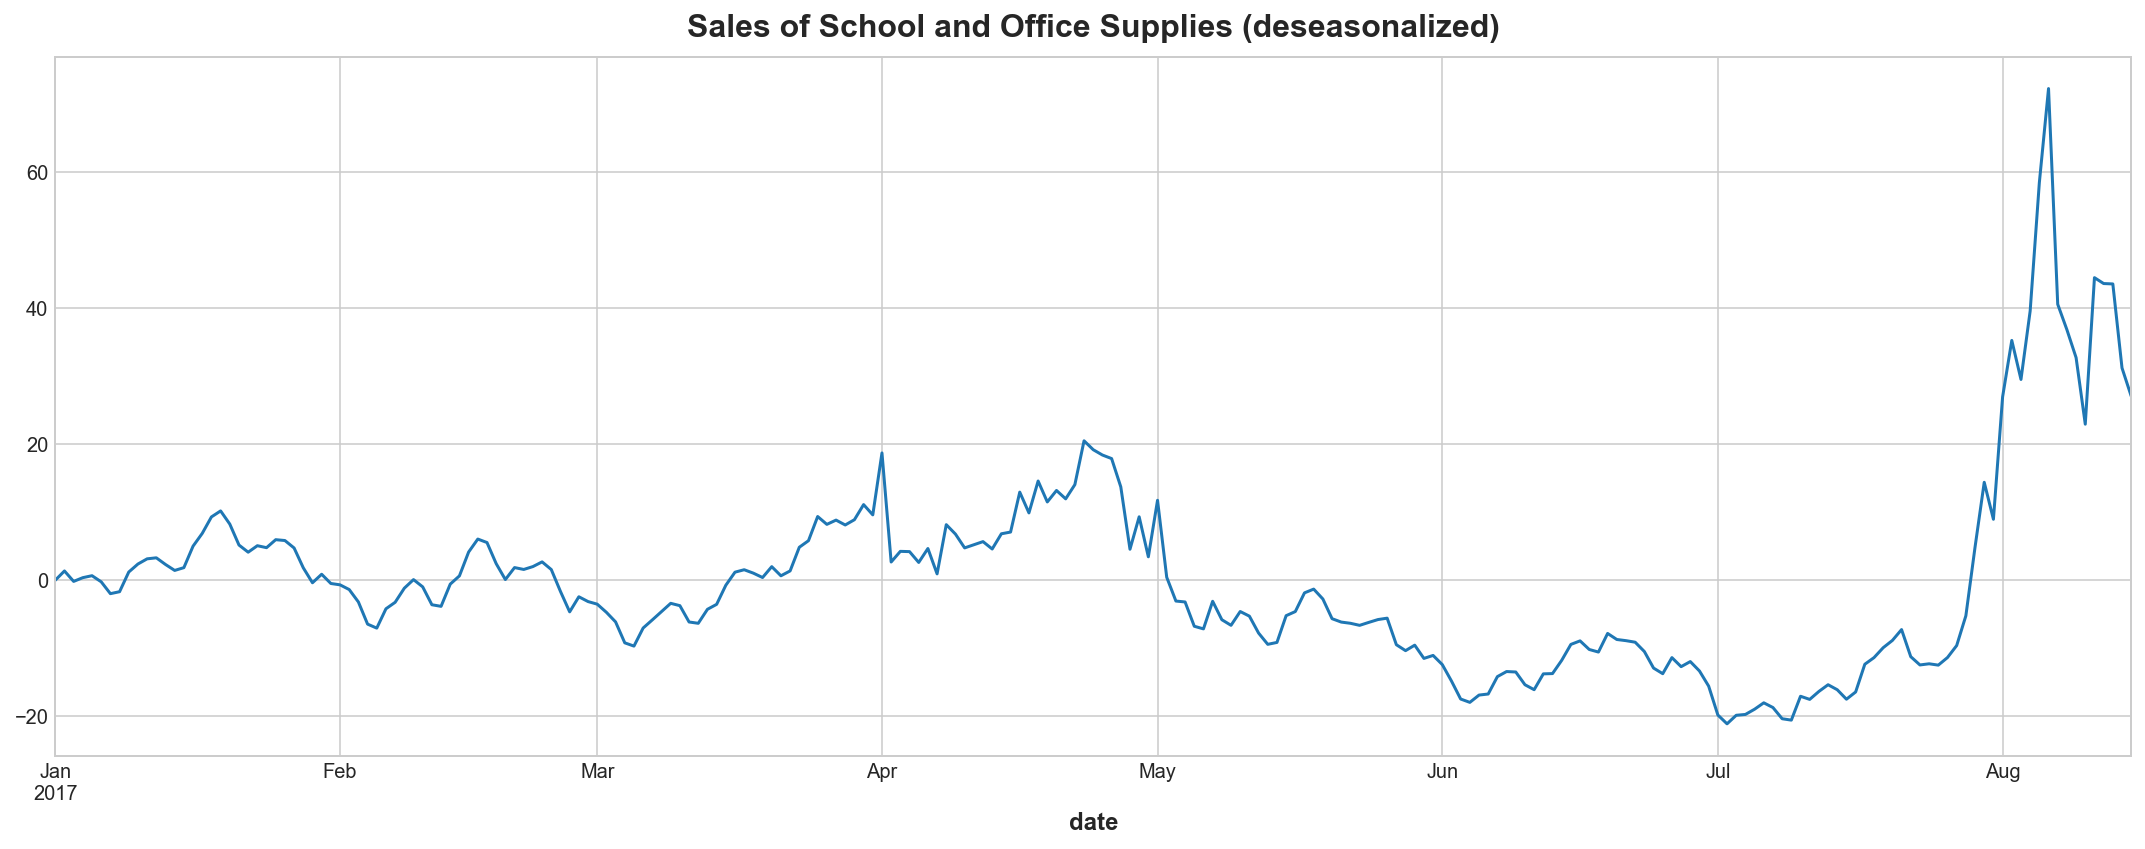

In [37]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

Essa série dessazonalizada apresenta padrões cíclicos? Para confirmar nossa intuição, podemos tentar isolar o comportamento cíclico usando um gráfico de média móvel, assim como fizemos com a tendência. A ideia é escolher uma janela longa o suficiente para suavizar a sazonalidade de curto prazo, mas curta o suficiente para ainda preservar os ciclos.

### 1) Plotando Ciclos

Crie uma média móvel de sete dias a partir de y, a série de vendas de suprimentos. Use uma janela centralizada, mas não defina o argumento min_periods.

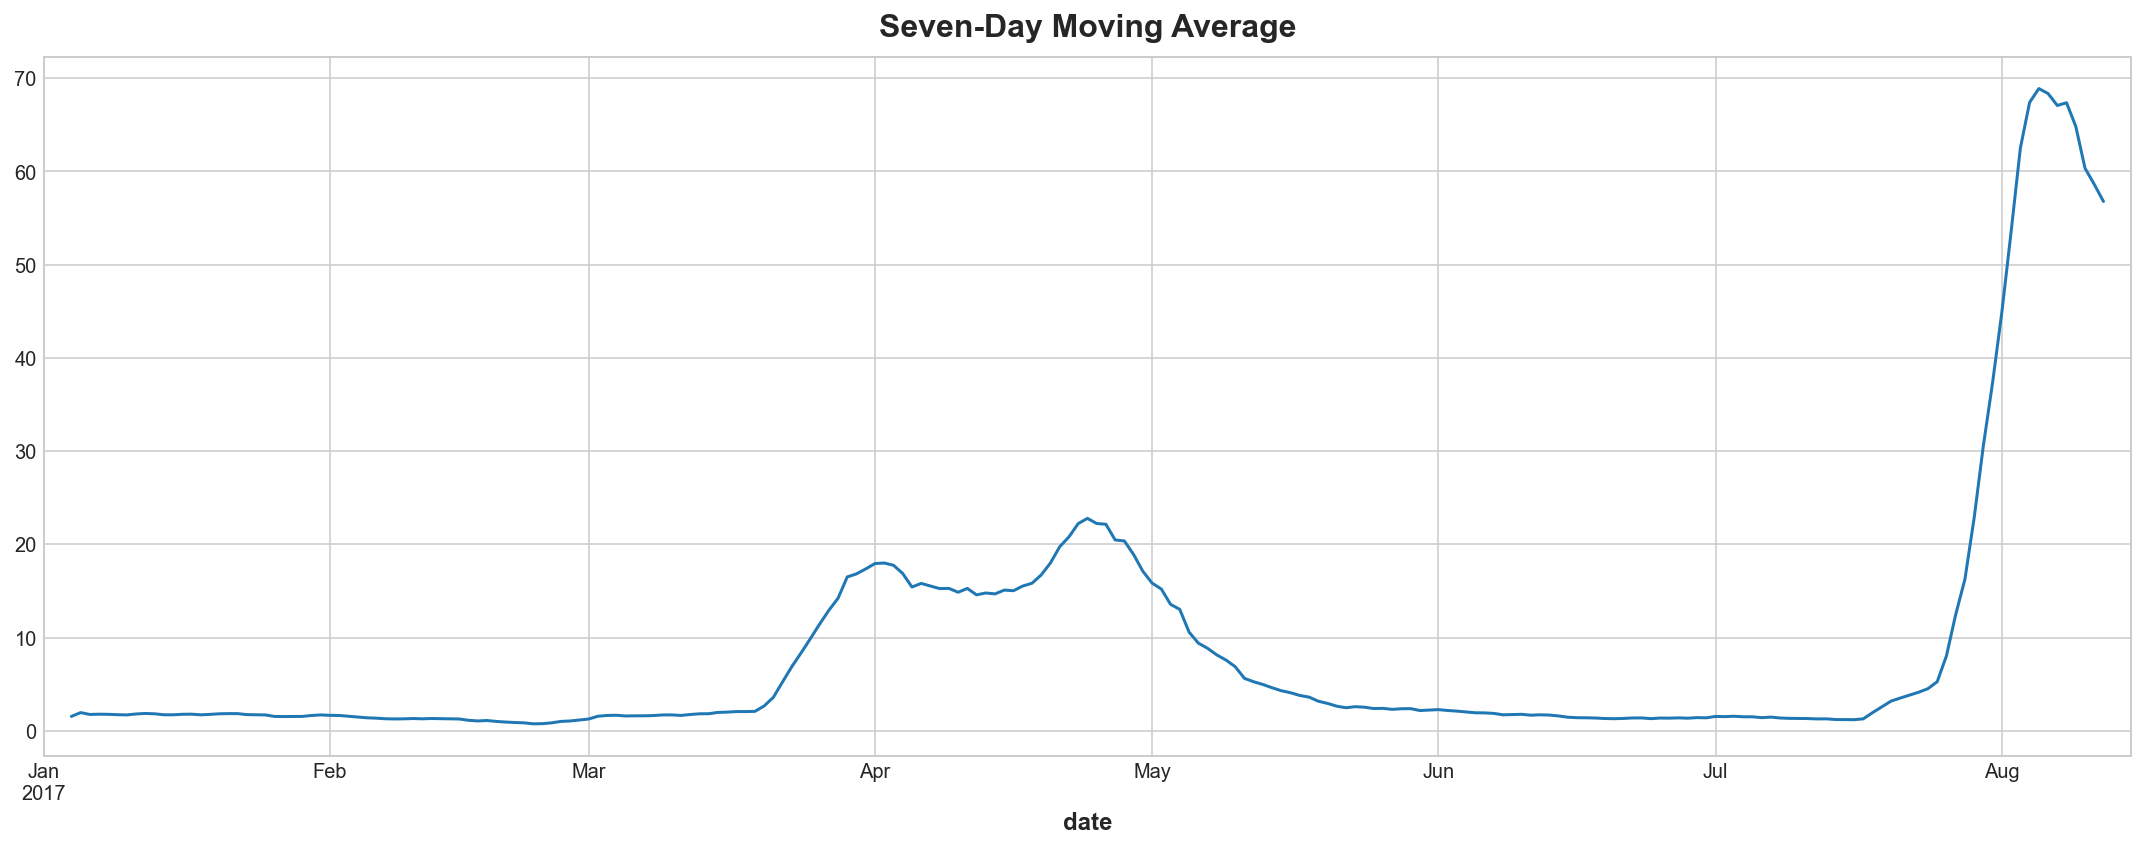

In [38]:
y_ma = y.rolling(
    window=7,
    center=True
).mean()


# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average")
plt.show()

Você vê como o enredo da média móvel se assemelha ao enredo da série dessazonalizada? Em ambos, podemos ver o comportamento cíclico indicado.

Vamos examinar nossa série dessazonalizada para dependência serial. Dê uma olhada no correlograma de autocorrelação parcial e no gráfico de defasagem.

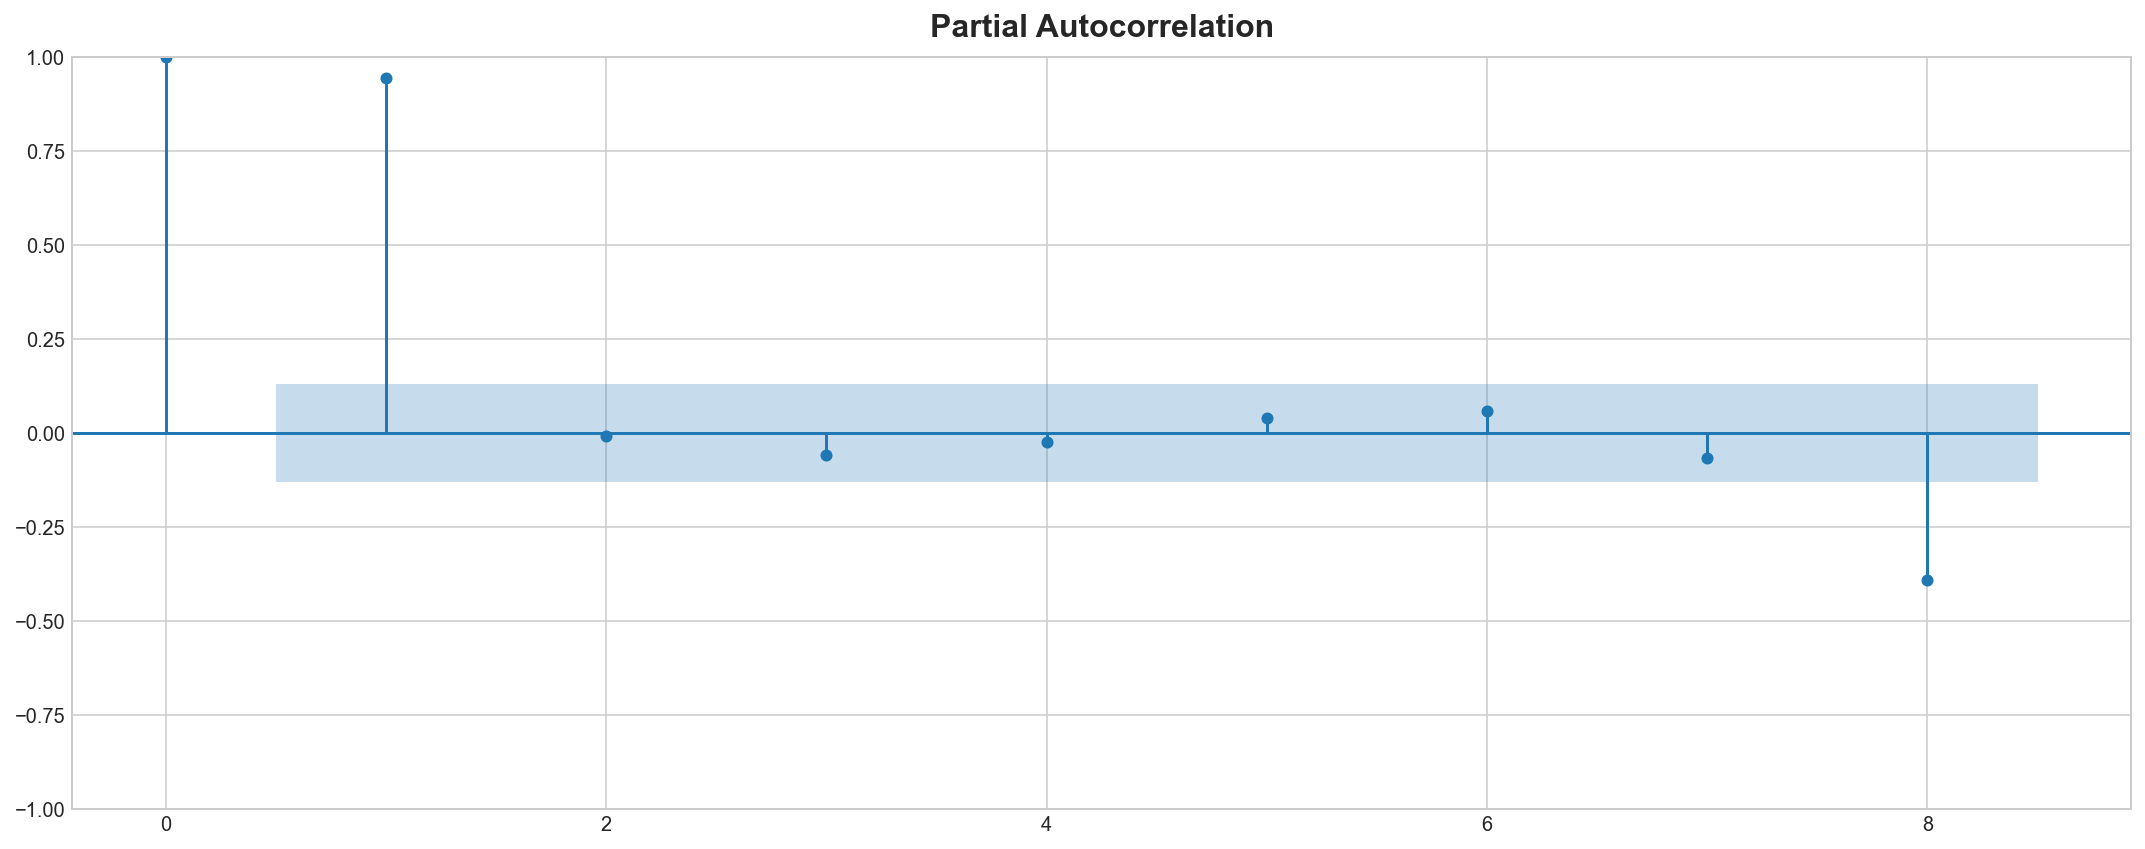

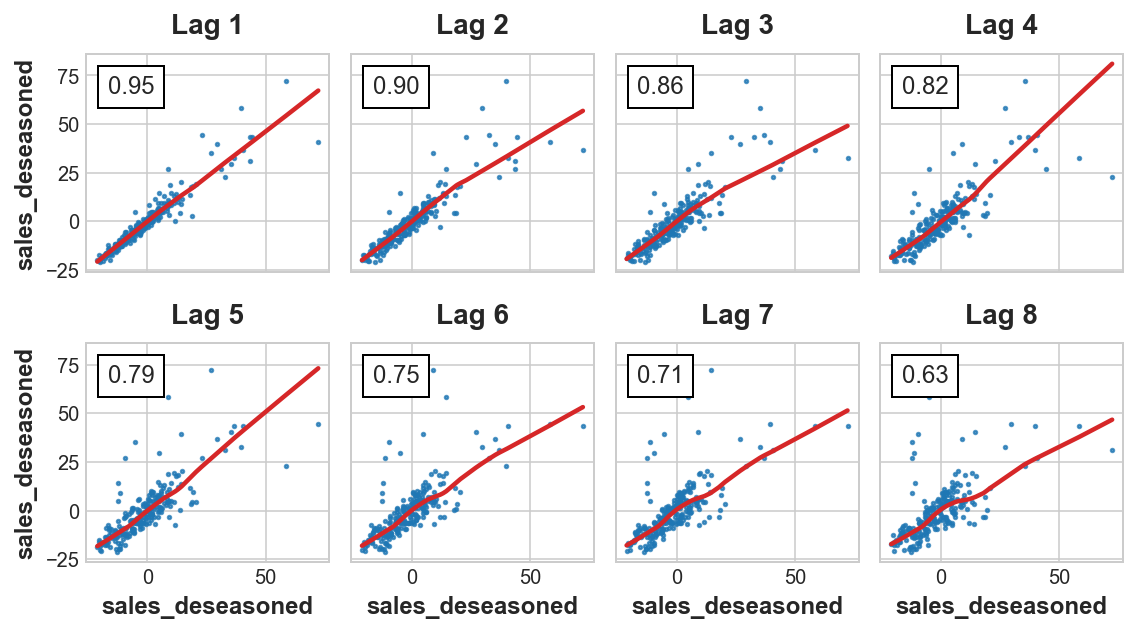

In [39]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

### 2) Examine a dependência serial de Store Sales

Algum dos atrasos é significativo de acordo com o correlograma? O gráfico de defasagem sugere alguma relação que não foi aparente no correlograma?

Depois de pensar em sua resposta, execute a próxima célula.

R: O correlograma indica que a primeira defasagem provavelmente será significativa, bem como possivelmente a oitava defasagem. O gráfico de defasagem sugere que o efeito é principalmente linear.

Lembre-se do tutorial que um indicador avançado é uma série cujos valores em um momento podem ser usados para prever a meta em um momento futuro -- um indicador avançado fornece "aviso prévio" de alterações na meta.

O conjunto de dados da competição inclui uma série temporal que pode ser útil como um indicador importante - a série onpromotion, que contém o número de itens em uma promoção especial naquele dia. Como a própria empresa decide quando fazer uma promoção, não há preocupação com "vazamento antecipado"; poderíamos usar o valor da promoção de terça-feira para prever as vendas de segunda-feira, por exemplo.

Use a próxima célula para examinar os valores iniciais e atrasados para a promoção plotados em relação às vendas de material escolar e de escritório.

In [52]:
# Código baixado do Github: https://github.com/Kaggle/learntools/blob/master/learntools/time_series/utils.py

def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

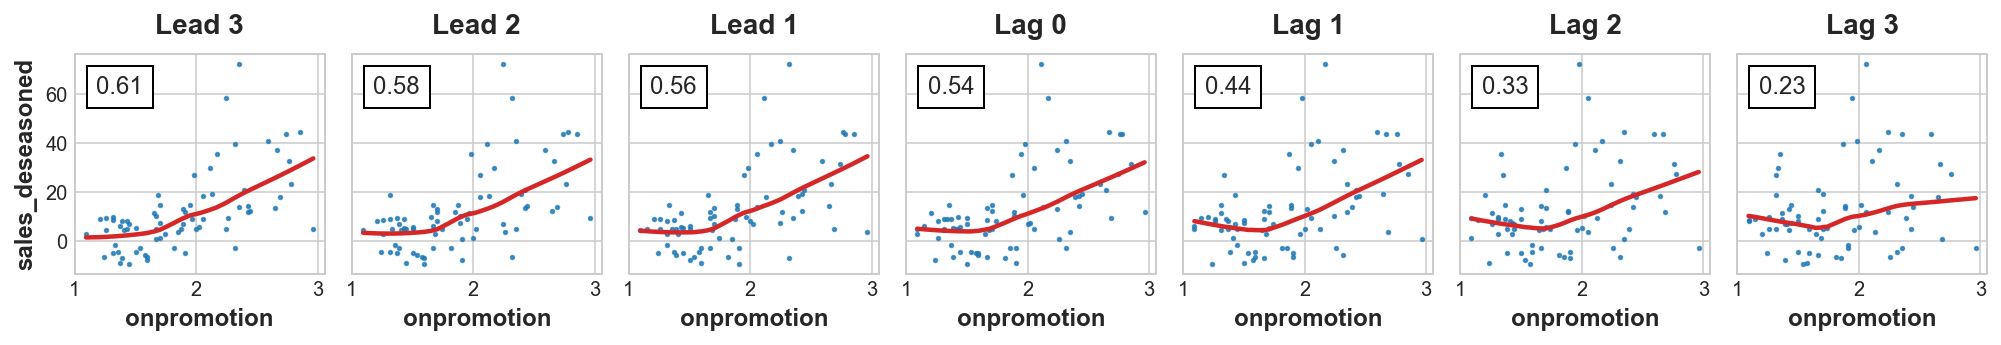

In [53]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')
 
# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1);

### 3) Examine as features da série temporal

Parece que os valores iniciais ou atrasados de onpromotion podem ser úteis como um recurso?

R: O gráfico de defasagem indica que os valores iniciais e defasados da promoção estão correlacionados com as vendas de suprimentos. Isso sugere que ambos os tipos de valores podem ser úteis como recursos. Pode haver alguns efeitos não lineares também.

### 4) Criando features da série temporal

Crie os recursos indicados na solução da Pergunta 3. Se nenhum recurso dessa série for útil, use um dataframe vazio pd.DataFrame() como sua resposta.

In [55]:
def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)

In [56]:
X_lags = make_lags(y_deseason, lags=1)

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1)
    ],
    axis=1
)

X = pd.concat([X_time, X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

Use o código na próxima célula se quiser ver as previsões do modelo resultante.

Training RMSLE: 0.23893
Validation RMSLE: 0.34245


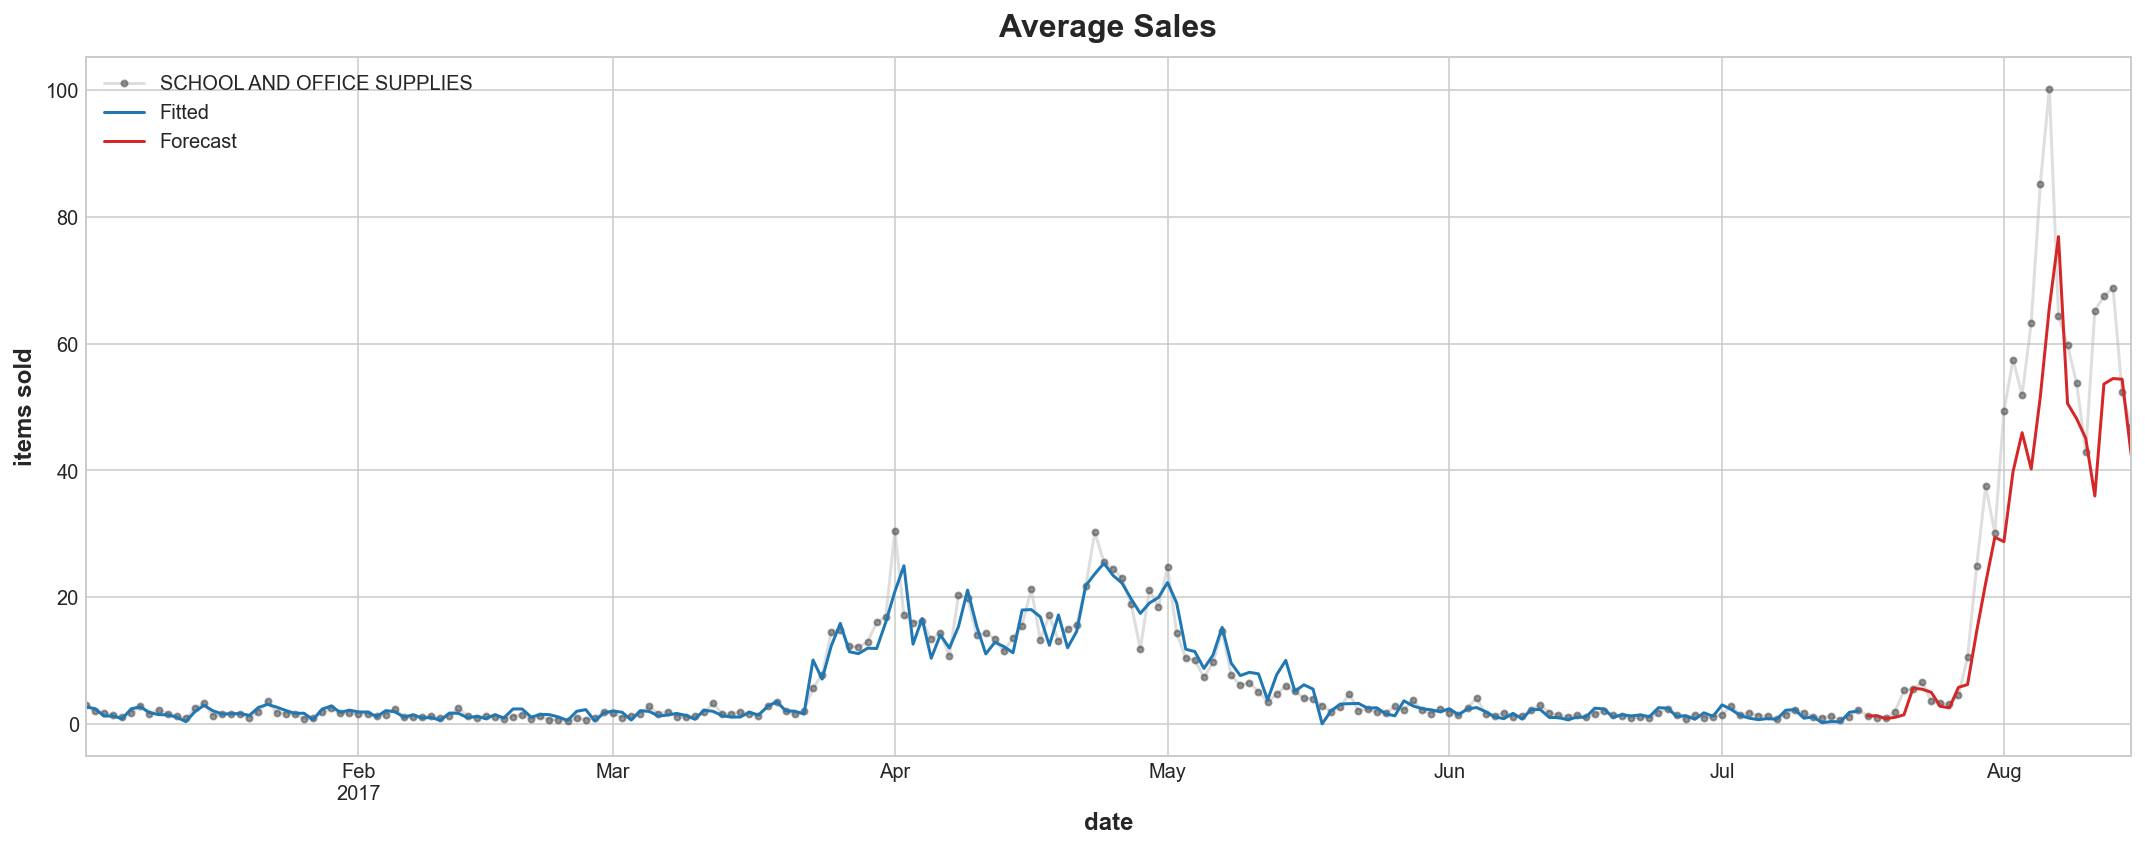

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

Os vencedores das competições de previsão do Kaggle geralmente incluem médias móveis e outras estatísticas contínuas em seus conjuntos de recursos. Esses recursos parecem ser especialmente úteis quando usados com algoritmos GBDT como o XGBoost.

Na Lição 2, você aprendeu a calcular médias móveis para estimar tendências. A computação de estatísticas rolantes a serem usadas como recursos é semelhante, exceto que precisamos tomar cuidado para evitar vazamento de antecipação. Primeiro, o resultado deve ser definido na extremidade direita da janela em vez do centro -- ou seja, devemos usar center=False (o padrão) no método de rolagem. Em segundo lugar, a meta deve ser defasada um passo.

### 5) Criando features estatísticas

Edite o código na próxima célula para criar os seguintes recursos:

* Mediana contínua de 14 dias (mediana) da meta defasada
* Desvio padrão contínuo de 7 dias (std) da meta defasada
* Soma de 7 dias (soma) de itens "em promoção", com janela centralizada

In [58]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

mean_7 = y_lag.rolling(7).mean()
median_14 = y_lag.rolling(14).median()
std_7 = y_lag.rolling(7).std()
promo_7 = onpromo.rolling(
    window=7,
    center=True,
).sum()


Confira a documentação do Pandas Window para obter mais estatísticas que você pode calcular. Tente também janelas "ponderadas exponencialmente" usando ewm no lugar de rolamento; o decaimento exponencial geralmente é uma representação mais realista de como os efeitos se propagam ao longo do tempo.

# Modelos Híbridos (Hybrid Models)

Combine a força de dois forecasters com esta técnica poderosa

**Intrudução**

Regressão Linear se destaca extrapolando a tendência, mas não pode aprender interações. XGBoost se destaca aprendendo interações, mas não pode extrapolar tendências. Nesta lição iremos aprender como criar um forecaster 'híbrido' que combina algorítmos de aprendizagem de forma complementar e deixa a força de um compensar a fraqueza do outro.

**Componentes e Residuais**

Então para desenhar híbridos efetivos, temos que ter um melhor entendimento de como as séries temporais são construídas. Nos estudamos até agora três padrões de dependência. tendências, temporadas e ciclos. Muitas séries temporais pode ser aproximadamente descritas por um modelo aditivo com apenas essas três componentes mais uma essencial inprevisível, inteiramente um erro aleatório.

series = trend + seasons + cycles + error

Cada termo nesse modelo nos podemos chamar de componentes da série temporal.

O **residual** de um modelo é a diferença entre o target do modelo que foi treinado e as previsões que o modelo fez -- a diferença entre a curva atual e a curva fitada, em outras palavras. Plotar resifual contra a feature, e teremos a parte de fora do target, ou o que o modelo falhou em aprender sobre o target daquela feature.

<center><img src = https://i.imgur.com/mIeeaBD.png/>

Diferença entre o target da série e as previsões (em azul) nos da o residual da série

Na esquerda da figura acima é a porção da série Tunnel Traffic e a curva de tendência sazonal da lição 3. Subtraindo da curva fitada deixa o residual a direita. O residual contém tudo da tendência sazonal de Tunnel Traffic que o modelo não aprendeu.

Nos podemos imaginar o aprendizado das componentes da série temporal como um processo interativo: primeiro aprendemos a tendência e subtraímos da série, então aprendemos a sazonalidade da dasazonalidade residual e subtraímos das temporadas, então aprendemos os ciclos e subtraímos os ciclos fora, e finalmente somente o erro imprevisível resta.

<center><img src = https://i.imgur.com/XGJuheO.png/>

Aprendendo as componentes da Muna Loa CO2 passo a passo. Subtraíndo a curva fittada (em azul) da série para conseguir a próxima série do próximo passo.

E juntas todas as componentes que aprendemos completam o modelo. Isso essencialmente é oque a regressão linear irá fazer se treinarmos em um set completo de features modelando tendência, temporada e ciclos.

<center><img src = https://i.imgur.com/HZEhuHF.png/>

Adicionando as componentes aprendidas em um modelo completo

**Previsão Híbrida com residuais**

Nas licões anteriores, nos usamos um algorítmo apenas (Regressão Linear) para aprender todas as componentes de uma vez, mas também é possível usar um algorítmo para algumas componentes e outro algorítmo para o resto das componentes. Dessa maneira podemos sempre escolher o melhor algoritmo para cada componente. Para isso, usamos um algorítmo para fittar a série original um segundo algorítmo para fittar o residual.

Em detalhe, o processo é esse:

In [ ]:
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2

Nos usualmente queremos usar diferentes set de features (X_train_1 e X_train_2 e por diante) dependendo do que queremos que cada modelo aprenda. Se nos usarmos o primeiro modelo para aprender a tendência, geralmente não precisamos de uma feature de tendência para um segundo modelo, por exemplo.

Enquanto é possível usar mais de dois modelos, na prática não aparenta ser especialmente útil. De fato, a estratégia mais comum para construir híbridos é a que descrevemos: um simples (usualmente linear) algorítmo de aprendizagem seguido de um mais complexo, não-linear como GBDTs ou uma deep neural net, o modelo simples tipicamente é desenhado como um ajudante para o algorítmos mais poderoso seguinte.

**Designing Hybrids**

Existem diversas maneiras que nos podemos combinar modelos de machine learning além deste que abordamos nesta lição. Combinando modelos com sucesso, requer que pesquisemos um pouco mais profundamente sobre como esses algorítmos operam.

Geralmente existem duas maneiras que o algorítmo de regressão realiza previsões: serja por transformação das features ou transformando o target. Algorítmos de transformação de features aprendem algumas funções matemáticas que pega a feature como input e então combinam e transformam elas para produzir um output que combine com os valores do target no set de treinamento. Regressão linear e redes neurais são deste tipo.

Algorítmos de transformação do target usa features para agrupar os valores do target